# **==== Trabalho de Ciência de Dados ( *INF 493* ) ====** #
 * **Nome:** Kayo de Melo Lage
 * **Matrícula:** 116211

### **OBS.:** Esse *script* foi feito para rodar no ambiente do *Google Colab* e ser *"plug and play"*, isto é, ele faz tudo desde a instalação e preparação dos dados até o treinamento e avaliação dos modelos, por questões de simplicidade. Se for rodar pelo *Colab* é recomendado que crie uma pasta para um projeto do *Google Colab* adaptando só o seu *path*.

# 🎯 Objetivo do Projeto

Este notebook aborda um problema de **Classificação** no contexto de saúde pública. O objetivo principal é desenvolver um modelo preditivo capaz de diagnosticar o nível de gravidade da Dengue com base em dados clínicos e demográficos.

### 🧬 Estrutura do Problema

* **Entrada (Features):** Dados do paciente (Sintomas, Idade, Sexo, Comorbidades, etc.).
* **Saída (Target):** Previsão da classe clínica do paciente.

* Algo que parece ser irrelevante, mas é ***MUITO essencial*** é como o ***Ministério da Saúde*** classifica as dengues (sobretudo para os dados mais antigos de 2016 para trás), e aqui está: https://www.gov.br/saude/pt-br/centrais-de-conteudo/publicacoes/svsa/dengue/dengue-diagnostico-e-manejo-clinico-adulto-e-crianca/@@download/file

## Conectando ao drive

In [ ]:
from google.colab import drive
from googleapiclient.discovery import build
from google.colab import auth
import os

path = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"
drive.mount('/content/drive')


Mounted at /content/drive


## Download do dataset

In [ ]:
import os
import shutil
import subprocess
from pathlib import Path

# --- CONFIGURAÇÕES ---
# Anos 2007–2025 (formato 07–25)
# range(start, stop, step) -> stop é exclusivo, então paramos em 6 para incluir o 7
years = [f"{y:02d}" for y in range(25, 6, -1)]

# Caminhos
drive_path = Path("/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data")
local_temp_path = Path("/content/data_temp")

# Criar diretórios se não existirem
drive_path.mkdir(parents=True, exist_ok=True)
local_temp_path.mkdir(parents=True, exist_ok=True)

print(f"📂 Diretório de destino no Drive: {drive_path}")
print(f"📂 Diretório temporário local: {local_temp_path}")
print("-" * 50)

for year in years:
    filename_zip = f"DENGBR{year}.csv.zip"
    filename_csv = f"DENGBR{year}.csv"

    url = f"https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SINAN/Dengue/csv/{filename_zip}"
    local_zip = local_temp_path / filename_zip
    local_csv = local_temp_path / filename_csv
    final_drive_csv = drive_path / filename_csv

    print(f"⬇️ Processando {year}...")

    # 1. Baixar para a VM local (Muito mais rápido e estável que baixar pro Drive)
    if not local_zip.exists():
        print(f"   Baixando {filename_zip}...")
        result = subprocess.run(
            ["wget", "-q", url, "-O", str(local_zip)],
            capture_output=True
        )
        if result.returncode != 0:
            print(f"   ❌ Erro ao baixar {filename_zip}. Pulando.")
            continue

    # 2. Extrair na VM local
    print(f"   📦 Extraindo {filename_zip} localmente...")
    # Usamos unzip do sistema pois é mais eficiente com memória que o zipfile do Python para arquivos gigantes
    subprocess.run(
        ["unzip", "-o", str(local_zip), "-d", str(local_temp_path)],
        stdout=subprocess.DEVNULL # Silencia a saída do unzip
    )

    # 3. Copiar para o Drive (Mais seguro que 'mv')
    if local_csv.exists():
        size_mb = local_csv.stat().st_size / (1024 * 1024)
        print(f"   💾 Copiando {filename_csv} ({size_mb:.2f} MB) para o Drive... (Isso pode demorar)")

        try:
            shutil.copy2(local_csv, final_drive_csv)
            print(f"   ✅ Sucesso: {filename_csv} salvo no Drive.")
        except Exception as e:
            print(f"   ❌ Erro ao copiar para o Drive: {e}")

        # 4. Limpeza para liberar espaço na VM
        print("   🧹 Limpando arquivos temporários...")
        os.remove(local_zip)
        os.remove(local_csv)
    else:
        print(f"   ⚠️ Arquivo {filename_csv} não encontrado após extração.")

    print("-" * 30)

print("🏁 Processo finalizado.")

📂 Diretório de destino no Drive: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data
📂 Diretório temporário local: /content/data_temp
--------------------------------------------------
⬇️ Processando 25...
   Baixando DENGBR25.csv.zip...
   📦 Extraindo DENGBR25.csv.zip localmente...
   💾 Copiando DENGBR25.csv (427.64 MB) para o Drive... (Isso pode demorar)
   ✅ Sucesso: DENGBR25.csv salvo no Drive.
   🧹 Limpando arquivos temporários...
------------------------------
⬇️ Processando 24...
   📦 Extraindo DENGBR24.csv.zip localmente...
   💾 Copiando DENGBR24.csv (1711.57 MB) para o Drive... (Isso pode demorar)
   ✅ Sucesso: DENGBR24.csv salvo no Drive.
   🧹 Limpando arquivos temporários...
------------------------------
⬇️ Processando 23...
   Baixando DENGBR23.csv.zip...
   📦 Extraindo DENGBR23.csv.zip localmente...
   💾 Copiando DENGBR23.csv (401.77 MB) para o Drive... (Isso pode demorar)
   ✅ Sucesso: DENGBR23.csv salvo no Drive.
   🧹 Limpando arquivos temporários...
------------------

## Pré-processamento dos dados

#### Lendo e compreendendo os dados
* Dataset: https://opendatasus.saude.gov.br/pl/dataset/arboviroses-dengue
* **OBS.:** Como dito antes, usaremos o período de **2007 a 2025**

In [ ]:
import pandas as pd

data_path = '/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/DENGBR25.csv' # lendo apenas os dados de 2024 (apenas para entendimento geral dos dados, depois fica simples estender para o restente...)

# O arquivo é muito grande não cabe em memória RAM, por isso iremos, lê-lo por chunks:
# Defina o tamanho de cada chunk
chunk_size = 500_000
num_chunk = 1 # defina o chunk que quer pegar: 1 = 1⁰, 2 = 2⁰, etc...

print("=== ⏳ Lendo o arquivo em chunks... ===")
print(f'Tamanho do chunk: {str(chunk_size)}')
print(f'Chunk escolhido: {num_chunk}⁰')
# Vamos pegar o primeiro chunk para extrair informações básicas
chunk_iter = pd.read_csv(data_path, chunksize=chunk_size, low_memory=False)

for iter in range(num_chunk-1):
  next(chunk_iter) # itera até o chunk alvo...

target_chunk = next(chunk_iter)

# --- Mostrar colunas --- #
print("\n📌 Colunas do CSV:")
print(target_chunk.columns.tolist())

# --- Mostrar primeiras linhas --- #
print("\n📌 Primeiras linhas:")
print(target_chunk.head())

# --- Info aproximado do dataset --- #
print("\n📌 Informações do primeiro chunk:")
print(target_chunk.info())

# --- Estatísticas básicas do primeiro chunk --- #
print("\n📌 Estatísticas descritivas (primeiro chunk):")
print(target_chunk.describe(include='all'))

### Ok, agora vamos ler por chunks e escrever esse .csv (DENGBR{ano}.csv) em outro (DENGMG{ano}.csv) com apenas dados da UF de Minas Gerais (MG)
### Filtremos pelo código da UF (o de **MG é 31** de acordo com o **IBGE**)

* **Fonte:** https://sistemasweb.agricultura.gov.br/manuais/Manual_PGA_WS/322CodigoIBGESigladaUnidadeFeder.html

In [ ]:
import pandas as pd
import os

# Anos para processar (Do 2025 a 2007)
years = sorted(
    ["25", "24","23","22","21","20","19","18","17","16","15","14","13","12","11","10",
     "09","08","07"],
    reverse=True
)


# Código da UF de Minas Gerais
target_uf = 31

# Caminhos base
input_folder = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"
output_folder = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"

print(f"🚀 Iniciando filtragem para MG (Código {target_uf})...")
print("-" * 50)

for year in years:
    input_file = f"DENGBR{year}.csv"
    output_file = f"DENGMG{year}.csv"

    path_in = os.path.join(input_folder, input_file)
    path_out = os.path.join(output_folder, output_file)

    if not os.path.exists(path_in):
        print(f"⚠️ Arquivo não encontrado: {input_file}. Pulando...")
        continue

    print(f"🔄 Processando {input_file}...")

    # Apaga o arquivo de saída se ele já existir (para não duplicar dados se rodar 2x)
    if os.path.exists(path_out):
        os.remove(path_out)

    chunk_size = 500_000
    total_lines_mg = 0
    first_chunk = True

    try:
        # Lendo em blocos para não estourar a memória RAM
        # dtype=str lê tudo como texto primeiro, evita erros de tipos misturados (comum no DataSUS)
        reader = pd.read_csv(
            path_in,
            chunksize=chunk_size,
            sep=',',             # <--- CORRIGIDO: Agora usando vírgula
            encoding='latin1',   # Mantemos latin1 que funcionou na leitura
            dtype=str,           # Lê tudo como string para segurança
            low_memory=False
        )

        for i, chunk in enumerate(reader):
            # Converter a coluna de UF para numérico para filtrar corretamente
            # 'coerce' transforma valores inválidos em NaN
            chunk['SG_UF_NUM'] = pd.to_numeric(chunk['SG_UF'], errors='coerce')

            # Filtrar apenas MG (31)
            filtered = chunk[chunk['SG_UF_NUM'] == target_uf].copy()

            if not filtered.empty:
                # Remove a coluna auxiliar
                filtered = filtered.drop(columns=['SG_UF_NUM'])

                # Salva no arquivo final
                # mode='a' (append) adiciona ao final do arquivo
                # header=True apenas no primeiro bloco
                filtered.to_csv(
                    path_out,
                    mode='a',
                    header=first_chunk,
                    index=False,
                    sep=',',
                    encoding='latin1'
                )

                total_lines_mg += len(filtered)
                first_chunk = False

            # Feedback visual a cada 2 chunks
            if i % 2 == 0:
                print(f"   ...lendo parte {i}. Acumulado MG: {total_lines_mg}")

        print(f"✅ {output_file} concluído! Total de casos em MG: {total_lines_mg}")

    except Exception as e:
        print(f"❌ Erro crítico em {input_file}: {e}")

    print("-" * 30)

print("🏁 Todos os processos finalizados.")

🚀 Iniciando filtragem para MG (Código 31)...
--------------------------------------------------
🔄 Processando DENGBR25.csv...
   ...lendo parte 0. Acumulado MG: 162995
   ...lendo parte 2. Acumulado MG: 162995
✅ DENGMG25.csv concluído! Total de casos em MG: 162995
------------------------------
🔄 Processando DENGBR24.csv...
   ...lendo parte 0. Acumulado MG: 0
   ...lendo parte 2. Acumulado MG: 587138
   ...lendo parte 4. Acumulado MG: 1587138
   ...lendo parte 6. Acumulado MG: 1658345
   ...lendo parte 8. Acumulado MG: 1658345
   ...lendo parte 10. Acumulado MG: 1658345
   ...lendo parte 12. Acumulado MG: 1658345
✅ DENGMG24.csv concluído! Total de casos em MG: 1658345
------------------------------
🔄 Processando DENGBR23.csv...
   ...lendo parte 0. Acumulado MG: 148271
   ...lendo parte 2. Acumulado MG: 406176
✅ DENGMG23.csv concluído! Total de casos em MG: 406176
------------------------------
🔄 Processando DENGBR22.csv...
   ...lendo parte 0. Acumulado MG: 89349
   ...lendo parte 2.

#### Deletando dataset original instalado (não precisamos mais deles, a partir daqui vamos mexer apenas com aqueles relacionados a UF que estamos trabalhando que é MG)

In [ ]:
from google.colab import drive
from googleapiclient.discovery import build

drive.mount('/content/drive')
service = build('drive', 'v3')

folder_path = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"

for ano in range(7, 26):
    file_name = f"DENGBR{ano:02d}.csv"
    file_path = folder_path + file_name

    if os.path.exists(file_path):
        print("Excluindo DEFINITIVAMENTE:", file_path)
        # Pegando o file ID pelo caminho físico
        files = service.files().list(q=f"name='{file_name}'", fields="files(id)").execute()
        if files['files']:
            file_id = files['files'][0]['id']
            service.files().delete(fileId=file_id).execute()
    else:
        print("Não encontrado:", file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Excluindo DEFINITIVAMENTE: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/DENGBR07.csv
Excluindo DEFINITIVAMENTE: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/DENGBR08.csv
Excluindo DEFINITIVAMENTE: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/DENGBR09.csv
Excluindo DEFINITIVAMENTE: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/DENGBR10.csv
Excluindo DEFINITIVAMENTE: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/DENGBR11.csv
Excluindo DEFINITIVAMENTE: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/DENGBR12.csv
Excluindo DEFINITIVAMENTE: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/DENGBR13.csv
Excluindo DEFINITIVAMENTE: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/DENGBR14.csv
Excluindo DEFINITIVAMENTE: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/DENGBR15.csv
Excluindo DEFINITIVAMENTE: /conten

### Verificando distribuição das classes

In [ ]:
import pandas as pd
import os

# Caminho base (ajustado para string para facilitar concatenação com os)
base_path = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"

# Variável para acumular a contagem total.
# Usamos uma Series vazia e vamos somando as parciais nela.
contagem_total = pd.Series(dtype=int)

print("Iniciando processamento em chunks...\n")

for i in range(7, 26):
    ano = f"{i:02d}"
    nome_arquivo = f"DENGMG{ano}.csv"
    caminho_completo = os.path.join(base_path, nome_arquivo)

    if os.path.exists(caminho_completo):
        print(f"Processando {nome_arquivo}...", end=" ")

        try:
            # chunksize=100000 define que leremos 100 mil linhas por vez
            # Isso mantém o uso de RAM baixo e constante, não importa o tamanho do arquivo
            chunks = pd.read_csv(
                caminho_completo,
                usecols=['CLASSI_FIN'],
                sep=',',                  # VERIFIQUE: Datasusa costuma ser ';'
                encoding='utf-8',         # VERIFIQUE: Datasusa costuma ser 'latin1'
                dtype={'CLASSI_FIN': str},
                chunksize=500000          # Lê meio milhão de linhas por vez
            )

            # Itera sobre os pedaços do arquivo atual
            for chunk in chunks:
                # Conta as ocorrências neste pedaço específico
                contagem_parcial = chunk['CLASSI_FIN'].value_counts(dropna=False)

                # Soma a contagem do pedaço ao total acumulado
                # fill_value=0 garante que se um código novo aparecer, ele não vire NaN
                contagem_total = contagem_total.add(contagem_parcial, fill_value=0)

            print("Concluído.")

        except Exception as e:
            print(f"\nErro ao ler {nome_arquivo}: {e}")
    else:
        # Apenas para não poluir o log, descomente se quiser ver os avisos
        # print(f"Arquivo {nome_arquivo} não encontrado.")
        pass

# Ordena o resultado pelo índice (código da categoria) ou pelos valores (mais frequentes)
# Para ordenar por quem aparece mais: contagem_total.sort_values(ascending=False, inplace=True)
contagem_total.sort_index(inplace=True)

print("\n" + "="*40)
print("RESULTADO CONSOLIDADO (TODOS OS ANOS)")
print("="*40)
print(f"{'CÓDIGO':<10} | {'OCORRÊNCIAS':<15} | {'PORCENTAGEM':<10}")
print("-" * 40)

total_registros = contagem_total.sum()

for codigo, count in contagem_total.items():
    # Calcula porcentagem
    pct = (count / total_registros) * 100
    # Trata visualização de NaN/None
    codigo_str = str(codigo) if pd.notna(codigo) else "Nulos/Vazios"

    print(f"{codigo_str:<10} | {int(count):<15} | {pct:.4f}%")

print("-" * 40)
print(f"TOTAL GERAL DE REGISTROS ANALISADOS: {int(total_registros)}")

Iniciando processamento em chunks...

Processando DENGMG07.csv... Concluído.
Processando DENGMG08.csv... Concluído.
Processando DENGMG09.csv... Concluído.
Processando DENGMG10.csv... Concluído.
Processando DENGMG11.csv... Concluído.
Processando DENGMG12.csv... Concluído.
Processando DENGMG13.csv... Concluído.
Processando DENGMG14.csv... Concluído.
Processando DENGMG15.csv... Concluído.
Processando DENGMG16.csv... Concluído.
Processando DENGMG17.csv... Concluído.
Processando DENGMG18.csv... Concluído.
Processando DENGMG19.csv... Concluído.
Processando DENGMG20.csv... Concluído.
Processando DENGMG21.csv... Concluído.
Processando DENGMG22.csv... Concluído.
Processando DENGMG23.csv... Concluído.
Processando DENGMG24.csv... Concluído.
Processando DENGMG25.csv... Concluído.

RESULTADO CONSOLIDADO (TODOS OS ANOS)
CÓDIGO     | OCORRÊNCIAS     | PORCENTAGEM
----------------------------------------
0          | 1               | 0.0000%
1          | 783369          | 14.5806%
10         | 302330

### Verificando formas de aumentar a classe grave (tentativa ainda para o problema multiclasse, isso pode ser

#### Foi verificado que a distribuição da classe 'Dengue Grave' é bem menor que as demais classes ('Dengue Alarmática', 'Dengue Clássica' e 'Não Dengue'), desse modo verifiquemos meio de combater essa problemática

- De acordo com a ***OMS em 1997***, para os dados de 2007 - 2015 no atributo 'CLASSI_FIN':

  * **1:** Dengue Clássico

  * **2:** Dengue com Complicações

  * **3:** Febre Hemorrágica

  * **4:** Síndrome do Choque

- De acordo com o novo dicionário de dados 2016-2025 no atributo 'CLASSI_FIN':

  * **10:** Dengue

  * **5:** Descartado

  * **11:** Dengue com sinais de alarme

  * **12:** Dengue grave

  * **13:** Chikungunya
Não vamos ser tão criteriosos nas classificações, digo não vamos olhar apenas para elas, mas também para colunas que indicam complicações do paciente.

Aqui, toda ocorrência das classes 3 e 4 com algum sintoma com prefixo 'GRAV' positivo será tomada como grave

Quanto a classe 2 e 11, verificamos a evolução (EVOLUCAO = 2, indica óbito), e certos sintomas como sangramento, hipotensão, ...

In [ ]:

import pandas as pd
import os

base_path = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"

# Estes são os códigos que queremos investigar
codigos_alvo = {'0', '1', '2', '3', '4', '6', '8'}

print(f"Procurando pelos códigos: {codigos_alvo}\n")
print("-" * 50)

# Dicionário para armazenar o resultado final: { 'DENGMG07.csv': {'1', '2'} }
mapa_ocorrencias = {}

for i in range(7, 26):
    ano = f"{i:02d}"
    nome_arquivo = f"DENGMG{ano}.csv"
    caminho_completo = os.path.join(base_path, nome_arquivo)

    if os.path.exists(caminho_completo):
        # Set para guardar quais códigos alvo encontramos NESTE arquivo
        encontrados_neste_arquivo = set()

        try:
            # Lendo em chunks
            chunks = pd.read_csv(
                caminho_completo,
                usecols=['CLASSI_FIN'],
                sep=',',
                encoding='utf-8',
                dtype={'CLASSI_FIN': str},
                chunksize=500000
            )

            for chunk in chunks:
                # Pega os valores únicos deste pedaço
                unicos_chunk = set(chunk['CLASSI_FIN'].dropna().unique())

                # A mágica: Interseção entre o que tem no chunk e o que procuramos
                # Se tiver '1' no chunk e procuramos '1', ele guarda.
                intercept = unicos_chunk.intersection(codigos_alvo)

                # Adiciona ao set do arquivo
                encontrados_neste_arquivo.update(intercept)

                # Opcional: Se já achou todos os alvos possíveis, poderia parar de ler o arquivo (break)
                # mas vamos ler tudo para garantir.

            # Se encontrou algo "estranho" neste arquivo, imprime e guarda
            if encontrados_neste_arquivo:
                # Ordena para ficar bonito no print
                lista_ordenada = sorted(list(encontrados_neste_arquivo))
                print(f"[ALERTA] {nome_arquivo}: Contém {lista_ordenada}")
                mapa_ocorrencias[nome_arquivo] = lista_ordenada
            else:
                print(f"[OK]     {nome_arquivo}: Apenas códigos padrão.")

        except Exception as e:
            print(f"[ERRO]   {nome_arquivo}: {e}")
    else:
        # pass
        print(f"[404]    {nome_arquivo} não encontrado.")

print("-" * 50)
print("RESUMO FINAL: ONDE ESTÃO OS CÓDIGOS ANTIGOS/ESTRANHOS")
for arq, codes in mapa_ocorrencias.items():
    print(f"{arq}: {codes}")

Procurando pelos códigos: {'1', '2', '6', '4', '8', '3', '0'}

--------------------------------------------------
[ALERTA] DENGMG07.csv: Contém ['1', '2', '3', '4', '8']
[ALERTA] DENGMG08.csv: Contém ['0', '1', '2', '3', '4', '8']
[ALERTA] DENGMG09.csv: Contém ['1', '2', '3', '4', '8']
[ALERTA] DENGMG10.csv: Contém ['1', '2', '3', '4', '8']
[ALERTA] DENGMG11.csv: Contém ['1', '2', '3', '4', '8']
[ALERTA] DENGMG12.csv: Contém ['1', '2', '3', '4', '8']
[ALERTA] DENGMG13.csv: Contém ['1', '2', '3', '4', '6', '8']
[ALERTA] DENGMG14.csv: Contém ['1', '2', '3', '8']
[ALERTA] DENGMG15.csv: Contém ['1', '2', '3', '4', '8']
[ALERTA] DENGMG16.csv: Contém ['1', '2', '3', '4', '8']
[ALERTA] DENGMG17.csv: Contém ['8']
[ALERTA] DENGMG18.csv: Contém ['8']
[ALERTA] DENGMG19.csv: Contém ['8']
[ALERTA] DENGMG20.csv: Contém ['8']
[ALERTA] DENGMG21.csv: Contém ['8']
[ALERTA] DENGMG22.csv: Contém ['8']
[ALERTA] DENGMG23.csv: Contém ['8']
[ALERTA] DENGMG24.csv: Contém ['8']
[ALERTA] DENGMG25.csv: Contém ['8

In [ ]:
import pandas as pd
import os

base_path = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"

# Colunas de interesse para "salvar" o dado
cols_sintomas_choque = ['GRAV_PULSO', 'GRAV_CONV', 'GRAV_ENCH', 'GRAV_EXTRE', 'GRAV_HIPOT']
cols_validacao = ['CLASSI_FIN', 'PLASMATICO', 'CON_FHD', 'HOSPITALIZ', 'EVOLUCAO'] + cols_sintomas_choque

# Contadores
total_class_4 = 0
evidencias = {
    'PLASMATICO_SIM': 0,
    'CON_FHD_SIM': 0,
    'SINTOMA_CHOQUE_SIM': 0, # Se tiver qualquer um dos grav_...
    'HOSPITALIZADO': 0,
    'OBITO': 0,
    'SEM_EVIDENCIA_FORTE': 0 # Aqueles que continuam misteriosos
}

print("Investigando evidências de gravidade nos casos CLASSI_FIN = 4...\n")

for i in range(7, 26):
    ano = f"{i:02d}"
    nome_arquivo = f"DENGMG{ano}.csv"
    caminho_completo = os.path.join(base_path, nome_arquivo)

    if os.path.exists(caminho_completo):
        try:
            # Pega o header para saber quais colunas existem neste ano específico
            header = pd.read_csv(caminho_completo, nrows=0, sep=',', encoding='utf-8')
            colunas_existentes = [c.upper() for c in header.columns]

            # Interseção: Só tentamos ler o que existe no arquivo
            use_cols = [c for c in cols_validacao if c in colunas_existentes]

            chunks = pd.read_csv(
                caminho_completo,
                usecols=lambda x: x.upper() in use_cols, # Truque para case insensitive na leitura
                sep=',', encoding='utf-8',
                dtype=str, # Tudo como string para facilitar comparação
                chunksize=500000
            )

            for chunk in chunks:
                chunk.columns = [c.upper() for c in chunk.columns]

                # Filtra classe 4
                df_4 = chunk[chunk['CLASSI_FIN'] == '4'].copy()

                if df_4.empty: continue

                total_class_4 += len(df_4)

                # 1. Checa Plasmático
                if 'PLASMATICO' in df_4.columns:
                    evidencias['PLASMATICO_SIM'] += df_4['PLASMATICO'].eq('1').sum()

                # 2. Checa Confirmação FHD (Importante para arquivos antigos)
                if 'CON_FHD' in df_4.columns:
                    evidencias['CON_FHD_SIM'] += df_4['CON_FHD'].eq('1').sum()

                # 3. Checa Hospitalização
                if 'HOSPITALIZ' in df_4.columns:
                    evidencias['HOSPITALIZADO'] += df_4['HOSPITALIZ'].eq('1').sum()

                # 4. Checa Óbito (Evolucao = 2)
                if 'EVOLUCAO' in df_4.columns:
                    evidencias['OBITO'] += df_4['EVOLUCAO'].eq('2').sum()

                # 5. Checa Sintomas de Choque (Qualquer um positivo)
                # Cria uma máscara onde qualquer colunas grav_ for '1'
                cols_choque_presentes = [c for c in cols_sintomas_choque if c in df_4.columns]
                if cols_choque_presentes:
                    mask_choque = df_4[cols_choque_presentes].eq('1').any(axis=1)
                    evidencias['SINTOMA_CHOQUE_SIM'] += mask_choque.sum()

                # Identificar casos "sem salvação" (sem nenhuma evidência positiva)
                # (Isso é uma simplificação, idealmente faríamos linha a linha)

            print(f"[OK] {nome_arquivo}")

        except Exception as e:
            print(f"[ERRO] {nome_arquivo}: {e}")

print("\n" + "="*50)
print(f"ANÁLISE PROFUNDA DE {total_class_4} CASOS 'CLASSI_FIN=4'")
print("="*50)
print(f"Evidência                     | Qtd Encontrada | % (Estimada)")
print("-" * 50)
print(f"Extravasamento (Plasmático)   | {evidencias['PLASMATICO_SIM']:<14} | {(evidencias['PLASMATICO_SIM']/total_class_4)*100:.1f}%")
print(f"Confirmação FHD (Antigo)      | {evidencias['CON_FHD_SIM']:<14} | {(evidencias['CON_FHD_SIM']/total_class_4)*100:.1f}%")
print(f"Sintomas Choque (Grav_...)    | {evidencias['SINTOMA_CHOQUE_SIM']:<14} | {(evidencias['SINTOMA_CHOQUE_SIM']/total_class_4)*100:.1f}%")
print(f"Hospitalização Confirmada     | {evidencias['HOSPITALIZADO']:<14} | {(evidencias['HOSPITALIZADO']/total_class_4)*100:.1f}%")
print(f"Evolução para Óbito           | {evidencias['OBITO']:<14} | {(evidencias['OBITO']/total_class_4)*100:.1f}%")
print("-" * 50)
print("NOTA: Um mesmo paciente pode ter múltiplas evidências.")
print("Sugestão: Use a união dessas condições para rotular sua classe minoritária.")

Investigando evidências de gravidade nos casos CLASSI_FIN = 4...

[OK] DENGMG07.csv
[OK] DENGMG08.csv
[OK] DENGMG09.csv
[OK] DENGMG10.csv
[OK] DENGMG11.csv
[OK] DENGMG12.csv
[OK] DENGMG13.csv
[OK] DENGMG14.csv
[OK] DENGMG15.csv
[OK] DENGMG16.csv
[OK] DENGMG17.csv
[OK] DENGMG18.csv
[OK] DENGMG19.csv
[OK] DENGMG20.csv
[OK] DENGMG21.csv
[OK] DENGMG22.csv
[OK] DENGMG23.csv
[OK] DENGMG24.csv
[OK] DENGMG25.csv

ANÁLISE PROFUNDA DE 47 CASOS 'CLASSI_FIN=4'
Evidência                     | Qtd Encontrada | % (Estimada)
--------------------------------------------------
Extravasamento (Plasmático)   | 13             | 27.7%
Confirmação FHD (Antigo)      | 0              | 0.0%
Sintomas Choque (Grav_...)    | 0              | 0.0%
Hospitalização Confirmada     | 12             | 25.5%
Evolução para Óbito           | 11             | 23.4%
--------------------------------------------------
NOTA: Um mesmo paciente pode ter múltiplas evidências.
Sugestão: Use a união dessas condições para rotular sua

In [ ]:
import pandas as pd
import os

base_path = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"

# Foco total no Código 2 para ver se ele serve como "Grave"
print("Analisando a severidade do CÓDIGO 2 (Dengue com Complicações)...\n")

total_code_2 = 0
hospitalizados = 0
obitos = 0
com_evidencia_fhd = 0 # Campo con_fhd

for i in range(7, 26): # Anos 07 a 25
    ano = f"{i:02d}"
    nome_arquivo = f"DENGMG{ano}.csv"
    caminho_completo = os.path.join(base_path, nome_arquivo)

    if os.path.exists(caminho_completo):
        try:
            # Lendo apenas colunas criticas
            # OBS: Verifique se HOSPITALIZ ou DT_INTERNA existem no arquivo
            # Às vezes HOSPITALIZ não existe, mas DT_INTERNA (Data internação) existe e indica internação
            chunks = pd.read_csv(
                caminho_completo,
                usecols=lambda x: x.upper() in ['CLASSI_FIN', 'HOSPITALIZ', 'EVOLUCAO', 'CON_FHD'],
                sep=',', encoding='utf-8', dtype=str,
                chunksize=500000
            )

            for chunk in chunks:
                chunk.columns = [c.upper() for c in chunk.columns]

                # Filtra apenas Código 2
                df_2 = chunk[chunk['CLASSI_FIN'] == '2']

                if df_2.empty: continue

                total_code_2 += len(df_2)

                # Conta Hospitalizações (1=Sim)
                if 'HOSPITALIZ' in df_2.columns:
                    hospitalizados += df_2['HOSPITALIZ'].eq('1').sum()

                # Conta Óbitos (2=Pelo agravo, 3=Outras causas, mas 2 é o crítico)
                if 'EVOLUCAO' in df_2.columns:
                    obitos += df_2['EVOLUCAO'].eq('2').sum()

                # Conta se foi marcado como FHD mesmo sendo classificado como 2
                if 'CON_FHD' in df_2.columns:
                    com_evidencia_fhd += df_2['CON_FHD'].eq('1').sum()

            print(f"[OK] {nome_arquivo} processado.")

        except Exception as e:
            # Ignora erros silenciosamente para não poluir, ou printa se quiser
            pass

print("\n" + "="*50)
print(f"VEREDITO SOBRE O CÓDIGO 2 (Total: {total_code_2})")
print("="*50)
pct_hosp = (hospitalizados / total_code_2 * 100) if total_code_2 else 0
pct_obt = (obitos / total_code_2 * 100) if total_code_2 else 0

print(f"Hospitalizados (HOSPITALIZ=1): {hospitalizados} ({pct_hosp:.2f}%)")
print(f"Óbitos confirmados (EVOLUCAO=2): {obitos} ({pct_obt:.2f}%)")
print(f"Marcados como FHD (CON_FHD=1)  : {com_evidencia_fhd}")
print("-" * 50)

if pct_hosp > 50:
    print("CONCLUSÃO: O Código 2 tem alta taxa de hospitalização.")
    print("RECOMENDAÇÃO: Inclua na classe GRAVE.")
else:
    print("CONCLUSÃO: O Código 2 parece ter perfil misto/leve.")
    print("RECOMENDAÇÃO: Analise com cuidado ou use apenas os hospitalizados.")

Analisando a severidade do CÓDIGO 2 (Dengue com Complicações)...

[OK] DENGMG07.csv processado.
[OK] DENGMG08.csv processado.
[OK] DENGMG09.csv processado.
[OK] DENGMG10.csv processado.
[OK] DENGMG11.csv processado.
[OK] DENGMG12.csv processado.
[OK] DENGMG13.csv processado.
[OK] DENGMG14.csv processado.
[OK] DENGMG15.csv processado.
[OK] DENGMG16.csv processado.
[OK] DENGMG17.csv processado.
[OK] DENGMG18.csv processado.
[OK] DENGMG19.csv processado.
[OK] DENGMG20.csv processado.
[OK] DENGMG21.csv processado.
[OK] DENGMG22.csv processado.
[OK] DENGMG23.csv processado.
[OK] DENGMG24.csv processado.
[OK] DENGMG25.csv processado.

VEREDITO SOBRE O CÓDIGO 2 (Total: 2585)
Hospitalizados (HOSPITALIZ=1): 2141 (82.82%)
Óbitos confirmados (EVOLUCAO=2): 176 (6.81%)
Marcados como FHD (CON_FHD=1)  : 1
--------------------------------------------------
CONCLUSÃO: O Código 2 tem alta taxa de hospitalização.
RECOMENDAÇÃO: Inclua na classe GRAVE.


In [ ]:
import pandas as pd
import os

base_path = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"

print("Analisando o perfil clínico do CÓDIGO 11 (Dengue com Sinais de Alarme)...\n")

total_code_11 = 0
hospitalizados = 0
obitos = 0

# Colunas que vamos investigar
cols_interesse = ['CLASSI_FIN', 'HOSPITALIZ', 'EVOLUCAO']

for i in range(7, 26):
    ano = f"{i:02d}"
    nome_arquivo = f"DENGMG{ano}.csv"
    caminho_completo = os.path.join(base_path, nome_arquivo)

    if os.path.exists(caminho_completo):
        try:
            # Pega cabeçalho para garantir que as colunas existem
            header = pd.read_csv(caminho_completo, nrows=0, sep=',', encoding='utf-8')
            cols_existentes = [c.upper() for c in header.columns]

            # Só lê se tiver as colunas mínimas
            if 'CLASSI_FIN' not in cols_existentes:
                continue

            chunks = pd.read_csv(
                caminho_completo,
                usecols=lambda x: x.upper() in cols_interesse,
                sep=',', encoding='utf-8', dtype=str,
                chunksize=500000
            )

            for chunk in chunks:
                chunk.columns = [c.upper() for c in chunk.columns]

                # Filtra apenas Código 11
                df_11 = chunk[chunk['CLASSI_FIN'] == '11']

                if df_11.empty: continue

                total_code_11 += len(df_11)

                # Conta Hospitalizações (1=Sim)
                if 'HOSPITALIZ' in df_11.columns:
                    hospitalizados += df_11['HOSPITALIZ'].eq('1').sum()

                # Conta Óbitos (2=Pelo agravo)
                if 'EVOLUCAO' in df_11.columns:
                    obitos += df_11['EVOLUCAO'].eq('2').sum()

            print(f"[OK] {nome_arquivo}")

        except Exception as e:
            print(f"[ERRO] {nome_arquivo}: {e}")

print("\n" + "="*50)
print(f"VEREDITO SOBRE O CÓDIGO 11 (Total: {total_code_11})")
print("="*50)

if total_code_11 > 0:
    pct_hosp = (hospitalizados / total_code_11 * 100)
    pct_obt = (obitos / total_code_11 * 100)

    print(f"Hospitalizados (HOSPITALIZ=1): {hospitalizados} ({pct_hosp:.2f}%)")
    print(f"Óbitos confirmados (EVOLUCAO=2): {obitos} ({pct_obt:.2f}%)")
    print("-" * 50)

    # Lógica de decisão
    if pct_hosp > 40:
        print("CONCLUSÃO: Alta taxa de intervenção.")
        print("RECOMENDAÇÃO: JUNTAR COM A CLASSE GRAVE! (Isso vai salvar seu modelo)")
    else:
        print("CONCLUSÃO: Taxa de hospitalização moderada/baixa.")
        print("RECOMENDAÇÃO: Mantenha separado ou analise com cautela.")
else:
    print("Nenhum caso de Código 11 encontrado (verifique se os arquivos contêm dados pós-2014).")

Analisando o perfil clínico do CÓDIGO 11 (Dengue com Sinais de Alarme)...

[OK] DENGMG07.csv
[OK] DENGMG08.csv
[OK] DENGMG09.csv
[OK] DENGMG10.csv
[OK] DENGMG11.csv
[OK] DENGMG12.csv
[OK] DENGMG13.csv
[OK] DENGMG14.csv
[OK] DENGMG15.csv
[OK] DENGMG16.csv
[OK] DENGMG17.csv
[OK] DENGMG18.csv
[OK] DENGMG19.csv
[OK] DENGMG20.csv
[OK] DENGMG21.csv
[OK] DENGMG22.csv
[OK] DENGMG23.csv
[OK] DENGMG24.csv
[OK] DENGMG25.csv

VEREDITO SOBRE O CÓDIGO 11 (Total: 27925)
Hospitalizados (HOSPITALIZ=1): 12617 (45.18%)
Óbitos confirmados (EVOLUCAO=2): 333 (1.19%)
--------------------------------------------------
CONCLUSÃO: Alta taxa de intervenção.
RECOMENDAÇÃO: JUNTAR COM A CLASSE GRAVE! (Isso vai salvar seu modelo)


In [ ]:
import pandas as pd
import os

base_path = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"

# Colunas de Sinais de Alarme (Baseado PDF, págs 13-16)
# ALRM_HIPOT = Hipotensão (Campo 77) - Quase choque
# ALRM_HEMAT = Aumento Hematócrito (Campo 81) - Extravasamento
# ALRM_LETAR = Letargia (Campo 83) - Sistema Nervoso
# ALRM_SANG  = Sangramento Mucosa (Campo 80) - Hemorrágico
cols_alarme_critico = ['ALRM_HIPOT', 'ALRM_HEMAT', 'ALRM_LETAR', 'ALRM_SANG']

cols_leitura = ['CLASSI_FIN', 'HOSPITALIZ', 'EVOLUCAO'] + cols_alarme_critico

contagem = {
    'TOTAL_11': 0,
    'OBITOS_11': 0,
    'GRAVES_CRITICOS_HOSP': 0, # Hospitalizado + Sintoma Crítico
    'DESCARTADOS': 0
}

print("Filtrando o CÓDIGO 11 com rigor clínico...\n")

for i in range(7, 26):
    ano = f"{i:02d}"
    nome_arquivo = f"DENGMG{ano}.csv"
    caminho_completo = os.path.join(base_path, nome_arquivo)

    if os.path.exists(caminho_completo):
        try:
            # Verifica headers
            header = pd.read_csv(caminho_completo, nrows=0, sep=',', encoding='utf-8')
            cols_no_arquivo = [c.upper() for c in header.columns]

            use_cols = [c for c in cols_leitura if c in cols_no_arquivo]

            # Se não tiver as colunas de alarme, infelizmente só poderemos usar óbito
            tem_sintomas = any(c in cols_no_arquivo for c in cols_alarme_critico)

            chunks = pd.read_csv(
                caminho_completo,
                usecols=lambda x: x.upper() in use_cols,
                sep=',', encoding='utf-8', dtype=str,
                chunksize=500000
            )

            for chunk in chunks:
                chunk.columns = [c.upper() for c in chunk.columns]

                # Filtra base: Código 11
                df = chunk[chunk['CLASSI_FIN'] == '11'].copy()
                if df.empty: continue

                contagem['TOTAL_11'] += len(df)

                # Critério 1: Óbito (Absoluto)
                mask_obito = False
                if 'EVOLUCAO' in df.columns:
                    mask_obito = df['EVOLUCAO'] == '2'
                    contagem['OBITOS_11'] += mask_obito.sum()

                # Critério 2: Hospitalizado + Sintoma Crítico
                mask_critico = False
                if tem_sintomas and 'HOSPITALIZ' in df.columns:
                    # Hospitalizado
                    is_hosp = df['HOSPITALIZ'] == '1'

                    # Tem algum sintoma grave? (Hipotensao, Hematocrito, Letargia, Sangramento)
                    # Verifica interseção das colunas que existem neste arquivo
                    cols_validas = [c for c in cols_alarme_critico if c in df.columns]
                    if cols_validas:
                        has_symptom = df[cols_validas].eq('1').any(axis=1)
                        mask_critico = is_hosp & has_symptom

                        # Contabiliza quantos entram por esse critério (excluindo quem já morreu pra não duplicar)
                        novos_graves = mask_critico & (~mask_obito if isinstance(mask_obito, pd.Series) else True)
                        contagem['GRAVES_CRITICOS_HOSP'] += novos_graves.sum()

                # O resto seria descartado?
                # (Aqui é só conta aproximada, pois a lógica de set é mais complexa)

        except Exception:
            pass

print("-" * 50)
print(f"TOTAL BRUTO CÓDIGO 11: {contagem['TOTAL_11']}")
print("-" * 50)
print(f"1. Óbitos (Grave Garantido): .............. {contagem['OBITOS_11']}")
print(f"2. Hosp. + Sintoma Crítico (Hipot/Sangr): . {contagem['GRAVES_CRITICOS_HOSP']}")
print("-" * 50)
total_aproveitavel = contagem['OBITOS_11'] + contagem['GRAVES_CRITICOS_HOSP']
print(f"TOTAL 'SALVO' PARA CLASSE GRAVE: .......... {total_aproveitavel}")
print(f"DESCARTADOS (AMBÍGUOS): ................... {contagem['TOTAL_11'] - total_aproveitavel}")
print("-" * 50)

Filtrando o CÓDIGO 11 com rigor clínico...

--------------------------------------------------
TOTAL BRUTO CÓDIGO 11: 27925
--------------------------------------------------
1. Óbitos (Grave Garantido): .............. 333
2. Hosp. + Sintoma Crítico (Hipot/Sangr): . 6141
--------------------------------------------------
TOTAL 'SALVO' PARA CLASSE GRAVE: .......... 6474
DESCARTADOS (AMBÍGUOS): ................... 21451
--------------------------------------------------


In [ ]:
import pandas as pd
import os
import numpy as np
from collections import defaultdict

# --- CONFIGURAÇÕES ---
base_path = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"
output_path = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"
os.makedirs(output_path, exist_ok=True)

# --- ESTATÍSTICAS ---
stats_conversao = defaultdict(lambda: defaultdict(int))

# --- COLUNAS ---
# Sintomas que DEFINEM gravidade (Choque/Órgãos)
cols_gravidade = [
    'GRAV_PULSO', 'GRAV_CONV', 'GRAV_ENCH', 'GRAV_EXTRE', 'GRAV_HIPOT',
    'GRAV_HEMAT', 'GRAV_MELEN', 'GRAV_METRO', 'GRAV_SANG', 'GRAV_AST',
    'GRAV_MIOC', 'GRAV_CONSC', 'GRAV_ORGAO'
]
# Sintomas de Alarme que vamos aceitar como "Grave/Crítico"
# (Hipotensão, Hematócrito alto, Sangramento) - SEM LETARGIA
cols_alarme_critico = ['ALRM_HIPOT', 'ALRM_HEMAT', 'ALRM_SANG']

def padronizar_rigoroso(row, cols_disponiveis):
    """
    Retorna (NOVO_CODIGO, MOTIVO).
    Rigoroso: Apenas Óbito ou Sintomas Críticos definem gravidade.
    """
    orig = str(row['CLASSI_FIN']).split('.')[0]

    # 1. ÓBITO (Soberano) -> 12
    if row.get('EVOLUCAO') == '2':
        return '12', 'EVOLUCAO_OBITO'

    # 2. HISTÓRICO JÁ GRAVE (3, 4, 12) -> 12
    # Mantemos a decisão original do médico nestes casos.
    if orig in ['3', '4', '12']:
        return '12', f'HISTORICO_ORIGINAL_{orig}'

    # 3. CANDIDATOS (2 e 11) - ANÁLISE APENAS POR SINTOMAS
    if orig in ['2', '11']:

        # A. Sintomas de Choque (GRAV_...)
        cols_grav_validas = [c for c in cols_gravidade if c in cols_disponiveis]
        if cols_grav_validas:
            # Verifica se algum valor é '1'
            sintomas_presentes = row[cols_grav_validas][row[cols_grav_validas] == '1']
            if not sintomas_presentes.empty:
                sintoma = sintomas_presentes.index[0]
                return '12', f'SINTOMA_GRAVE_({sintoma})'

        # B. Sinais de Alarme CRÍTICOS (ALRM_...)
        cols_alrm_validas = [c for c in cols_alarme_critico if c in cols_disponiveis]
        if cols_alrm_validas:
            alarmes_presentes = row[cols_alrm_validas][row[cols_alrm_validas] == '1']
            if not alarmes_presentes.empty:
                sintoma = alarmes_presentes.index[0]
                return '12', f'ALARME_CRITICO_({sintoma})'

        # C. Confirmação FHD (Campo antigo forte)
        if row.get('CON_FHD') == '1':
            return '12', 'CONFIRMACAO_FHD'

        # D. Extravasamento Plasmático (Fisiologia do Choque)
        if row.get('PLASMATICO') == '1':
            return '12', 'EXTRAVASAMENTO_PLASMATICO'

        # --- FIM DA ANÁLISE DE GRAVIDADE ---

        # Se não tem nenhum sintoma crítico, mantém como Alarme (11)
        # Se era 2 (Complicações) e não tem sintoma grave, migra para 11 (Alarme)
        if orig == '2':
            return '11', 'MIGRACAO_2_PARA_11_SEM_SINTOMA_GRAVE'

        return '11', 'MANTIDO_ALARME_APENAS'

    # 4. LEVES (1, 10) -> 10
    if orig in ['1', '10']:
        return '10', 'PADRONIZACAO_LEVE'

    # 5. Outros
    if orig == '13': return '13', 'MANTIDO_CHIKUNGUNYA'
    if orig == '5': return '5', 'MANTIDO_DESCARTADO'

    return np.nan, 'IGNORADO'

# --- PIPELINE ---
print("Iniciando limpeza RIGOROSA...\n")

for i in range(7, 26):
    ano = f"{i:02d}"
    arq_origem = f"DENGMG{ano}.csv"
    arq_destino = f"DENGMG{ano}_CLEAN.csv"
    path_origem = os.path.join(base_path, arq_origem)
    path_destino = os.path.join(output_path, arq_destino)

    if os.path.exists(path_origem):
        print(f"Lendo {arq_origem}...", end=" ")
        try:
            # Pega colunas para passar pra função
            header = pd.read_csv(path_origem, nrows=0, sep=',', encoding='utf-8')
            cols_arquivo = set([c.upper() for c in header.columns])

            chunks = pd.read_csv(
                path_origem, sep=',', encoding='utf-8', dtype=str, chunksize=100000
            )

            primeiro = True
            for chunk in chunks:
                chunk.columns = [c.upper() for c in chunk.columns]

                resultados = chunk.apply(
                    lambda row: padronizar_rigoroso(row, cols_arquivo), axis=1
                )

                novos_codigos, motivos = zip(*resultados)
                chunk['CLASSI_FIN_MODERNA'] = novos_codigos
                chunk['MOTIVO_DEBUG'] = motivos

                # Coleta Stats
                counts = chunk.groupby(['CLASSI_FIN', 'CLASSI_FIN_MODERNA', 'MOTIVO_DEBUG']).size()
                for (orig, novo, mot), qtd in counts.items():
                    chave_origem = str(orig).split('.')[0]
                    stats_conversao[chave_origem][f"{novo} | {mot}"] += qtd

                # Salva
                colunas_salvar = list(chunk.columns)
                if 'MOTIVO_DEBUG' in colunas_salvar: colunas_salvar.remove('MOTIVO_DEBUG')

                chunk_final = chunk[colunas_salvar].dropna(subset=['CLASSI_FIN_MODERNA'])

                mode = 'w' if primeiro else 'a'
                chunk_final.to_csv(path_destino, mode=mode, header=primeiro, index=False)
                primeiro = False

            print("Ok.")

        except Exception as e:
            print(f"[ERRO] {arq_origem}: {e}")

# --- RELATÓRIO ATUALIZADO ---
print("\n" + "="*60)
print("RELATÓRIO RIGOROSO DE CONVERSÃO PARA 'GRAVE' (12)")
print("="*60)

codigos_analise = ['2', '11', '3', '4']
total_geral_promovidos = 0

for cod in codigos_analise:
    print(f"\n>>> ORIGEM: CÓDIGO {cod}")
    transicoes_graves = {k: v for k, v in stats_conversao[cod].items() if k.startswith('12')}

    if not transicoes_graves:
        print("    Nenhuma conversão para Grave (12) registrada.")
        continue

    total_convertido = sum(transicoes_graves.values())
    total_geral_promovidos += total_convertido # Soma ao acumulador geral

    print(f"    Total promovido para GRAVE: {total_convertido}")

    for desc, qtd in sorted(transicoes_graves.items(), key=lambda x: x[1], reverse=True):
        motivo_limpo = desc.split('|')[1].strip()
        pct = (qtd / total_convertido) * 100
        print(f"      - {motivo_limpo:<35}: {qtd:<8} ({pct:.1f}%)")

print("-" * 60)

# Cálculo dos originais (que já eram 12)
total_originais_12 = 0
if '12' in stats_conversao:
    transicoes_originais = {k: v for k, v in stats_conversao['12'].items() if k.startswith('12')}
    total_originais_12 = sum(transicoes_originais.values())

total_final_classe_12 = total_geral_promovidos + total_originais_12

print(f"TOTAL DE PROMOVIDOS (Vindos de 2, 3, 4, 11): {total_geral_promovidos}")
print(f"TOTAL DE ORIGINAIS (Já eram 12):             {total_originais_12}")
print("=" * 60)
print(f"TAMANHO FINAL DA CLASSE GRAVE (12):          {total_final_classe_12}")
print("=" * 60)

Iniciando limpeza RIGOROSA...

Lendo DENGMG07.csv... Ok.
Lendo DENGMG08.csv... Ok.
Lendo DENGMG09.csv... Ok.
Lendo DENGMG10.csv... Ok.
Lendo DENGMG11.csv... Ok.
Lendo DENGMG12.csv... Ok.
Lendo DENGMG13.csv... Ok.
Lendo DENGMG14.csv... Ok.
Lendo DENGMG15.csv... Ok.
Lendo DENGMG16.csv... Ok.
Lendo DENGMG17.csv... Ok.
Lendo DENGMG18.csv... Ok.
Lendo DENGMG19.csv... Ok.
Lendo DENGMG20.csv... Ok.
Lendo DENGMG21.csv... Ok.
Lendo DENGMG22.csv... Ok.
Lendo DENGMG23.csv... Ok.
Lendo DENGMG24.csv... Ok.
Lendo DENGMG25.csv... Ok.

RELATÓRIO RIGOROSO DE CONVERSÃO PARA 'GRAVE' (12)

>>> ORIGEM: CÓDIGO 2
    Total promovido para GRAVE: 518
      - EXTRAVASAMENTO_PLASMATICO          : 341      (65.8%)
      - EVOLUCAO_OBITO                     : 176      (34.0%)
      - CONFIRMACAO_FHD                    : 1        (0.2%)

>>> ORIGEM: CÓDIGO 11
    Total promovido para GRAVE: 12179
      - ALARME_CRITICO_(ALRM_SANG)         : 6075     (49.9%)
      - ALARME_CRITICO_(ALRM_HIPOT)        : 4631     (38.

### Processando labels para classificação

Aqui tem um detalhe sobre o dicionário de dados, o que consta no **OpenDataSUS** é o de período mais recente é diferente devido ao sistema que foi trocado **SINAN 3.0**


* **Dicionário de Dados**: https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://portalsinan.saude.gov.br/images/documentos/Agravos/Dengue/DIC_DADOS_ONLINE.pdf&ved=2ahUKEwiXspvsroaRAxW1pJUCHYX_AoAQFnoECBsQAQ&usg=AOvVaw3EE_IQGcWzquWCXB3m5BHg

* Veja que os rótulos estão basicamente prontos, pois a feature 'CLASSI_FIN', pode ser:
  * 5 (Descartado/Não Dengue)
  * 10 (Dengue Clássica)
  * 11 (Dengue Intermediária/ Com sinais de alarme)
  * 12 (Dengue Grave/ Hemorrágica).
  * 13 (Chikungunya = Não Dengue)

#### Merge de anos

In [ ]:
import pandas as pd
import numpy as np
import os
import gc

def processar_e_unificar_anos(base_path, anos_inicio, anos_fim):
    lista_dfs = []

    # Mapeamento baseado nos códigos NOVOS que geramos na limpeza
    mapa_labels = {
        '5': 0,   # Não Dengue / Descartado
        '10': 1,  # Dengue (Leve)
        '11': 2,  # Com Sinais de Alarme
        '12': 3   # Grave (Inclui os antigos 3, 4 e os promovidos do 2 e 11)
    }

    print(f"Iniciando unificação CORRIGIDA de 20{anos_inicio} a 20{anos_fim}...\n")

    for i in range(int(anos_inicio), int(anos_fim) + 1):
        ano_str = f"{i:02d}"
        nome_arquivo = f"DENGMG{ano_str}_CLEAN.csv"
        caminho_completo = os.path.join(base_path, nome_arquivo)

        if os.path.exists(caminho_completo):
            print(f'PROCESSANDO ARQUIVO {nome_arquivo}')
            try:
                # Lê o arquivo limpo
                # Dica: usecols economiza memória carregando só o necessário
                # Mas carregue suas features também se for salvar o dataset final agora
                df_temp = pd.read_csv(
                    caminho_completo,
                    sep=',',
                    encoding='utf-8', # Arquivos _CLEAN foram salvos em utf-8 no script anterior (padrão pandas)
                    dtype=str         # Ler tudo como string para evitar erro no map
                )

                # --- A CORREÇÃO ESTÁ AQUI ---
                # Usamos 'CLASSI_FIN_MODERNA' em vez de 'CLASSI_FIN'
                if 'CLASSI_FIN_MODERNA' in df_temp.columns:
                    # Removemos o .0 (ex: '10.0' virar '10') se houver sujeira
                    df_temp['CLASSI_FIN_MODERNA'] = df_temp['CLASSI_FIN_MODERNA'].astype(str).str.replace(r'\.0$', '', regex=True)

                    df_temp['TARGET'] = df_temp['CLASSI_FIN_MODERNA'].map(mapa_labels)
                else:
                    print(f"   [ALERTA] {nome_arquivo} não tem a coluna CLASSI_FIN_MODERNA!")
                    continue

                # Remove quem não se encaixou nas classes (ex: Chikungunya '13', Ignorados)
                df_temp = df_temp.dropna(subset=['TARGET'])

                # Converte para inteiro para economizar memória
                df_temp['TARGET'] = df_temp['TARGET'].astype(np.int8)

                lista_dfs.append(df_temp)
                # print(f"   {nome_arquivo}: {len(df_temp)} registros.")

                del df_temp
                gc.collect()

            except Exception as e:
                print(f"   Erro ao ler {nome_arquivo}: {e}")

    if lista_dfs:
        print("\nConcatenando DataFrames...")
        df_final = pd.concat(lista_dfs, ignore_index=True)

        print("-" * 40)
        print("CONTAGEM FINAL CORRIGIDA (TARGET)")
        print("-" * 40)
        print(df_final['TARGET'].value_counts().sort_index())
        print("-" * 40)
        print("0: Descartado | 1: Dengue | 2: Alarme | 3: Grave")

        return df_final
    else:
        return None

# --- EXECUÇÃO --- #
if __name__ == "__main__":
    PATH_LEITURA = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"

    df_unificado = processar_e_unificar_anos(PATH_LEITURA, '07', '25')

    if df_unificado is not None:
        caminho_salvar = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/dataset_2007_2025.csv"
        df_unificado.to_csv(caminho_salvar, index=False)
        print(f"\nSalvo em: {caminho_salvar}")

Iniciando unificação CORRIGIDA de 2007 a 2025...

PROCESSANDO ARQUIVO DENGMG07_CLEAN.csv
PROCESSANDO ARQUIVO DENGMG08_CLEAN.csv
PROCESSANDO ARQUIVO DENGMG09_CLEAN.csv
PROCESSANDO ARQUIVO DENGMG10_CLEAN.csv
PROCESSANDO ARQUIVO DENGMG11_CLEAN.csv
PROCESSANDO ARQUIVO DENGMG12_CLEAN.csv
PROCESSANDO ARQUIVO DENGMG13_CLEAN.csv
PROCESSANDO ARQUIVO DENGMG14_CLEAN.csv
PROCESSANDO ARQUIVO DENGMG15_CLEAN.csv
PROCESSANDO ARQUIVO DENGMG16_CLEAN.csv
PROCESSANDO ARQUIVO DENGMG17_CLEAN.csv
PROCESSANDO ARQUIVO DENGMG18_CLEAN.csv
PROCESSANDO ARQUIVO DENGMG19_CLEAN.csv
PROCESSANDO ARQUIVO DENGMG20_CLEAN.csv
PROCESSANDO ARQUIVO DENGMG21_CLEAN.csv
PROCESSANDO ARQUIVO DENGMG22_CLEAN.csv
PROCESSANDO ARQUIVO DENGMG23_CLEAN.csv
PROCESSANDO ARQUIVO DENGMG24_CLEAN.csv
PROCESSANDO ARQUIVO DENGMG25_CLEAN.csv

Concatenando DataFrames...
----------------------------------------
CONTAGEM FINAL CORRIGIDA (TARGET)
----------------------------------------
TARGET
0     794078
1    3806078
2      17813
3      17227
Name: 

#### Analisando diferenças das features entre os anos

In [ ]:
import pandas as pd
import os

def auditar_colunas_anos(base_path, ano_inicio, ano_fim):
    cols_por_ano = {}

    print(f"--- Auditando colunas de {ano_inicio:02d} a {ano_fim:02d} ---\n")

    for ano in range(ano_inicio, ano_fim + 1):
        nome_arquivo = f"DENGMG{ano:02d}_CLEAN.csv"
        caminho = os.path.join(base_path, nome_arquivo)

        if os.path.exists(caminho):
            try:
                df = pd.read_csv(caminho, sep=',', encoding='latin1', nrows=0)

                cols = set(df.columns.str.lower())
                cols_por_ano[ano] = cols

                print(f"-> {nome_arquivo}: Detectadas {len(cols)} colunas.")

            except Exception as e:
                print(f"Erro ao ler {nome_arquivo}: {e}")
        else:
            print(f"Arquivo {nome_arquivo} não encontrado.")

    if not cols_por_ano:
        return

    colunas_comuns = set.intersection(*cols_por_ano.values())
    todas_colunas = set.union(*cols_por_ano.values())
    colunas_instaveis = todas_colunas - colunas_comuns

    print("\n" + "="*50)
    print("RELATÓRIO DE COMPATIBILIDADE")
    print("="*50)

    print(f"\n1. COLUNAS COMUNS (Presentes em TODOS os anos: {len(colunas_comuns)})")
    print(sorted(list(colunas_comuns)))

    print(f"\n2. COLUNAS INSTÁVEIS (Variam entre anos: {len(colunas_instaveis)})")
    print(sorted(list(colunas_instaveis)))

    # Comparação evolução: 2000 vs 2025
    if 0 in cols_por_ano and 25 in cols_por_ano:
        cols_00 = cols_por_ano[0]
        cols_25 = cols_por_ano[25]

        print("\n" + "-"*30)
        print("EVOLUÇÃO DO FORMATO (2000 vs 2025)")
        print("-"*30)

        sumiu = cols_00 - cols_25
        apareceu = cols_25 - cols_00

        print(f"\nColunas que existiam em 2000 e sumiram em 2025 ({len(sumiu)}):")
        print(sorted(list(sumiu)))

        print(f"\nColunas que surgiram em 2025 e não existiam em 2000 ({len(apareceu)}):")
        print(sorted(list(apareceu)))

if __name__ == "__main__":
    BASE_PATH = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"
    auditar_colunas_anos(BASE_PATH, 7, 25)


--- Auditando colunas de 07 a 25 ---

Arquivo DENGMG07_CLEAN.csv não encontrado.
Arquivo DENGMG08_CLEAN.csv não encontrado.
Arquivo DENGMG09_CLEAN.csv não encontrado.
Arquivo DENGMG10_CLEAN.csv não encontrado.
Arquivo DENGMG11_CLEAN.csv não encontrado.
Arquivo DENGMG12_CLEAN.csv não encontrado.
Arquivo DENGMG13_CLEAN.csv não encontrado.
Arquivo DENGMG14_CLEAN.csv não encontrado.
Arquivo DENGMG15_CLEAN.csv não encontrado.
Arquivo DENGMG16_CLEAN.csv não encontrado.
Arquivo DENGMG17_CLEAN.csv não encontrado.
Arquivo DENGMG18_CLEAN.csv não encontrado.
Arquivo DENGMG19_CLEAN.csv não encontrado.
Arquivo DENGMG20_CLEAN.csv não encontrado.
Arquivo DENGMG21_CLEAN.csv não encontrado.
Arquivo DENGMG22_CLEAN.csv não encontrado.
Arquivo DENGMG23_CLEAN.csv não encontrado.
Arquivo DENGMG24_CLEAN.csv não encontrado.
Arquivo DENGMG25_CLEAN.csv não encontrado.


In [ ]:
import pandas as pd
import os

def gerar_matriz_diferencas(base_path, ano_inicio, ano_fim):
    cols_por_ano = {}
    anos_encontrados = []

    print(f"Lendo cabeçalhos de {ano_inicio:02d} a {ano_fim:02d}...\n")

    # 1. Coleta todas as colunas de todos os arquivos
    for ano in range(ano_inicio, ano_fim + 1):
        nome_arquivo = f"DENGMG{ano:02d}_CLEAN.csv"   # <-- CORRIGIDO
        caminho = os.path.join(base_path, nome_arquivo)

        if os.path.exists(caminho):
            try:
                df = pd.read_csv(caminho, sep=',', encoding='latin1', nrows=0)
                cols = set(df.columns.str.lower())
                cols_por_ano[ano] = cols
                anos_encontrados.append(ano)
            except Exception as e:
                print(f"Erro ao ler {nome_arquivo}: {e}")
        else:
            print(f"Aviso: {nome_arquivo} não encontrado.")

    if not cols_por_ano:
        return

    # 2. Lista única de todas as colunas já vistas
    todas_colunas = sorted(list(set().union(*cols_por_ano.values())))

    # 3. Monta matriz presença/ausência
    dados_matriz = {}
    for col in todas_colunas:
        presence_list = []
        for ano in anos_encontrados:
            presence_list.append(1 if col in cols_por_ano[ano] else 0)
        dados_matriz[col] = presence_list

    df_matriz = pd.DataFrame(dados_matriz, index=anos_encontrados).T

    # 4. Filtragem inteligente
    colunas_estaveis = df_matriz[df_matriz.sum(axis=1) == len(anos_encontrados)]
    colunas_instaveis = df_matriz[
        (df_matriz.sum(axis=1) > 0) &
        (df_matriz.sum(axis=1) < len(anos_encontrados))
    ]

    print("\n" + "="*60)
    print("RESUMO DA ANÁLISE ESTRUTURAL (2007-2025)")
    print("="*60)
    print(f"Total de colunas únicas encontradas: {len(df_matriz)}")
    print(f"Colunas estáveis (em todos os anos): {len(colunas_estaveis)}")
    print(f"Colunas variáveis (mudam ao longo do tempo): {len(colunas_instaveis)}")

    print("\n--- COLUNAS VARIÁVEIS (0 = Ausente, 1 = Presente) ---")
    pd.set_option('display.max_rows', None)
    print(colunas_instaveis)

    return df_matriz, colunas_estaveis, colunas_instaveis

if __name__ == "__main__":
    BASE_PATH = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"
    gerar_matriz_diferencas(BASE_PATH, 7, 25)


Lendo cabeçalhos de 07 a 25...

Aviso: DENGMG07_CLEAN.csv não encontrado.
Aviso: DENGMG08_CLEAN.csv não encontrado.
Aviso: DENGMG09_CLEAN.csv não encontrado.
Aviso: DENGMG10_CLEAN.csv não encontrado.
Aviso: DENGMG11_CLEAN.csv não encontrado.
Aviso: DENGMG12_CLEAN.csv não encontrado.
Aviso: DENGMG13_CLEAN.csv não encontrado.
Aviso: DENGMG14_CLEAN.csv não encontrado.
Aviso: DENGMG15_CLEAN.csv não encontrado.
Aviso: DENGMG16_CLEAN.csv não encontrado.
Aviso: DENGMG17_CLEAN.csv não encontrado.
Aviso: DENGMG18_CLEAN.csv não encontrado.
Aviso: DENGMG19_CLEAN.csv não encontrado.
Aviso: DENGMG20_CLEAN.csv não encontrado.
Aviso: DENGMG21_CLEAN.csv não encontrado.
Aviso: DENGMG22_CLEAN.csv não encontrado.
Aviso: DENGMG23_CLEAN.csv não encontrado.
Aviso: DENGMG24_CLEAN.csv não encontrado.
Aviso: DENGMG25_CLEAN.csv não encontrado.


#### Checando distribuição de classes por ano

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def check_distribuicao_anual(base_path, arquivo_entrada, tamanho_chunk=500000):
    caminho_entrada = os.path.join(base_path, arquivo_entrada)

    if not os.path.exists(caminho_entrada):
        print(f"Erro: Arquivo {arquivo_entrada} não encontrado. Verifique o caminho.")
        return

    print(f"Iniciando análise de distribuição anual em '{arquivo_entrada}'...")

    chunks = pd.read_csv(
        caminho_entrada,
        sep=',',
        encoding='latin1',
        chunksize=tamanho_chunk,
        low_memory=False
    )

    # DataFrame acumulador para as contagens anuais
    stats_anual = pd.DataFrame(columns=['target', 'nu_ano', 'Contagem'])

    # Colunas esperadas (Baseado na lista 'Comuns' e no seu código)
    target_col = 'target'
    ano_col = 'nu_ano'

    for i, df_chunk in enumerate(chunks):
        df_chunk.columns = df_chunk.columns.str.lower()

        # Garante que as colunas essenciais estão presentes
        if target_col not in df_chunk.columns or ano_col not in df_chunk.columns:
            print(f"[ALERTA] Chunk {i+1} pulado: Colunas '{target_col}' ou '{ano_col}' não encontradas.")
            continue

        # Calcula a contagem de classes por ano no chunk atual
        chunk_stats = df_chunk.groupby([ano_col, target_col]).size().reset_index(name='Contagem')
        stats_anual = pd.concat([stats_anual, chunk_stats], ignore_index=True)

        if i % 5 == 0:
            print(f"Chunk {i+1} processado...")

    # Consolidação e Agregação Final
    print("\n--- Consolidando resultados anuais ---")

    # É necessário primeiro somar as contagens por ano/target
    stats_grouped = stats_anual.groupby([ano_col, target_col])['Contagem'].sum().reset_index()

    # Agora, agrupar por ano para calcular o Total e o Positivo
    stats_final = stats_grouped.groupby(ano_col).agg(
        Total=('Contagem', 'sum'),
        # Filtrar o grupo onde target_col é 1 para calcular os Positivos
        Positivos=('Contagem', lambda x: x[stats_grouped.loc[x.index, target_col] == 1].sum()),
    )

    # Garantir que Negativos são calculados corretamente
    stats_final['Negativos'] = stats_final['Total'] - stats_final['Positivos']

    # Cálculo de Porcentagem
    stats_final['Prevalência (%)'] = (stats_final['Positivos'] / stats_final['Total']) * 100

    # Formatação para melhor visualização
    # ... (Restante do seu código de formatação)

    stats_final['Total'] = stats_final['Total'].apply(lambda x: f"{x:,}")
    stats_final['Positivos'] = stats_final['Positivos'].apply(lambda x: f"{x:,}")
    stats_final['Negativos'] = stats_final['Negativos'].apply(lambda x: f"{x:,}")
    stats_final = stats_final.round({'Prevalência (%)': 2})

    print("\n" + "="*70)
    print("PREVALÊNCIA ANUAL DE CASOS POSITIVOS (TARGET=1)")
    print("="*70)
    print(stats_final)
    print("="*70)

    # O gráfico final é crucial para validar o ciclo epidêmico
    plt.figure(figsize=(14, 6))
    sns.lineplot(x=stats_final.index, y='Prevalência (%)', data=stats_final, marker='o')
    plt.title('Taxa de Prevalência Anual (Target=1)')
    plt.xlabel('Ano')
    plt.ylabel('Prevalência (%)')
    plt.xticks(stats_final.index)
    plt.grid(True, axis='y', linestyle='--')
    plt.show()

if __name__ == "__main__":
    BASE_PATH = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"
    # Use o arquivo que ainda tem o 'nu_ano' (o 'limpo_sem_leakage.csv' deve ter, pois 'nu_ano' está nas comuns)
    INPUT_FILE = 'dataset_pcr_filtered.csv'

    check_distribuicao_anual(BASE_PATH, INPUT_FILE)

Erro: Arquivo dataset_pcr_filtered.csv não encontrado. Verifique o caminho.


#### Deletando dataset's de MG

In [ ]:
from googleapiclient.discovery import build
from google.colab import auth
import os

auth.authenticate_user()


service = build('drive', 'v3')

path = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"

def delete_permanently(filename):
    # Busca o arquivo pelo nome na pasta
    results = service.files().list(
        q=f"name='{filename}'",
        fields="files(id, name)"
    ).execute()

    files = results.get('files', [])

    if not files:
        print(f"Não encontrado: {filename}")
        return

    for f in files:
        file_id = f['id']
        print(f"Excluindo DEFINITIVAMENTE: {filename}")
        service.files().delete(fileId=file_id).execute()

# Remover arquivos principais
for ano in range(7, 26):
    nome = f"DENGMG{ano:02d}.csv"
    delete_permanently(nome)

# Remover arquivos CLEAN
for ano in range(7, 26):
    nome = f"DENGMG{ano:02d}_CLEAN.csv"
    delete_permanently(nome)


Excluindo DEFINITIVAMENTE: DENGMG07.csv
Excluindo DEFINITIVAMENTE: DENGMG08.csv
Excluindo DEFINITIVAMENTE: DENGMG09.csv
Excluindo DEFINITIVAMENTE: DENGMG10.csv
Excluindo DEFINITIVAMENTE: DENGMG11.csv
Excluindo DEFINITIVAMENTE: DENGMG12.csv
Excluindo DEFINITIVAMENTE: DENGMG13.csv
Excluindo DEFINITIVAMENTE: DENGMG14.csv
Excluindo DEFINITIVAMENTE: DENGMG15.csv
Excluindo DEFINITIVAMENTE: DENGMG16.csv
Excluindo DEFINITIVAMENTE: DENGMG17.csv
Excluindo DEFINITIVAMENTE: DENGMG18.csv
Excluindo DEFINITIVAMENTE: DENGMG19.csv
Excluindo DEFINITIVAMENTE: DENGMG20.csv
Excluindo DEFINITIVAMENTE: DENGMG21.csv
Excluindo DEFINITIVAMENTE: DENGMG22.csv
Excluindo DEFINITIVAMENTE: DENGMG23.csv
Excluindo DEFINITIVAMENTE: DENGMG24.csv
Excluindo DEFINITIVAMENTE: DENGMG25.csv
Excluindo DEFINITIVAMENTE: DENGMG07_CLEAN.csv
Excluindo DEFINITIVAMENTE: DENGMG08_CLEAN.csv
Excluindo DEFINITIVAMENTE: DENGMG09_CLEAN.csv
Excluindo DEFINITIVAMENTE: DENGMG10_CLEAN.csv
Excluindo DEFINITIVAMENTE: DENGMG11_CLEAN.csv
Excluindo 

### Seleção de variáveis

#### Removendo NaN's...

In [ ]:
import pandas as pd
import os
import collections

# --- Configurações ---
FILE_RAW = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/dataset_2007_2025.csv"
OUTPUT_FILE = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/dataset_2007_2025_ML_READY.csv"
CHUNK_SIZE = 50000

# 1. LISTA DE REMOÇÃO (Admin + Leakage + Ruído Detectado >99%)
cols_to_drop_raw = [
    # --- LIXO ADMINISTRATIVO E LEAKAGE (Lista Antiga) ---
    'sem_not', 'nu_ano', 'tp_sistema', 'nduplic_n', 'flxrecebi',
    'dt_encerra', 'id_municip', 'municipio', 'uf', 'copaisinf', 'comuninf',
    'coufinf', 'sg_uf_not', 'tpautocto', 'dt_invst', 'cs_flxret', 'dt_invest',
    'evolucao', 'dt_obito', 'criterio', 'classi_fin', 'classi_fin_moderna',
    'hospitaliz', 'dt_interna', 'con_fhd', 'complica', 'plasmatico', 'sem_pri',
    'res_chiks1', 'res_chiks2', 'dt_chik_s1', 'dt_chik_s2', 'dt_prnt', 'clinc_chik',
    'id_agravo', 'sg_uf', 'dt_soro', 'resul_soro', 'dt_ns1', 'resul_ns1',
    'dt_viral', 'resul_vi_n', 'dt_pcr', 'resul_pcr_', 'sorotipo',
    'resul_prnt', 'histopa_n', 'imunoh_n', 'cs_escol_n', 'ano_nasc', 'dt_nasc',
    'id_mn_resi', 'id_pais', 'id_unidade', 'res_chisk1', 'res_chisk2',
    'tpautocto', 'id_ocupa_n', 'dt_digita', 'migrado_w', 'id_rg_resi',
    'DT_ALRM', 'DT_GRAV',

    # --- NOVO: RUÍDO DE VARIÂNCIA ZERO (>99% Nulos) ---
    # Estas colunas não trazem informação útil estatística
    'GENGIVO', 'HEMATURA', 'SANGRAM', 'LACO_N', 'METRO',
    'PETEQUIAS', 'EPISTAXE'
]
drop_set = set([c.upper() for c in cols_to_drop_raw])

# 2. LISTA DE IMPUTAÇÃO VÁLIDA (O que sobrou e é útil)
sintomas_cols = [
    'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA',
    'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA',
    'LEUCOPENIA', 'LACO', 'DOR_ABDOMI', 'DOR_RETRO',
    'DIABETES', 'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA',
    'ACIDO_PEPT', 'AUTO_IMUNE',
    'PETEQUIA_N' # Mantemos esta pois tem dados reais (32% missing apenas)
]

cat_cols = ['CS_RACA', 'CS_GESTANT', 'CS_ESCOL_N']

# --- Inicialização ---
total_rows_processed = 0
first_chunk = True

if os.path.exists(OUTPUT_FILE):
    os.remove(OUTPUT_FILE)

print(f"🚀 Processamento Final (Removendo Colunas >99% NaN)...")

for chunk in pd.read_csv(FILE_RAW, chunksize=CHUNK_SIZE, low_memory=False):
    chunk.columns = chunk.columns.str.upper()
    total_rows_processed += len(chunk)

    # A. Drop Columns
    cols_present_drop = [c for c in chunk.columns if c in drop_set]
    chunk = chunk.drop(columns=cols_present_drop)

    # B. Imputação Semântica (2 e 9)
    # Sintomas -> 2.0
    cols_sint_present = [c for c in sintomas_cols if c in chunk.columns]
    if cols_sint_present:
        chunk[cols_sint_present] = chunk[cols_sint_present].fillna(2.0)

    # Categóricos -> 9.0
    cols_cat_present = [c for c in cat_cols if c in chunk.columns]
    if cols_cat_present:
        chunk[cols_cat_present] = chunk[cols_cat_present].fillna(9.0)

    # C. Filtro de Linhas (Região)
    if 'ID_REGIONA' in chunk.columns:
        chunk = chunk.dropna(subset=['ID_REGIONA'])

    # D. Salvar
    if len(chunk) > 0:
        mode = 'w' if first_chunk else 'a'
        header = True if first_chunk else False
        chunk.to_csv(OUTPUT_FILE, mode=mode, header=header, index=False)
        first_chunk = False

    print(f"   ... Linhas processadas: {total_rows_processed}", end='\r')

print(f"\n✅ Dataset LIMPO e OTIMIZADO salvo em:\n{OUTPUT_FILE}")

🚀 Processamento Final (Removendo Colunas >99% NaN)...
   ... Linhas processadas: 4635196
✅ Dataset LIMPO e OTIMIZADO salvo em:
/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/dataset_2007_2025_ML_READY.csv


#### Removendo features ruidosas ou com leakage

In [ ]:
import pandas as pd
import os

def limpar_dataset_final_chunks(base_path, arquivo_entrada, arquivo_saida, tamanho_chunk=100000):
    """
    Lê o dataset unificado em chunks.
    Remove colunas explícitas e também qualquer coluna que comece com
    'grav_' ou 'alrm_' (labels vazados).
    """
    caminho_entrada = os.path.join(base_path, arquivo_entrada)
    caminho_saida = os.path.join(base_path, arquivo_saida)

    # Lista fixa de colunas para remover
    cols_fixas_drop = [
    # Administrativos e Datas irrelevantes para gravidade
    'sem_not', 'nu_ano', 'tp_sistema', 'nduplic_n', 'flxrecebi',
    'dt_encerra', 'id_municip', 'municipio', 'uf', 'copaisinf', 'comuninf',
    'coufinf', 'sg_uf_not', 'tpautocto', 'dt_invst',
    'cs_flxret', 'dt_invest', 'dt_notific', 'dt_sin_pri',


    # Vazamento de Target (LEAKAGE - PERIGO!)
    'evolucao', 'dt_obito', 'criterio', 'classi_fin', 'classi_fin_moderna',
    'hospitaliz', 'dt_interna', # "Ocorreu Hospitalização?". Geralmente, apenas casos de Alarme ou Grave são internados
    'con_fhd',   # "Caso de FHD" (Febre Hemorrágica da Dengue)
    'complica',  # casos de dengue com complicacoes
    'plasmatico', # vazamento plasmatico é um dos principais marcadores de dengue grave (definicao biologica de dengue)


    # Ruído
    'res_chiks1', 'res_chiks2', 'dt_chik_s1', 'dt_chik_s2', 'dt_prnt', 'clinc_chik', # chikungunya
    'id_agravo', # dengue (igual pra todos)
    'sg_uf', # melhor usar id_regiona (a regiao tende a ter menos ruido que a UF)

    # Exames (Dropar para focar em sintomas clínicos)
    'dt_soro', 'resul_soro', 'dt_ns1', 'resul_ns1',
    'dt_viral', 'resul_vi_n', 'dt_pcr', 'resul_pcr_', 'sorotipo',
    'resul_prnt', 'histopa_n', 'imunoh_n',# Exames laboratoriais complexos (PRNT, Histopatologia, Imuno-histoquímica).
                                          # Geralmente feitos post-mortem ou em pesquisa, não na triagem clínica comum.
                                          # Têm muitos valores nulos

    # Outros
    'cs_escol_n', 'ano_nasc', 'dt_nasc', 'id_mn_resi', 'id_pais',
    'id_unidade', 'res_chisk1', 'res_chisk2', 'coufinf', 'sg_uf_not', 'municipio',
    'tpautocto', 'id_ocupa_n', 'dt_digita', 'migrado_w', 'id_rg_resi',  'mani_hemor',
    'evidencia', 'doenca_tra', 'plaq_menor'
    ]

    if not os.path.exists(caminho_entrada):
        print(f"Erro: Arquivo {arquivo_entrada} não encontrado.")
        return

    if os.path.exists(caminho_saida):
        os.remove(caminho_saida)
        print(f"Arquivo anterior removido. Iniciando nova gravação em {arquivo_saida}...")

    print(f"Processando '{arquivo_entrada}' em chunks de {tamanho_chunk}...")

    # Iterador
    chunks = pd.read_csv(
        caminho_entrada,
        sep=',',
        encoding='latin1',
        chunksize=tamanho_chunk,
        low_memory=False
    )

    total_linhas = 0
    primeiro_chunk = True

    for i, df_chunk in enumerate(chunks):
        # Normaliza para minúsculo para garantir o match
        df_chunk.columns = df_chunk.columns.str.lower()

        # 2. Identificação Dinâmica de Colunas de Vazamento (Leakage)
        # Pega tudo que começa com 'grav_' ou 'alrm_' (ou 'alarm_')
        cols_leakage = [
            c for c in df_chunk.columns
            if c.startswith('grav_') or c.startswith('alrm_') or c.startswith('alarm_')
        ]
        cols_leakage = cols_leakage + ['dt_alrm', 'dt_grav']

        # Junta todas as colunas a serem removidas
        todas_para_dropar = cols_fixas_drop + cols_leakage

        # Remove (ignorando erros caso a coluna não exista naquele chunk)
        df_chunk.drop(columns=todas_para_dropar, errors='ignore', inplace=True)

        # 3. Salva
        modo = 'w' if primeiro_chunk else 'a'
        cabecalho = True if primeiro_chunk else False

        df_chunk.to_csv(caminho_saida, mode=modo, header=cabecalho, index=False)

        linhas_atual = len(df_chunk)
        total_linhas += linhas_atual

        if primeiro_chunk:
            print(f"   [INFO] Colunas de Leakage detectadas e removidas: {cols_leakage}")
            print(f"   [INFO] Colunas Fixas removidas: {cols_fixas_drop}")

        print(f"Chunk {i+1} processado: +{linhas_atual} linhas.")
        primeiro_chunk = False

    print("\n--- Concluído ---")
    print(f"Total de registros salvos: {total_linhas}")
    print(f"Arquivo limpo: {caminho_saida}")

if __name__ == "__main__":
    BASE_PATH = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"
    INPUT_FILE = 'dataset_2007_2025_ML_READY.csv'
    OUTPUT_FILE = 'dataset_2007_2025_sem_leakage.csv'

    limpar_dataset_final_chunks(BASE_PATH, INPUT_FILE, OUTPUT_FILE)

Arquivo anterior removido. Iniciando nova gravação em dataset_2007_2025_sem_leakage.csv...
Processando 'dataset_2007_2025_ML_READY.csv' em chunks de 100000...
   [INFO] Colunas de Leakage detectadas e removidas: ['alrm_hipot', 'alrm_plaq', 'alrm_vom', 'alrm_sang', 'alrm_hemat', 'alrm_abdom', 'alrm_letar', 'alrm_hepat', 'alrm_liq', 'grav_pulso', 'grav_conv', 'grav_ench', 'grav_insuf', 'grav_taqui', 'grav_extre', 'grav_hipot', 'grav_hemat', 'grav_melen', 'grav_metro', 'grav_sang', 'grav_ast', 'grav_mioc', 'grav_consc', 'grav_orgao', 'dt_alrm', 'dt_grav']
   [INFO] Colunas Fixas removidas: ['sem_not', 'nu_ano', 'tp_sistema', 'nduplic_n', 'flxrecebi', 'dt_encerra', 'id_municip', 'municipio', 'uf', 'copaisinf', 'comuninf', 'coufinf', 'sg_uf_not', 'tpautocto', 'dt_invst', 'cs_flxret', 'dt_invest', 'dt_notific', 'dt_sin_pri', 'evolucao', 'dt_obito', 'criterio', 'classi_fin', 'classi_fin_moderna', 'hospitaliz', 'dt_interna', 'con_fhd', 'complica', 'plasmatico', 'res_chiks1', 'res_chiks2', 'dt_

#### Auditando colunas após remoção

In [ ]:
import pandas as pd

# Caminho do arquivo
FILE_READY = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/dataset_2007_2025_sem_leakage.csv"

print(f"📂 Lendo colunas de: {FILE_READY} ...")

try:
    # Ler apenas o cabeçalho (nrows=0) economiza memória e tempo
    df_header = pd.read_csv(FILE_READY, nrows=0)

    cols = df_header.columns.tolist()

    print("-" * 50)
    print(f"🔢 TOTAL DE COLUNAS: {len(cols)}")
    print("-" * 50)

    # Listar colunas organizadas
    print("📋 LISTA DE COLUNAS:")
    for i, col in enumerate(cols):
        print(f"  {i+1}. {col}")

    # Verificação Rápida de Segurança
    print("-" * 50)
    if 'DT_ALRM' in cols or 'DT_GRAV' in cols:
        print("⚠️ ALERTA: Colunas de Data de Agravo (Leakage) ainda estão presentes!")
    else:
        print("✅ SUCESSO: Colunas de Leakage (Datas) foram removidas corretamente.")

    if 'GENGIVO' in cols or 'PETEQUIAS' in cols:
         print("⚠️ ALERTA: Colunas de Ruído (>99% NaN) ainda estão presentes!")
    else:
         print("✅ SUCESSO: Colunas de Ruído (Gengivo, Petéquias, etc) foram removidas.")

except FileNotFoundError:
    print("❌ Erro: Arquivo não encontrado. Verifique se o caminho está correto.")
except Exception as e:
    print(f"❌ Erro ao ler arquivo: {e}")

📂 Lendo colunas de: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/dataset_2007_2025_sem_leakage.csv ...
--------------------------------------------------
🔢 TOTAL DE COLUNAS: 34
--------------------------------------------------
📋 LISTA DE COLUNAS:
  1. tp_not
  2. dt_notific
  3. id_regiona
  4. dt_sin_pri
  5. nu_idade_n
  6. cs_sexo
  7. cs_gestant
  8. cs_raca
  9. doenca_tra
  10. mani_hemor
  11. evidencia
  12. plaq_menor
  13. target
  14. febre
  15. mialgia
  16. cefaleia
  17. exantema
  18. vomito
  19. nausea
  20. dor_costas
  21. conjuntvit
  22. artrite
  23. artralgia
  24. petequia_n
  25. leucopenia
  26. laco
  27. dor_retro
  28. diabetes
  29. hematolog
  30. hepatopat
  31. renal
  32. hipertensa
  33. acido_pept
  34. auto_imune
--------------------------------------------------
✅ SUCESSO: Colunas de Leakage (Datas) foram removidas corretamente.
✅ SUCESSO: Colunas de Ruído (Gengivo, Petéquias, etc) foram removidas.


#### Transformando a feature **'sem_pri'** em **'sem_sazonal'** retirando o ano como informação (mitigando overfitting)

In [ ]:
import pandas as pd
import numpy as np

# Caminho do arquivo
INPUT_FILE = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/dataset_2007_2025_sem_leakage.csv"
OUTPUT_FILE = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/dataset_2007_2025_com_sazonalidade.csv"

print(f"📂 Lendo dataset: {INPUT_FILE}")

# Lemos com dtype str para garantir que 'sem_pri' não perca zeros à esquerda ou vire float
df = pd.read_csv(INPUT_FILE, low_memory=False, dtype={'sem_pri': str})

print(f"   Shape original: {df.shape}")

# ---------------------------------------------------------
# ENGENHARIA DE FEATURE: SEM_PRI -> SEM_SAZONAL
# ---------------------------------------------------------
if 'sem_pri' in df.columns:
    print("⚙️ Criando feature 'sem_sazonal' (Extraindo semana 01-53)...")

    # 1. Garante que é string, pega os últimos 2 caracteres
    # Ex: '202405' -> '05'
    # Ex: '201052' -> '52'
    # Tratamos NaNs convertendo para string 'nan' temporariamente, depois voltamos para NaN numérico
    df['sem_sazonal'] = df['sem_pri'].astype(str).str.slice(-2)

    # 2. Converte para Numérico (Isso vai transformar 'an' ou erros em NaN)
    df['sem_sazonal'] = pd.to_numeric(df['sem_sazonal'], errors='coerce')

    # 3. Drop da coluna original (sem_pri) que contém o Ano (ruído/leakage temporal)
    df.drop(columns=['sem_pri'], inplace=True)

    print("✅ Coluna 'sem_pri' removida.")

    # Verificação rápida
    print("\nVisualização da nova feature 'sem_sazonal':")
    print(df['sem_sazonal'].value_counts().sort_index().head(5))
    print("...")
    print(df['sem_sazonal'].value_counts().sort_index().tail(5))

else:
    print("⚠️ Coluna 'sem_pri' não encontrada no dataset.")

# ---------------------------------------------------------
# SALVAMENTO
# ---------------------------------------------------------
print(f"\n💾 Salvando dataset modificado em: {OUTPUT_FILE}")
df.to_csv(OUTPUT_FILE, index=False)
print("Concluído!")

📂 Lendo dataset: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/dataset_2007_2025_sem_leakage.csv
   Shape original: (4634001, 32)
⚠️ Coluna 'sem_pri' não encontrada no dataset.

💾 Salvando dataset modificado em: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/dataset_2007_2025_com_sazonalidade.csv
Concluído!


#### Transformando o atributo 'nu_idade_n' em feature útil, de acordo com o dicionário de dados:

  A composição da variável obedece o seguinte critério:

  1º dígito:

  1. Hora
  2. Dia
  3. Mês
  4. Ano

  Ex: 3009 – nove meses, 4018 –dezoito anos

In [ ]:
import pandas as pd
import numpy as np
import os

def converter_idade_para_dias(codigo_idade):
    """
    Decodifica o campo 'nu_idade_n' do SINAN para dias de vida (float).
    Lógica:
    - 1xxx (Horas): Valor / 24
    - 2xxx (Dias):  Valor
    - 3xxx (Meses): Valor * 30
    - 4xxx (Anos):  Valor * 365
    """
    if pd.isna(codigo_idade):
        return np.nan

    try:
        codigo = int(codigo_idade)
    except ValueError:
        return np.nan

    # Separa a unidade (primeiro dígito) do valor (três últimos)
    unidade = codigo // 1000
    valor = codigo % 1000

    if unidade == 4:   # Anos
        return valor * 365.0
    elif unidade == 3: # Meses (Aproximação padrão)
        return valor * 30.0
    elif unidade == 2: # Dias
        return float(valor)
    elif unidade == 1: # Horas
        return valor / 24.0
    else:
        # Códigos inválidos (ex: 0, ou > 5) viram NaN
        return np.nan

def processar_idade_em_dias(base_path, arquivo_entrada, arquivo_saida, tamanho_chunk=100000):
    caminho_entrada = os.path.join(base_path, arquivo_entrada)
    caminho_saida = os.path.join(base_path, arquivo_saida)

    if not os.path.exists(caminho_entrada):
        print(f"Erro: Arquivo '{arquivo_entrada}' não encontrado.")
        return

    # Remove arquivo de saída anterior para evitar duplicidade
    if os.path.exists(caminho_saida):
        os.remove(caminho_saida)

    print(f"Iniciando conversão de idade em '{arquivo_entrada}'...")

    chunks = pd.read_csv(
        caminho_entrada,
        sep=',',
        encoding='latin1',
        chunksize=tamanho_chunk,
        low_memory=False
    )

    total_linhas = 0
    primeiro_chunk = True

    for i, df_chunk in enumerate(chunks):
        # Normaliza nomes de colunas
        df_chunk.columns = df_chunk.columns.str.lower()

        if 'nu_idade_n' in df_chunk.columns:
            # 1. Aplica a conversão linha a linha
            df_chunk['idade_dias'] = df_chunk['nu_idade_n'].apply(converter_idade_para_dias)

            # 2. Imputação de Nulos (Mediana)
            # Calculamos a mediana do chunk para preencher vazios
            mediana_chunk = df_chunk['idade_dias'].median()

            # Fallback seguro: se o chunk todo for nulo, usa ~30 anos (10950 dias)
            if pd.isna(mediana_chunk):
                mediana_chunk = 10950.0

            df_chunk['idade_dias'] = df_chunk['idade_dias'].fillna(mediana_chunk)

            # 3. Remove a coluna codificada original
            df_chunk.drop(columns=['nu_idade_n'], inplace=True)

        # Salva o chunk processado
        modo = 'w' if primeiro_chunk else 'a'
        cabecalho = True if primeiro_chunk else False

        df_chunk.to_csv(caminho_saida, mode=modo, header=cabecalho, index=False)

        total_linhas += len(df_chunk)
        primeiro_chunk = False

        if i % 5 == 0:
            print(f"Chunk {i} processado. Total linhas: {total_linhas}")

    print("\n--- Concluído ---")
    print(f"Arquivo salvo com sucesso: {arquivo_saida}")

if __name__ == "__main__":
    BASE_PATH = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"

    # Use o arquivo que você gerou na etapa anterior
    INPUT_FILE = 'dataset_2007_2025_com_sazonalidade.csv'
    OUTPUT_FILE = 'dataset_final_idade_dias.csv'

    processar_idade_em_dias(BASE_PATH, INPUT_FILE, OUTPUT_FILE)

Iniciando conversão de idade em 'dataset_2007_2025_com_sazonalidade.csv'...
Chunk 0 processado. Total linhas: 100000
Chunk 5 processado. Total linhas: 600000
Chunk 10 processado. Total linhas: 1100000
Chunk 15 processado. Total linhas: 1600000
Chunk 20 processado. Total linhas: 2100000
Chunk 25 processado. Total linhas: 2600000
Chunk 30 processado. Total linhas: 3100000
Chunk 35 processado. Total linhas: 3600000
Chunk 40 processado. Total linhas: 4100000
Chunk 45 processado. Total linhas: 4600000

--- Concluído ---
Arquivo salvo com sucesso: dataset_final_idade_dias.csv


#### Auditoria final de features após remoções. processamento e criações de features

In [ ]:
import pandas as pd

# Caminho do arquivo
FILE_READY = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/dataset_final_idade_dias.csv"

print(f"📂 Lendo colunas de: {FILE_READY} ...")

try:
    # Ler apenas o cabeçalho (nrows=0) economiza memória e tempo
    df_header = pd.read_csv(FILE_READY, nrows=0)

    cols = df_header.columns.tolist()

    print("-" * 50)
    print(f"🔢 TOTAL DE COLUNAS: {len(cols)}")
    print("-" * 50)

    # Listar colunas organizadas
    print("📋 LISTA DE COLUNAS:")
    for i, col in enumerate(cols):
        print(f"  {i+1}. {col}")

    # Verificação Rápida de Segurança
    print("-" * 50)
    if 'DT_ALRM' in cols or 'DT_GRAV' in cols:
        print("⚠️ ALERTA: Colunas de Data de Agravo (Leakage) ainda estão presentes!")
    else:
        print("✅ SUCESSO: Colunas de Leakage (Datas) foram removidas corretamente.")

    if 'GENGIVO' in cols or 'PETEQUIAS' in cols:
         print("⚠️ ALERTA: Colunas de Ruído (>99% NaN) ainda estão presentes!")
    else:
         print("✅ SUCESSO: Colunas de Ruído (Gengivo, Petéquias, etc) foram removidas.")

except FileNotFoundError:
    print("❌ Erro: Arquivo não encontrado. Verifique se o caminho está correto.")
except Exception as e:
    print(f"❌ Erro ao ler arquivo: {e}")

📂 Lendo colunas de: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/dataset_final_idade_dias.csv ...
--------------------------------------------------
🔢 TOTAL DE COLUNAS: 32
--------------------------------------------------
📋 LISTA DE COLUNAS:
  1. tp_not
  2. id_regiona
  3. cs_sexo
  4. cs_gestant
  5. cs_raca
  6. doenca_tra
  7. mani_hemor
  8. evidencia
  9. plaq_menor
  10. target
  11. febre
  12. mialgia
  13. cefaleia
  14. exantema
  15. vomito
  16. nausea
  17. dor_costas
  18. conjuntvit
  19. artrite
  20. artralgia
  21. petequia_n
  22. leucopenia
  23. laco
  24. dor_retro
  25. diabetes
  26. hematolog
  27. hepatopat
  28. renal
  29. hipertensa
  30. acido_pept
  31. auto_imune
  32. idade_dias
--------------------------------------------------
✅ SUCESSO: Colunas de Leakage (Datas) foram removidas corretamente.
✅ SUCESSO: Colunas de Ruído (Gengivo, Petéquias, etc) foram removidas.


#### Análises de correlação de variáveis

Analisando correlação para 31 variáveis...

--- TOP 10 CORRELAÇÕES POSITIVAS COM O TARGET ---
target        1.000000
plaq_menor    0.203858
idade_dias    0.053949
id_regiona    0.024654
evidencia     0.021983
doenca_tra    0.000829
cs_gestant   -0.004413
cs_raca      -0.006627
acido_pept   -0.011264
hepatopat    -0.012379
Name: target, dtype: float64

--- TOP 10 CORRELAÇÕES NEGATIVAS COM O TARGET ---
hipertensa   -0.060583
dor_costas   -0.085845
dor_retro    -0.087396
vomito       -0.089808
nausea       -0.120635
cefaleia     -0.157593
mialgia      -0.164060
febre        -0.170775
mani_hemor   -0.286179
tp_not             NaN
Name: target, dtype: float64


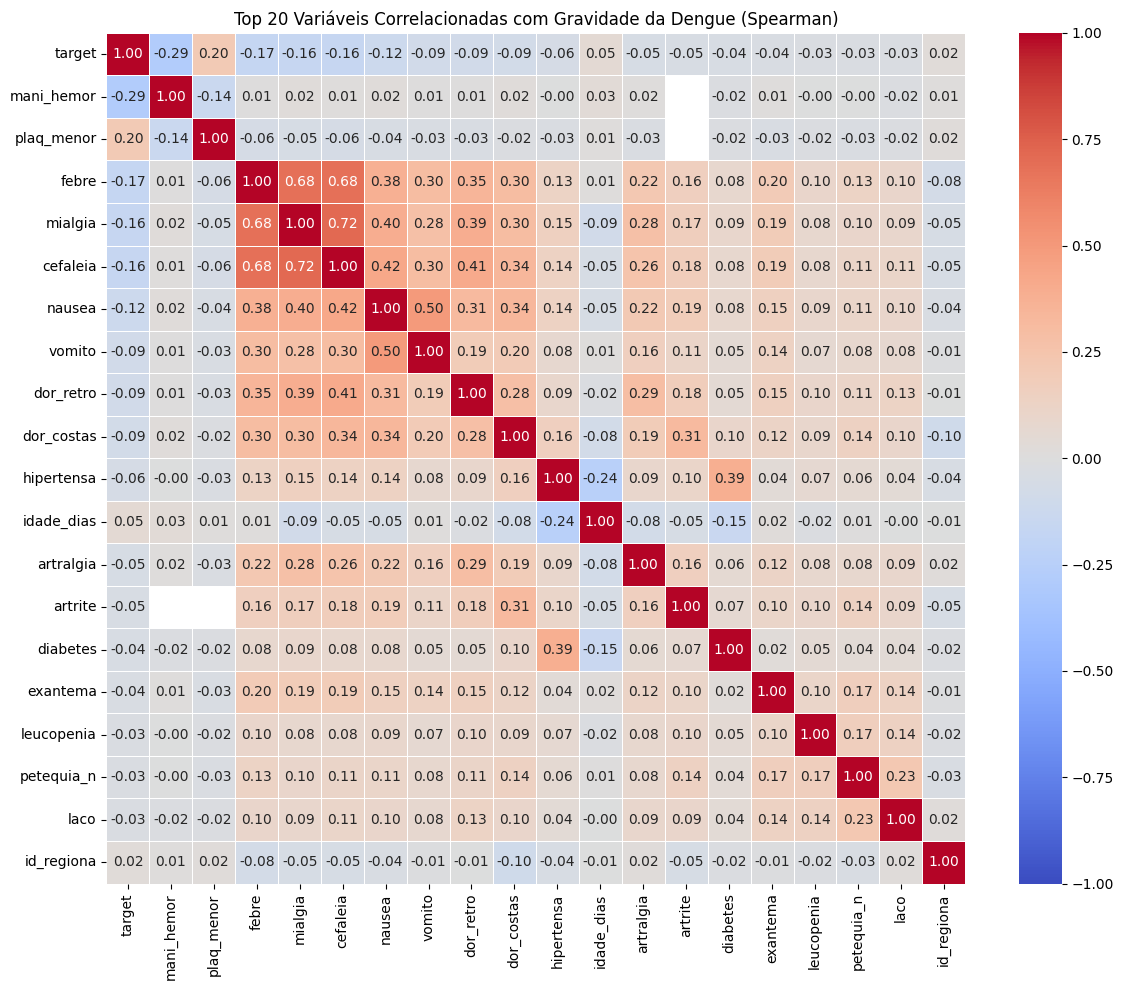

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

def analisar_correlacao(base_path, arquivo):
    caminho = os.path.join(base_path, arquivo)

    # Carrega dados
    df = pd.read_csv(caminho, sep=',', encoding='latin1', low_memory=False)

    # Remove colunas que não são numéricas (se houver sobrado alguma string)
    df_numerico = df.select_dtypes(include=[np.number])

    print(f"Analisando correlação para {len(df_numerico.columns)} variáveis...")

    # --- CÁLCULO DA CORRELAÇÃO ---
    # Usamos SPEARMAN pois captura melhor relações não-lineares e funciona bem
    # com o Target Ordinal (0, 1, 2, 3) e variáveis binárias.
    corr_matrix = df_numerico.corr(method='spearman')

    # Foca na correlação com o TARGET (ordenado do mais forte para o mais fraco)
    corr_target = corr_matrix['target'].sort_values(ascending=False)

    print("\n--- TOP 10 CORRELAÇÕES POSITIVAS COM O TARGET ---")
    print(corr_target.head(10))

    print("\n--- TOP 10 CORRELAÇÕES NEGATIVAS COM O TARGET ---")
    print(corr_target.tail(10))

    # --- PLOT DO HEATMAP (Focado nas Top Features) ---
    # Seleciona as 20 variáveis mais correlacionadas (absolutas) para o gráfico não ficar ilegível
    top_cols = corr_matrix['target'].abs().sort_values(ascending=False).head(20).index
    top_corr = df_numerico[top_cols].corr(method='spearman')

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        top_corr,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        vmin=-1,
        vmax=1,
        linewidths=0.5
    )
    plt.title("Top 20 Variáveis Correlacionadas com Gravidade da Dengue (Spearman)")
    plt.tight_layout()
    plt.show() # Em notebook local use plt.show(), no colab ele já mostra

    return corr_target

if __name__ == "__main__":
    BASE_PATH = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"
    FILE_NAME = 'dataset_final_idade_dias.csv'

    correlacoes = analisar_correlacao(BASE_PATH, FILE_NAME)

#### Retiraríamos aqui variáveis de correlação alta (eu adotaria um limiar >=0.75, mas pelo heatmap não têm, então pulamos esta parte...)

#### Normalização de dados numéricos

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import joblib

def aplicar_standard_scaler(base_path, arquivo_entrada, arquivo_saida):
    caminho_entrada = os.path.join(base_path, arquivo_entrada)
    caminho_saida = os.path.join(base_path, arquivo_saida)

    print(f"Lendo '{arquivo_entrada}'...")
    if not os.path.exists(caminho_entrada):
        print("Erro: Arquivo de entrada não encontrado. Verifique se os passos anteriores rodaram.")
        return

    df = pd.read_csv(caminho_entrada, sep=',', encoding='latin1', low_memory=False)

    # --- 1. Definição das Colunas ---
    # Colunas contínuas que DEVEM ser normalizadas
    # Verifica qual nome da coluna de idade está presente
    col_idade = 'idade_dias' if 'idade_dias' in df.columns else 'idade_anos'
    cols_para_normalizar = [col_idade]

    # Filtra apenas as que existem no dataframe
    cols_existentes = [c for c in cols_para_normalizar if c in df.columns]

    print(f"Normalizando com StandardScaler: {cols_existentes}")

    # --- 2. Normalização ---
    scaler = StandardScaler()

    # Garante que não há NaNs antes de normalizar
    for col in cols_existentes:
        df[col] = df[col].fillna(df[col].median())

    df[cols_existentes] = scaler.fit_transform(df[cols_existentes])

    # --- 3. Tratamento da Regional (Resposta à sua pergunta) ---
    # Identifica a coluna de regional
    col_regional = 'id_regiona' if 'id_regiona' in df.columns else 'id_rg_resi'

    if col_regional in df.columns:
        # Garante que é inteiro (sem casas decimais)
        df[col_regional] = df[col_regional].fillna(-1).astype(int)

    # --- 4. Salvamento ---
    df.to_csv(caminho_saida, index=False)

    # Salva o scaler para usar depois (deploy)
    joblib.dump(scaler, os.path.join(base_path, 'scaler_standard.pkl'))

    print("\n--- Estatísticas Pós-Normalização (Média ~0, Std ~1) ---")
    print(df[cols_existentes].describe().loc[['mean', 'std', 'min', 'max']])
    print(f"\nArquivo final salvo em: {arquivo_saida}")

if __name__ == "__main__":
    BASE_PATH = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"
    # Ajuste o nome do arquivo de entrada conforme o que você gerou por último
    INPUT = 'dataset_final_idade_dias.csv'
    OUTPUT = 'dataset_final_desbalanceado.csv'

    aplicar_standard_scaler(BASE_PATH, INPUT, OUTPUT)

Lendo 'dataset_final_idade_dias.csv'...
Normalizando com StandardScaler: ['idade_dias']

--- Estatísticas Pós-Normalização (Média ~0, Std ~1) ---
        idade_dias
mean  5.224098e-16
std   1.000000e+00
min  -1.767418e+00
max   4.990267e+01

Arquivo final salvo em: dataset_final_desbalanceado.csv


#### Transformando 'cs_sexo' de string em int (one-hot code)

In [ ]:
import pandas as pd
import os

# --- CONFIGURAÇÕES DE CAMINHO ---
BASE_PATH = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"
INPUT_FILE = os.path.join(BASE_PATH, "dataset_final_desbalanceado.csv")
OUTPUT_FILE = os.path.join(BASE_PATH, "dataset_final_desbalanceado_encoded.csv")

print(f"📂 Lendo dataset: {INPUT_FILE}")

# Leitura (low_memory=False previne avisos de tipos mistos em arquivos grandes)
df = pd.read_csv(INPUT_FILE, low_memory=False)

print(f"   Shape inicial: {df.shape}")

# ---------------------------------------------------------
# ONE-HOT ENCODING: CS_SEXO
# ---------------------------------------------------------
if 'cs_sexo' in df.columns:
    print("⚙️ Processando One-Hot Encoding para 'cs_sexo'...")

    # 1. LIMPEZA PRÉVIA (Crucial para não gerar colunas lixo)
    # Preenche vazios com 'I' (Ignorado)
    df['cs_sexo'] = df['cs_sexo'].fillna('I')

    # Padroniza para Maiúsculo e remove espaços (Ex: ' m' vira 'M')
    df['cs_sexo'] = df['cs_sexo'].astype(str).str.upper().str.strip()

    # Garante que só existam as categorias esperadas (M, F, I).
    # Qualquer coisa diferente vira 'I'.
    validos = ['M', 'F', 'I']
    df.loc[~df['cs_sexo'].isin(validos), 'cs_sexo'] = 'I'

    # 2. GERAÇÃO DOS DUMMIES (0 ou 1)
    # dtype=int garante que será 0/1 e não False/True (economiza memória e é melhor pro XGBoost)
    dummies_sexo = pd.get_dummies(df['cs_sexo'], prefix='cs_sexo', dtype=int)

    # 3. CONCATENAÇÃO
    # Junta as novas colunas ao dataframe original
    df = pd.concat([df, dummies_sexo], axis=1)

    # 4. REMOÇÃO DA COLUNA ORIGINAL
    df.drop(columns=['cs_sexo'], inplace=True)

    print("✅ Encoding concluído! Colunas geradas:")
    print(dummies_sexo.columns.tolist())

    # Preview visual
    print("\nVisualização das novas colunas (Head):")
    cols_novas = [c for c in df.columns if 'cs_sexo_' in c]
    print(df[cols_novas].head())

else:
    print("⚠️ Coluna 'cs_sexo' não encontrada. Verifique se já foi processada.")

# ---------------------------------------------------------
# SALVAMENTO
# ---------------------------------------------------------
print(f"\n💾 Salvando novo dataset em: {OUTPUT_FILE}")
df.to_csv(OUTPUT_FILE, index=False)
print("✅ Concluído com sucesso!")

📂 Lendo dataset: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/dataset_final_desbalanceado.csv
   Shape inicial: (4634001, 32)
⚙️ Processando One-Hot Encoding para 'cs_sexo'...
✅ Encoding concluído! Colunas geradas:
['cs_sexo_F', 'cs_sexo_I', 'cs_sexo_M']

Visualização das novas colunas (Head):
   cs_sexo_F  cs_sexo_I  cs_sexo_M
0          0          0          1
1          1          0          0
2          1          0          0
3          0          0          1
4          1          0          0

💾 Salvando novo dataset em: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/dataset_final_desbalanceado_encoded.csv
✅ Concluído com sucesso!


## **Classificação <u>binária</u>**

### 🏥 **Classes Alvo**
O modelo deverá classificar cada amostra em uma das **2 categorias** (classificação binária) abaixo:

0.  🟢 **Não Dengue**
1.  🔴 **Dengue**

#### Transformando dataset multiclasse em binário

In [ ]:
import pandas as pd
import os

# --- CONFIGURAÇÕES ---
BASE_PATH = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"
INPUT_FILE = 'dataset_final_desbalanceado_encoded.csv'
OUTPUT_FILE = 'dataset_bin_desbalanceado.csv'  # Arquivo de saída

CAMINHO_ENTRADA = os.path.join(BASE_PATH, INPUT_FILE)
CAMINHO_SAIDA = os.path.join(BASE_PATH, OUTPUT_FILE)

# 1. Carregamento dos Dados
print(f"📂 Lendo {INPUT_FILE}...")
try:
    df = pd.read_csv(CAMINHO_ENTRADA, sep=',', encoding='latin1', low_memory=False)
except FileNotFoundError:
    print(f"❌ Erro: Arquivo de entrada não encontrado em {CAMINHO_ENTRADA}.")
    exit()

# 2. Binarização da Coluna 'target'
print("🔄 Transformando coluna 'target' em binário (0=Não Dengue, 1=Dengue)...")
df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)

# 3. Remoção da coluna id_rg_resi
if 'id_rg_resi' in df.columns:
    print("🗑️ Removendo coluna 'id_rg_resi'...")
    df = df.drop(columns=['id_rg_resi'])
else:
    print("⚠️ Atenção: Coluna 'id_rg_resi' não encontrada no dataset!")

# 4. Salvamento do Novo Dataset
print(f"💾 Salvando o novo dataset em {OUTPUT_FILE}...")

print("\n--- Novo Balanceamento (Target) ---")
print(df['target'].value_counts())

df.to_csv(CAMINHO_SAIDA, index=False)

print(f"\n✅ Concluído! Arquivo binarizado salvo em: {OUTPUT_FILE}")


📂 Lendo dataset_final_desbalanceado_encoded.csv...
🔄 Transformando coluna 'target' em binário (0=Não Dengue, 1=Dengue)...
⚠️ Atenção: Coluna 'id_rg_resi' não encontrada no dataset!
💾 Salvando o novo dataset em dataset_bin_desbalanceado.csv...

--- Novo Balanceamento (Target) ---
target
1    3840112
0     793889
Name: count, dtype: int64

✅ Concluído! Arquivo binarizado salvo em: dataset_bin_desbalanceado.csv


#### Verificando correlação de ***Spearman***

📂 Lendo dataset binarizado: dataset_bin_desbalanceado.csv...
🧮 Calculando matriz de correlação de Spearman para 34 variáveis...


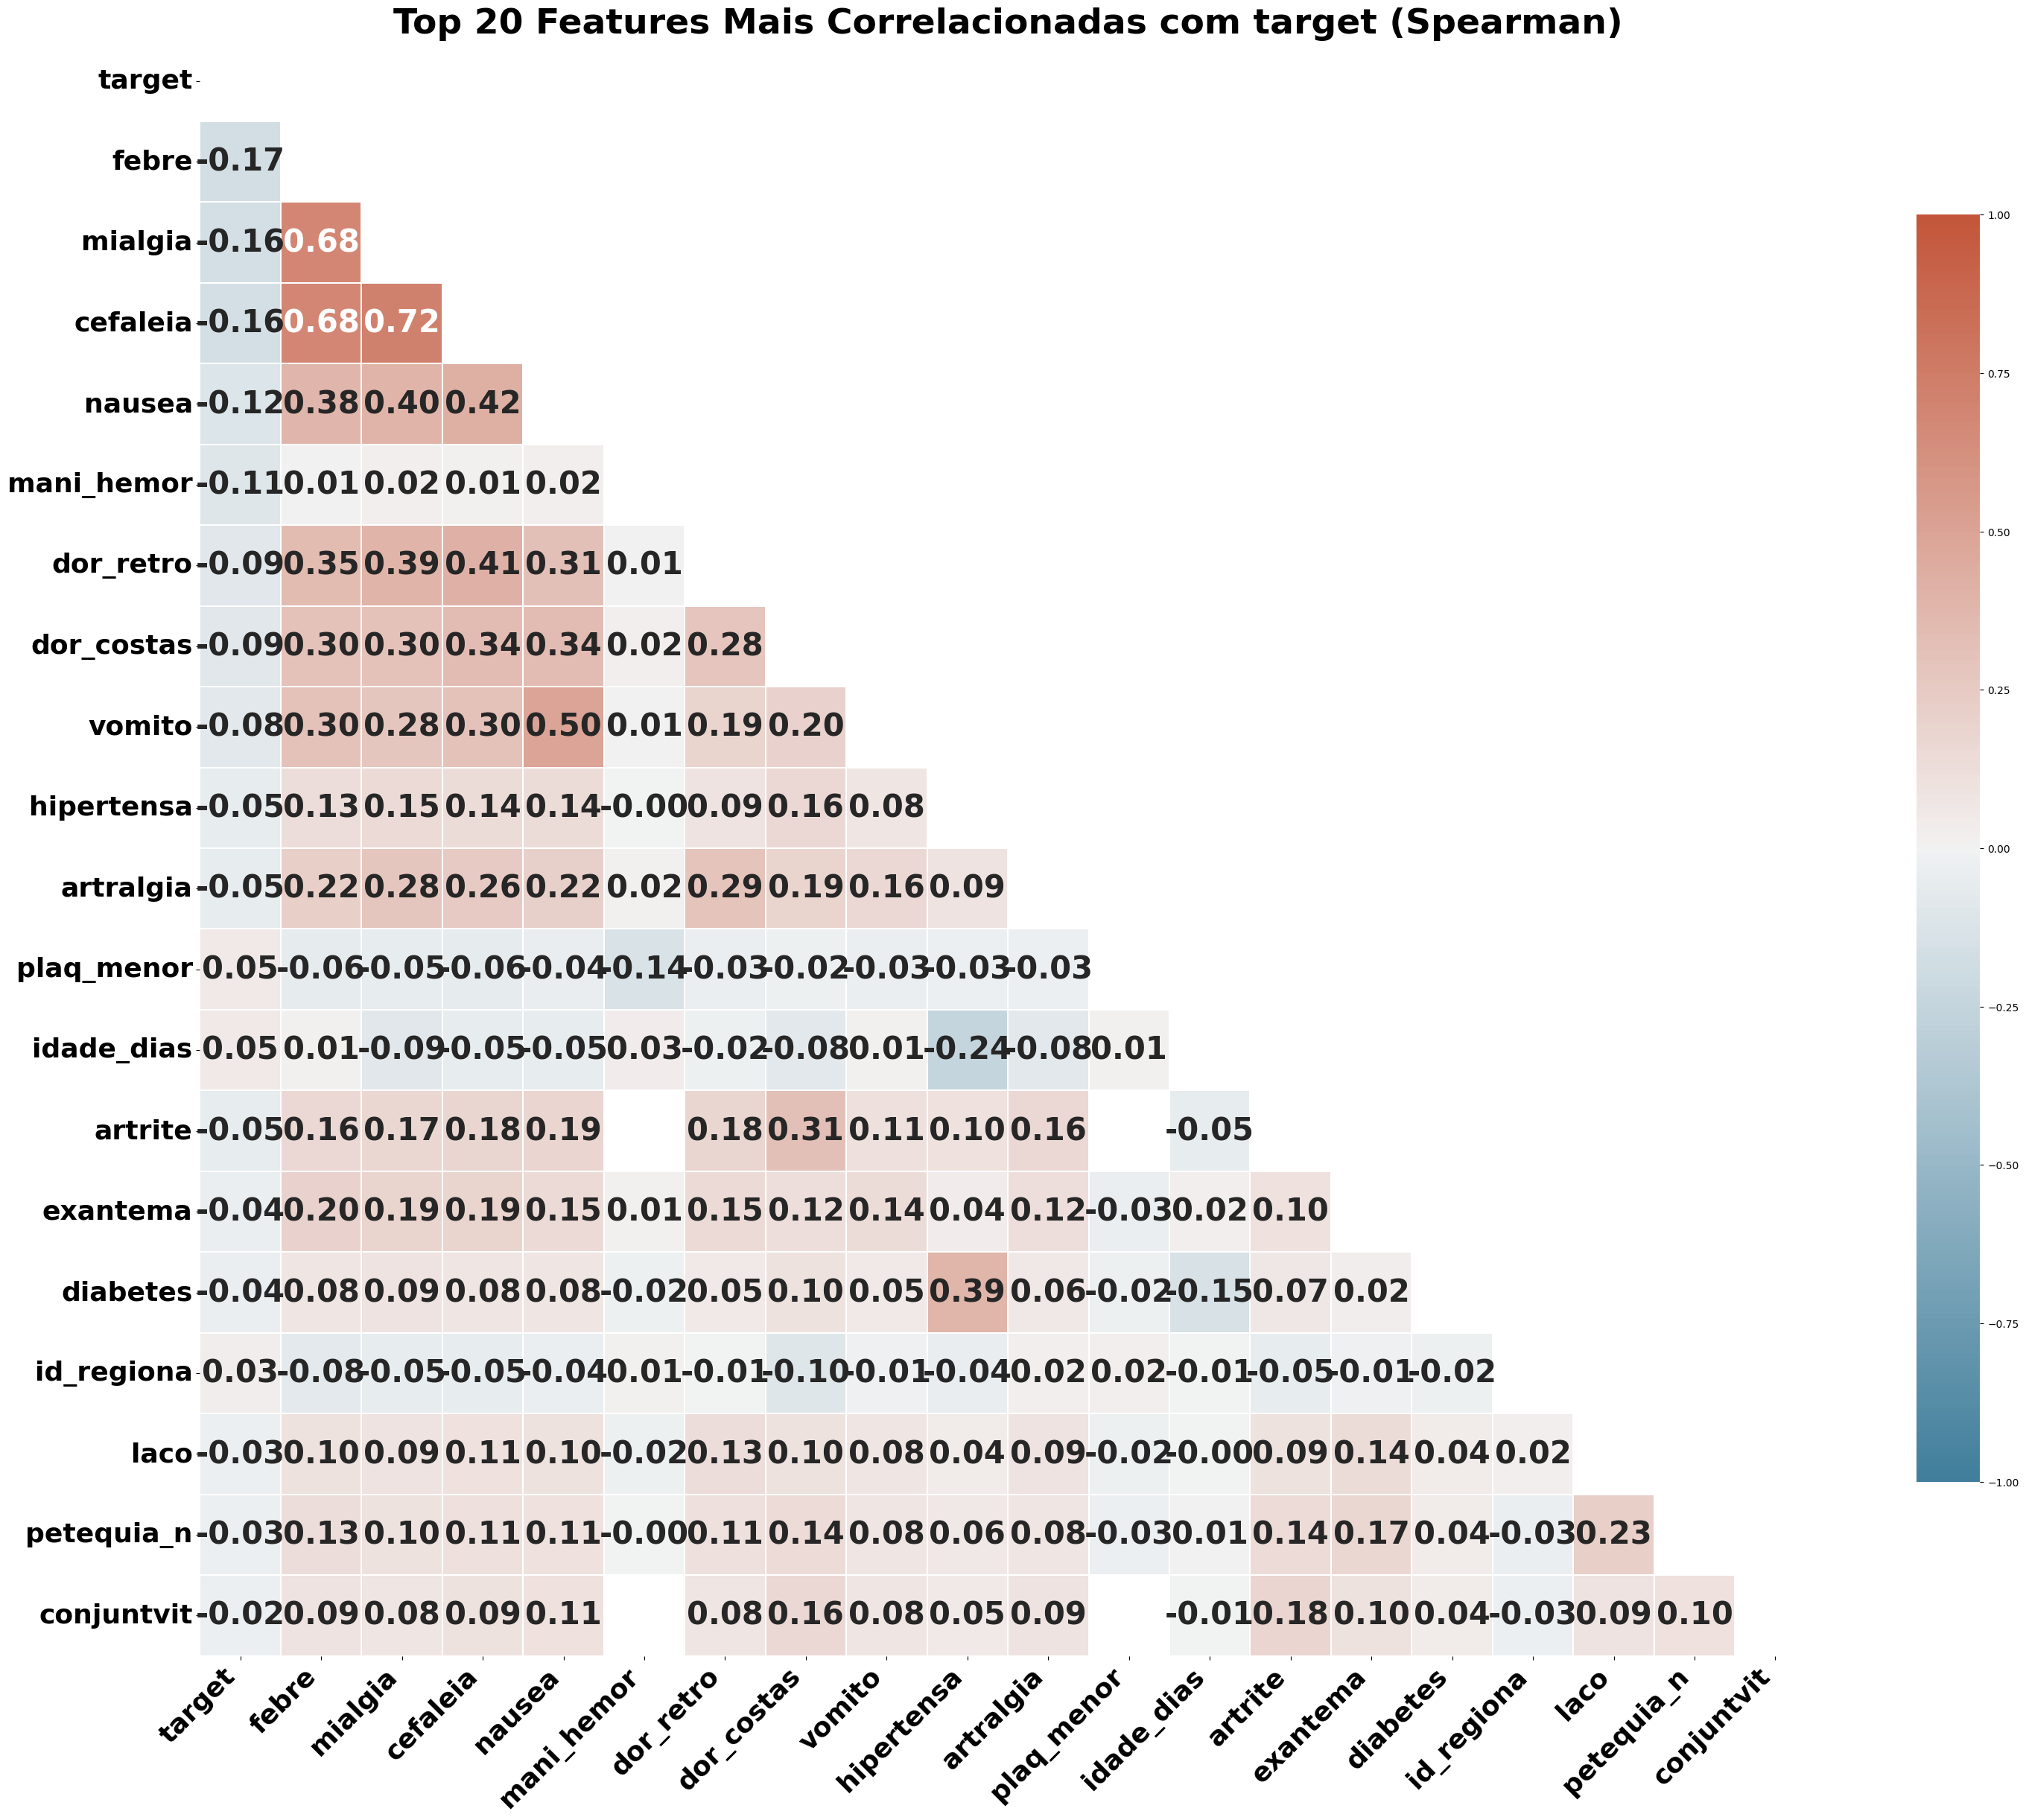

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

def analisar_correlacao_top20(base_path, arquivo_entrada):
    caminho = os.path.join(base_path, arquivo_entrada)

    # 1. Carregamento do Dataset
    print(f"📂 Lendo dataset binarizado: {arquivo_entrada}...")
    try:
        df = pd.read_csv(caminho, sep=',', encoding='latin1', low_memory=False)
    except FileNotFoundError:
        print(f"❌ Erro: O arquivo '{arquivo_entrada}' não foi encontrado. Verifique o caminho.")
        return

    # 2. Preparação dos Dados
    # Remove colunas que não são numéricas e garante o alvo
    df_numerico = df.select_dtypes(include=[np.number])
    target_col = 'target'

    if target_col not in df_numerico.columns:
        print(f"❌ Erro: Coluna alvo '{target_col}' não encontrada após a filtragem numérica.")
        return

    # 3. Cálculo da Correlação (Spearman)
    print(f"🧮 Calculando matriz de correlação de Spearman para {df_numerico.shape[1]} variáveis...")
    corr_matrix = df_numerico.corr(method='spearman')

    # 4. Seleção das TOP 20 Features
    # Pega o valor absoluto da correlação com o target, ordena, e seleciona as 20 melhores (+ o próprio target)
    corr_target_abs = corr_matrix[target_col].abs().sort_values(ascending=False)

    # Seleciona as 20 colunas de maior correlação (incluindo o target, que estará em 1º)
    top_cols = corr_target_abs.head(20).index

    # Recalcula a matriz apenas para as top features
    top_corr = df_numerico[top_cols].corr(method='spearman')

    # 5. Plotagem do Heatmap
    plt.figure(figsize=(30, 26))  # MUITO maior para slides

    mask = np.triu(np.ones_like(top_corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(
        top_corr,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        vmin=-1,
        vmax=1,
        center=0,
        square=True,
        linewidths=1.2,
        cbar_kws={"shrink": .7},
        annot_kws={"size": 30, "weight": "bold"}  # valores bem grandes e em bold
    )

    plt.title(
        f"Top 20 Features Mais Correlacionadas com {target_col} (Spearman)",
        fontsize=34,
        weight='bold'
    )
    plt.xticks(rotation=45, ha='right', fontsize=26, weight='bold')
    plt.yticks(rotation=0, fontsize=26, weight='bold')

    plt.tight_layout()



if __name__ == "__main__":
    BASE_PATH = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"
    INPUT_FILE = 'dataset_bin_desbalanceado.csv'

    analisar_correlacao_top20(BASE_PATH, INPUT_FILE)

#### Verificando distribuição binária

Lendo '/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/dataset_bin_desbalanceado.csv'...

--- Distribuição das Classes (Binário) ---
                Quantidade  Porcentagem (%)
target_binario                             
0                   793889        17.131826
1                  3840112        82.868174


/tmp/ipython-input-3959855304.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='target_binario', data=df, palette=['#1f77b4', '#d62728'])



Gráfico salvo em: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/distribuicao_classes_binaria.png


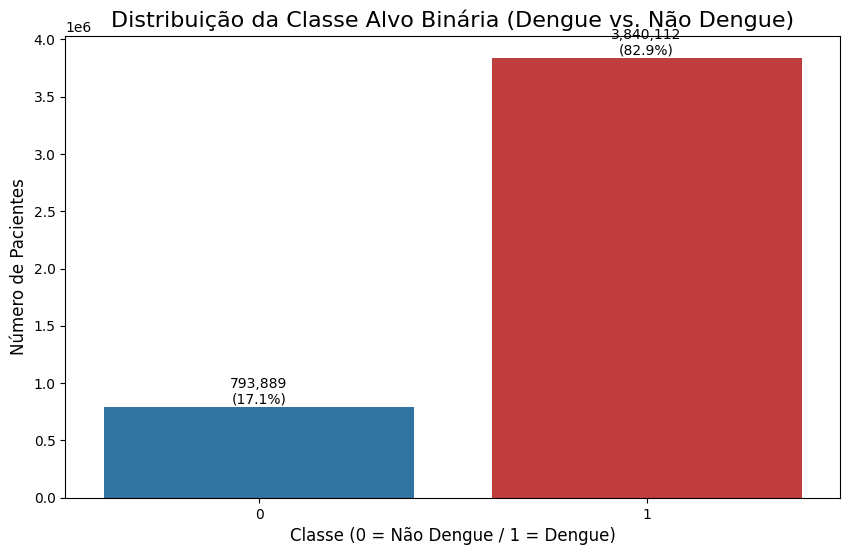

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plotar_distribuicao_binaria(base_path, arquivo_entrada):
    caminho = os.path.join(base_path, arquivo_entrada)

    # 1. Carregamento do Dataset
    if not os.path.exists(caminho):
        # Tenta o caminho alternativo que você indicou
        caminho_alt = os.path.join(base_path, 'dataset_final_standardized.csv')
        caminho = caminho_alt if os.path.exists(caminho_alt) else caminho

    try:
        print(f"Lendo '{caminho}'...")
        df = pd.read_csv(caminho, sep=',', encoding='latin1', low_memory=False)
    except FileNotFoundError:
        print("❌ Erro: Nenhum dataset encontrado. Verifique os passos anteriores.")
        return

    if 'target' not in df.columns:
        print("❌ Erro: Coluna 'target' não encontrada no dataset.")
        return

    # 0 -> 0 (Não Dengue)
    # 1, 2, 3 -> 1 (Dengue, em qualquer grau)
    df['target_binario'] = df['target'].apply(lambda x: 0 if x == 0 else 1)

    # Contagem e Percentual
    contagem = df['target_binario'].value_counts().sort_index()
    total = len(df)
    percentual = (contagem / total) * 100

    # Exibe tabela no console
    resumo = pd.concat([contagem, percentual], axis=1, keys=['Quantidade', 'Porcentagem (%)'])
    print("\n--- Distribuição das Classes (Binário) ---")
    print(resumo)

    # 3. Plotagem
    plt.figure(figsize=(10, 6))
    # Paleta de cores simples para binário
    ax = sns.countplot(x='target_binario', data=df, palette=['#1f77b4', '#d62728'])

    plt.title("Distribuição da Classe Alvo Binária (Dengue vs. Não Dengue)", fontsize=16)
    plt.xlabel("Classe (0 = Não Dengue / 1 = Dengue)", fontsize=12)
    plt.ylabel("Número de Pacientes", fontsize=12)

    # Adiciona rótulos de dados nas barras
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height):,}\n({height/total*100:.1f}%)',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black')

    # Salva a figura
    caminho_img = os.path.join(base_path, 'distribuicao_classes_binaria.png')
    print(f"\nGráfico salvo em: {caminho_img}")
    plt.show()

if __name__ == "__main__":
    BASE_PATH = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"
    INPUT_FILE = 'dataset_bin_desbalanceado.csv'

    plotar_distribuicao_binaria(BASE_PATH, INPUT_FILE)

#### Realizando balanceamento de classes + Separação Treino/Teste (80/20)

##### Fazendo **apenas *Random Under Sampling*** (proporção 1:2)

📂 Carregando dataset binarizado...

✂️ Dividindo em Treino (80%) e Teste (20%) Estratificado...

--- APLICANDO BALANCEAMENTO (APENAS TREINO) ---
Alvo Negativos (0): Mantido 635,111 amostras.
Alvo Positivos (1): Reduzido para 952,666 amostras (1:2).

⏳ Executando RUS...

✅ Balanceamento Concluído!
   Classe 0 (Neg): 635,111 (40.0%)
   Classe 1 (Pos): 952,666 (60.0%)

💾 Salvando dataset de treino e teste...
✅ Salvo Treino Balanceado (1:2): /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/dataset_train_rus.csv
✅ Salvo Teste (REAL): /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/dataset_test_rus.csv


/tmp/ipython-input-2247457431.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y_train_final, palette=['#1f77b4', '#d62728'])


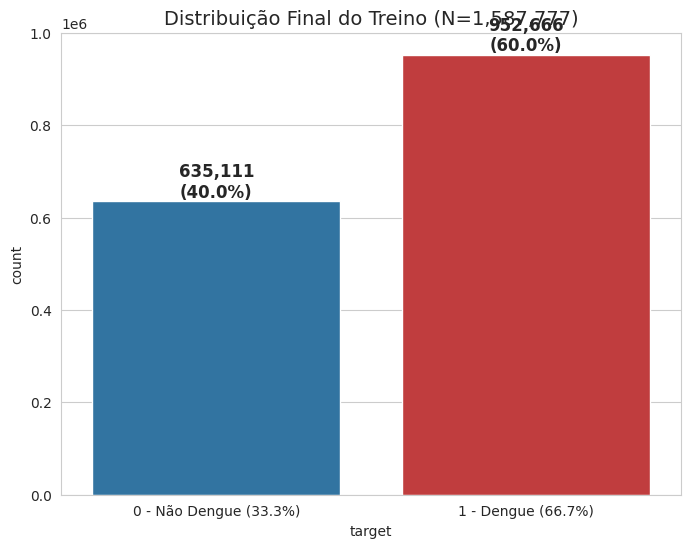

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline # Mantido apenas para organização, embora não usado diretamente

# --- CONFIGURAÇÕES ---
BASE_PATH = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"
ARQUIVO_ENTRADA = "dataset_bin_processado_sem_nulos.csv" # Usando o arquivo binarizado final
# Se você não salvou com esse nome na última vez, ajuste INPUT_FILE para "dataset_final_imbalance_weighted.csv"

# Configurar estilo dos gráficos
sns.set_style("whitegrid")

def preparar_datasets_final():
    print("📂 Carregando dataset binarizado...")
    path = os.path.join(BASE_PATH, ARQUIVO_ENTRADA)

    # Leitura otimizada
    df = pd.read_csv(path, sep=',', encoding='latin1', low_memory=False)

    # Limpeza básica (Garantindo que todos os NaNs numéricos foram preenchidos)
    cols_num = df.select_dtypes(include=[np.number]).columns
    df[cols_num] = df[cols_num].fillna(df[cols_num].median())

    # Mapeamento Binário (Garantido que o Target é 0 ou 1)
    # A coluna 'target' já está binarizada de 0/1 no arquivo INPUT_FILE
    y_bin = df['target'].astype(int)
    X = df.drop(columns=['target'])

    # =================================================================
    # 1️⃣ SPLIT ESTRATIFICADO
    # =================================================================
    print("\n✂️ Dividindo em Treino (80%) e Teste (20%) Estratificado...")
    # O STRATIFY garante que a proporção de 0s e 1s seja a mesma nos dois conjuntos.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_bin, test_size=0.2, stratify=y_bin, random_state=42
    )

    # =================================================================
    # 2️⃣ BALANCEAMENTO CONTROLADO (APENAS TREINO)
    # =================================================================
    print("\n--- APLICANDO BALANCEAMENTO (APENAS TREINO) ---")

    # Proporção 1:2 (1 parte Negativo : 2 partes Positivo)

    # Contagem da classe minoritária real no treino
    n_neg_real_train = (y_train == 0).sum()
    n_pos_real_train = (y_train == 1).sum()

    # Define o teto de amostras que serão mantidas/criadas
    # O Undersampling mantem n_neg_real_train integralmente.
    # A classe 1 (Positivo) será reduzida para 2x o valor da classe 0.
    n_pos_target_rus = int(n_neg_real_train * 1.5)

    print(f"Alvo Negativos (0): Mantido {n_neg_real_train:,} amostras.")
    print(f"Alvo Positivos (1): Reduzido para {n_pos_target_rus:,} amostras (1:2).")

    rus = RandomUnderSampler(
        sampling_strategy={0: n_neg_real_train, 1: n_pos_target_rus},
        random_state=42
    )

    print("\n⏳ Executando RUS...")
    X_train_final, y_train_final = rus.fit_resample(X_train, y_train)

    # Conferência Final
    count_0 = (y_train_final == 0).sum()
    count_1 = (y_train_final == 1).sum()
    total = len(y_train_final)

    print(f"\n✅ Balanceamento Concluído!")
    print(f"   Classe 0 (Neg): {count_0:,} ({count_0/total:.1%})")
    print(f"   Classe 1 (Pos): {count_1:,} ({count_1/total:.1%})")

    # =================================================================
    # 3️⃣ SALVAR ARQUIVOS FINAIS
    # =================================================================
    print("\n💾 Salvando dataset de treino e teste...")

    # 3.1 Salvar Treino (Balanceado)
    df_train_final = pd.concat([pd.DataFrame(X_train_final, columns=X.columns),
                                pd.Series(y_train_final, name='target')], axis=1)

    path_train = os.path.join(BASE_PATH, "dataset_train_rus.csv")
    df_train_final.to_csv(path_train, index=False)
    print(f"✅ Salvo Treino Balanceado (1:2): {path_train}")

    # 3.2 Salvar Teste (Imbalanced - Mantendo a realidade)
    df_test = pd.concat([X_test.reset_index(drop=True),
                         y_test.reset_index(drop=True).rename('target')], axis=1)
    path_test = os.path.join(BASE_PATH, "dataset_test_rus.csv")
    df_test.to_csv(path_test, index=False)
    print(f"✅ Salvo Teste (REAL): {path_test}")

    # =================================================================
    # 4️⃣ PLOTAGEM DE CONFERÊNCIA
    # =================================================================
    plt.figure(figsize=(8, 6))
    # Paleta de cores para contrastar as classes
    ax = sns.countplot(x=y_train_final, palette=['#1f77b4', '#d62728'])
    plt.title(f"Distribuição Final do Treino (N={total:,})", fontsize=14)
    plt.xticks([0, 1], ['0 - Não Dengue (33.3%)', '1 - Dengue (66.7%)'])

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height):,}\n({height/total:.1%})',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.show()

if __name__ == "__main__":
    preparar_datasets_final()

##### ***OBS.: NÃO RODE ESSA CÉLULA, DEMORA MUITO SE NÃO COLOCADA NUMA MÁQUINA POTENTE, <u>USANDO ENN NUM DATASET GRANDE!</u>***
🔸Código executado na *PROC1* do *MaVILab*

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import EditedNearestNeighbours # Importação do ENN
from imblearn.pipeline import Pipeline # Mantido para referência

# --- CONFIGURAÇÕES ---
BASE_PATH = ""
ARQUIVO_ENTRADA = "dataset_bin_desbalanceado.csv" # Usando o arquivo binarizado final

# Configurar estilo dos gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 5)

def preparar_dados_rus_enn():
    print("📂 Carregando dataset binarizado...")
    path = os.path.join(BASE_PATH, ARQUIVO_ENTRADA)

    # Leitura otimizada
    df = pd.read_csv(path, sep=',', encoding='latin1', low_memory=False)

    # Limpeza básica (Garantindo que NaNs numéricos foram preenchidos)
    cols_num = df.select_dtypes(include=[np.number]).columns
    df[cols_num] = df[cols_num].fillna(df[cols_num].median())

    # Target Binário (Garantido que está 0 ou 1)
    y_bin = df['target'].astype(int)
    X = df.drop(columns=['target'])

    # =================================================================
    # 1️⃣ SPLIT ESTRATIFICADO
    # =================================================================
    print("\n✂️ Dividindo em Treino (80%) e Teste (20%) Estratificado...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_bin, test_size=0.2, stratify=y_bin, random_state=42
    )

    # =================================================================
    # 2️⃣ BALANCEAMENTO CONTROLADO (RUS + ENN)
    # =================================================================
    print("\n--- APLICANDO BALANCEAMENTO (RUS 1:3 + ENN) ---")

    # Proporção Alvo: 40% Negativos : 60% Positivos (1:3)

    # Contagem da classe minoritária real no treino
    n_neg_real_train = (y_train == 0).sum()
    n_pos_real_train = (y_train == 1).sum()

    # ****************** CORREÇÃO AQUI ******************
    # 🎯 RUS: Reduz a classe 1 para ser 3x a classe 0, MANTENDO A CLASSE 0 INTEGRALMENTE.

    n_pos_target_rus = int(n_neg_real_train * 3)

    # Verificação de segurança (não exceder o real)
    if n_pos_target_rus > n_pos_real_train:
        n_pos_target_rus = n_pos_real_train

    print(f"🎯 Estratégia RUS:")
    print(f"   Alvo Negativos (0): Mantido {n_neg_real_train:,} amostras.")
    print(f"   Alvo Positivos (1): Reduzido para {n_pos_target_rus:,} amostras (1:1.5).")

    # 2.1 APLICANDO RUS
    rus = RandomUnderSampler(
        # Classe 0 é mantida, Classe 1 é reduzida
        sampling_strategy={0: n_neg_real_train, 1: n_pos_target_rus},
        random_state=42
    )

    print("\n⏳ Executando RUS...")
    X_rus, y_rus = rus.fit_resample(X_train, y_train)

    # 2.2 APLICANDO ENN (Filtro de Ruído)
    print("⏳ Executando ENN (Filtro de Ruído)...")
    # O ENN remove vizinhos que são de classes diferentes, limpando a fronteira de decisão.
    enn = EditedNearestNeighbours(kind_sel='all', n_neighbors=3)
    X_final, y_final = enn.fit_resample(X_rus, y_rus)

    # Conferência Final
    count_0 = (y_final == 0).sum()
    count_1 = (y_final == 1).sum()
    total = len(y_final)

    print(f"\n✅ Balanceamento Híbrido Concluído!")
    print(f"   Classe 0 (Neg): {count_0:,} ({count_0/total:.1%}) - (Parte removida pelo ENN)")
    print(f"   Classe 1 (Pos): {count_1:,} ({count_1/total:.1%})")

    # =================================================================
    # 3️⃣ SALVAR ARQUIVOS
    # =================================================================
    print("\n💾 Salvando dataset de treino corrigido...")

    # Salvar Treino (Balanceado + Limpo)
    df_train_final = pd.concat([pd.DataFrame(X_final, columns=X.columns),
                                pd.Series(y_final, name='target')], axis=1)

    path_train = os.path.join(BASE_PATH, "dataset_train_rus_enn.csv")
    df_train_final.to_csv(path_train, index=False)
    print(f"✅ Salvo Treino Híbrido (Limpado por ENN): {path_train}")

    # Salvar Teste (Imbalanced - Mantendo a realidade)
    df_test = pd.concat([X_test.reset_index(drop=True),
                         y_test.reset_index(drop=True).rename('target')], axis=1)
    path_test = os.path.join(BASE_PATH, "dataset_test_rus_enn.csv")
    df_test.to_csv(path_test, index=False)
    print(f"✅ Salvo Teste (REAL): {path_test}")

    # =================================================================
    # 4️⃣ PLOTAGEM DE CONFERÊNCIA
    # =================================================================
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x=y_final, palette=['#1f77b4', '#d62728'])
    plt.title(f"Distribuição Final do Treino (RUS + ENN)\nTotal N={total:,}", fontsize=14)
    plt.xticks([0, 1], ['0 - Não Dengue', '1 - Dengue'])

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height):,}\n({height/total:.1%})',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.show()

if __name__ == "__main__":
    preparar_dados_rus_enn()


📂 Carregando dataset binarizado...


FileNotFoundError: [Errno 2] No such file or directory: 'dataset_bin_desbalanceado.csv'

#### Limpando dados que agora não são mais úteis:

In [ ]:
from googleapiclient.discovery import build
from google.colab import auth
import os

auth.authenticate_user()
service = build('drive', 'v3')


path = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data/"

nomes = [
    'dataset_2007_2025.csv',
    'dataset_2007_2025_sem_leakage.csv',
    'dataset_final_com_features.csv',
    'dataset_final_idade_dias.csv'  # Corrigi extensão para .csv — ajuste se necessário!
]

def delete_permanently(filename):
    # Consulta pelo nome do arquivo no Drive
    results = service.files().list(
        q=f"name = '{filename}'",
        fields="files(id, name)"
    ).execute()

    files = results.get('files', [])

    if not files:
        print(f"Não encontrado: {filename}")
        return

    for f in files:
        file_id = f["id"]
        print(f"🔥 Excluindo DEFINITIVAMENTE: {filename}")
        service.files().delete(fileId=file_id).execute()

for nome in nomes:
    delete_permanently(nome)


🔥 Excluindo DEFINITIVAMENTE: dataset_2007_2025.csv
🔥 Excluindo DEFINITIVAMENTE: dataset_2007_2025_limpo_sem_leakage.csv
🔥 Excluindo DEFINITIVAMENTE: dataset_final_com_features.csv
🔥 Excluindo DEFINITIVAMENTE: dataset_final_idade_dias.csv


#### Nova distribuição dos dados após reamostragem

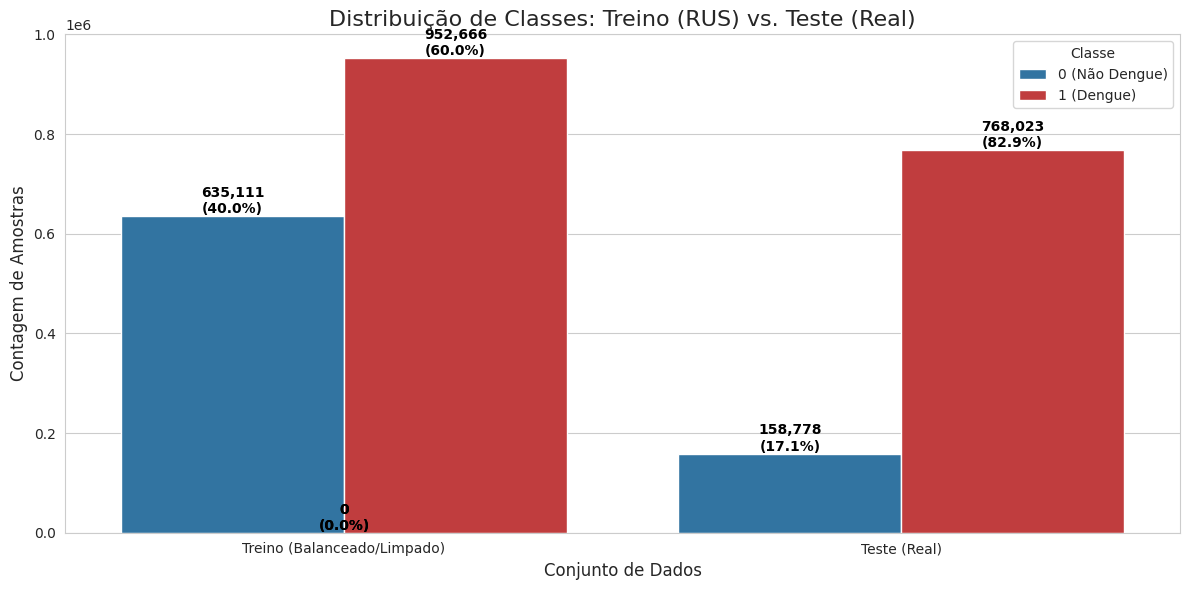

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plotar_distribuicao_comparativa(base_path, train_file, test_file):

    path_train = os.path.join(base_path, train_file)
    path_test = os.path.join(base_path, test_file)

    # 1. Carregamento dos Datasets
    try:
        df_train = pd.read_csv(path_train, sep=',', encoding='latin1', low_memory=False)
        df_test = pd.read_csv(path_test, sep=',', encoding='latin1', low_memory=False)
    except FileNotFoundError as e:
        print(f"❌ Erro ao carregar arquivo: {e}")
        return

    # 2. Reorganização dos Dados para Plotagem
    # Assumimos que o target já se chama 'target' e é binário (0/1)

    # Adiciona uma coluna de identificação
    df_train['Conjunto'] = 'Treino (Balanceado/Limpado)'
    df_test['Conjunto'] = 'Teste (Real)'

    # Concatena para o gráfico
    df_combined = pd.concat([df_train[['target', 'Conjunto']], df_test[['target', 'Conjunto']]], ignore_index=True)

    # 3. Plotagem
    plt.figure(figsize=(12, 6))

    ax = sns.countplot(
        x='Conjunto',
        hue='target',
        data=df_combined,
        palette=['#1f77b4', '#d62728'] # Azul para 0, Vermelho para 1
    )

    plt.title('Distribuição de Classes: Treino (RUS) vs. Teste (Real)', fontsize=16)
    plt.xlabel('Conjunto de Dados', fontsize=12)
    plt.ylabel('Contagem de Amostras', fontsize=12)
    plt.legend(title='Classe', labels=['0 (Não Dengue)', '1 (Dengue)'])

    # Adiciona rótulos de dados
    total_samples = len(df_combined)
    for p in ax.patches:
        height = p.get_height()
        # Calcula porcentagem dentro do seu próprio grupo (Treino ou Teste)
        if p.get_x() < 0.5: # Grupo Treino
             total_group = len(df_train)
        else: # Grupo Teste
             total_group = len(df_test)

        ax.annotate(f'{int(height):,}\n({height/total_group*100:.1f}%)',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

    plt.tight_layout()
    plt.show()

# --- EXECUÇÃO ---
if __name__ == "__main__":

    # --- CONFIGURAÇÕES ---
    BASE_PATH = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data"
    TRAIN_FILE = "dataset_train_rus.csv" # O arquivo final após RUS/ENN
    TEST_FILE = "dataset_test_rus.csv" # O arquivo de teste real
    plotar_distribuicao_comparativa(BASE_PATH, TRAIN_FILE, TEST_FILE)

#### Testando modelo base-line XGBoost

CUDA não está disponível.
🚀 XGBOOST: TREINO OTIMIZADO (Maximizando Recall c/ Spec Mínima)
📂 Lendo arquivos de treino: dataset_train_rus.csv e teste: dataset_test_rus.csv...
🔧 Tratando coluna 'cs_sexo' (M/F -> 0/1)...
✅ Dados Prontos! Features: 29

🤖 Treinando XGBoost (Mais complexo: Depth=9, Estimators=500)...

⚖️  Otimizando Threshold (Maximizando Recall (1) | Spec Mínima >= 60%)...

📋 RELATÓRIO DE MÉTRICAS AJUSTADO POR CRITÉRIO CLÍNICO
🎯 Threshold de Decisão: 0.5300 (Max. Recall c/ Spec >= 60%)
📈 AUC (Área sob ROC): 0.7213
| Métrica            |   Valor |
|:-------------------|--------:|
| Acurácia (Geral)   |  0.6887 |
| Precisão (0)       |  0.2985 |
| Recall (0)         |  0.6054 |
| F1-Score (0)       |  0.3999 |
| Precisão (1)       |  0.8964 |
| Recall (1)         |  0.7059 |
| F1-Score (1)       |  0.7898 |
| Especificidade (0) |  0.6054 |


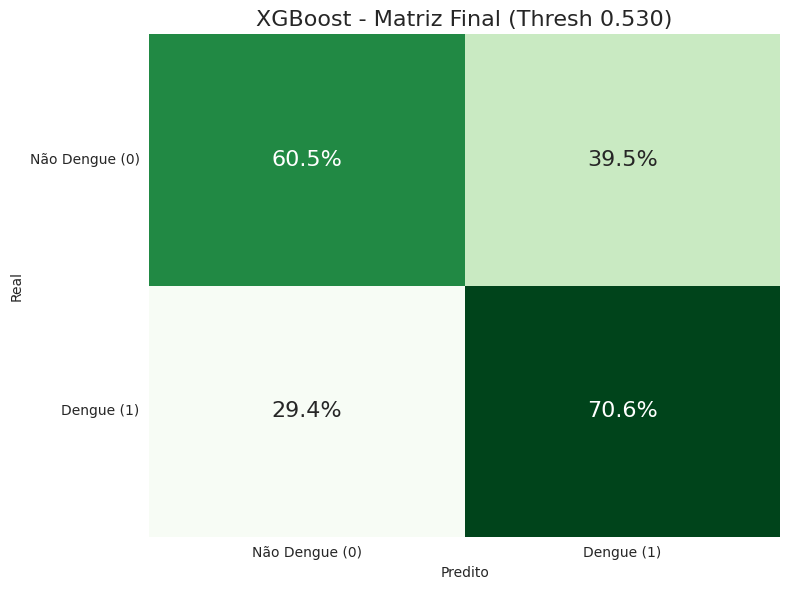


💾 Salvando Modelo...
✅ Modelo salvo em: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/models/xgboost_first.json
ℹ️  Threshold ideal para usar na API: 0.5300


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, classification_report
import torch

curr_device = 'cpu'
if torch.cuda.is_available():
    curr_device = 'cuda'
    print("CUDA está disponível!")
else:
    print("CUDA não está disponível.")

# --- CONFIGURAÇÕES ---
BASE_PATH = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/"
DATA_PATH = os.path.join(BASE_PATH, "data/")
MODELS_PATH = os.path.join(BASE_PATH, "models/")
os.makedirs(MODELS_PATH, exist_ok=True)

TRAIN_FILE = "dataset_train_rus.csv"
TEST_FILE = "dataset_test_rus.csv"

def run_xgboost():
    print("="*70)
    print("🚀 XGBOOST: TREINO OTIMIZADO (Maximizando Recall c/ Spec Mínima)")
    print("="*70)

    try:
        # 1. CARREGAMENTO
        print(f"📂 Lendo arquivos de treino: {TRAIN_FILE} e teste: {TEST_FILE}...")
        df_train = pd.read_csv(os.path.join(DATA_PATH, TRAIN_FILE))
        df_test = pd.read_csv(os.path.join(DATA_PATH, TEST_FILE))

        # -----------------------------------------------------------
        # 🛠️ CORREÇÃO DO ERRO (CS_SEXO: OBJECT -> INT)
        # -----------------------------------------------------------
        print("🔧 Tratando coluna 'cs_sexo' (M/F -> 0/1)...")

        # Função auxiliar definida dentro do escopo
        def tratar_sexo(df):
            if 'cs_sexo' in df.columns:
                # Garante que é string maiúscula e remove espaços
                df['cs_sexo'] = df['cs_sexo'].astype(str).str.upper().str.strip()

                # Mapeamento: M=1, F=2, I=9 (Padrão SINAN)
                mapa_sexo = {'M': 1, 'F': 2, 'I': 9}

                # Aplica o mapa. O que não for M ou F vira 9 (Ignorado)
                df['cs_sexo'] = df['cs_sexo'].map(mapa_sexo).fillna(9).astype(int)
            return df

        # APLICAÇÃO DA FUNÇÃO (INDENTAÇÃO CORRIGIDA AQUI)
        df_train = tratar_sexo(df_train)
        df_test = tratar_sexo(df_test)

        # Verificação de segurança para outras colunas object
        cols_obj = df_train.select_dtypes(include=['object']).columns
        if len(cols_obj) > 0:
            print(f"⚠️ AVISO: Ainda existem colunas OBJECT que o XGBoost vai rejeitar: {list(cols_obj)}")
            # Força conversão de tudo que sobrou para numérico (erro vira NaN, depois -1)
            for col in cols_obj:
                df_train[col] = pd.to_numeric(df_train[col], errors='coerce').fillna(-1)
                df_test[col] = pd.to_numeric(df_test[col], errors='coerce').fillna(-1)

        # -----------------------------------------------------------
        # DEFINIÇÃO DE X e Y
        # ATENÇÃO: Mantendo 'id_regiona' e removendo apenas o 'target'
        # -----------------------------------------------------------

        # Colunas a remover APENAS do X (features)
        cols_to_drop_training = ['target']

        # Se 'sem_pri' ainda existisse por algum motivo, removeríamos, mas você disse que não existe mais.
        # 'id_regiona' NÃO está na lista, então será usado no treino.

        X_train = df_train.drop(columns=cols_to_drop_training, errors='ignore')
        y_train = df_train['target']

        X_test = df_test.drop(columns=cols_to_drop_training, errors='ignore')
        y_test = df_test['target']

        print(f"✅ Dados Prontos! Features: {X_train.shape[1]}")

    except FileNotFoundError as e:
        print(f"❌ Erro: Arquivos não encontrados. Verifique paths: {e}")
        return

    # 2. TREINAMENTO (Hiperparâmetros MAIS PODEROSOS)
    print("\n🤖 Treinando XGBoost (Mais complexo: Depth=9, Estimators=500)...")
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=500,        # Aumentamos
        max_depth=9,             # Aumentamos complexidade
        learning_rate=0.08,      # Levemente mais agressivo
        gamma=0.1,               # Regularização
        scale_pos_weight=1.0,    # Já estamos usando dados balanceados (RUS), então 1.0 é ok
        eval_metric='auc',
        device=curr_device,
        random_state=42,
        n_jobs=-1,
        tree_method='hist'
    )

    model.fit(X_train, y_train, verbose=False)
    y_proba = model.predict_proba(X_test)[:, 1]

    # 3. OTIMIZAÇÃO DO THRESHOLD (MAXIMIZANDO RECALL(1) c/ SPEC MÍNIMA)
    print("\n⚖️  Otimizando Threshold (Maximizando Recall (1) | Spec Mínima >= 60%)...")

    thresholds = np.arange(0.0, 1.0, 0.005)
    best_recall_1 = -1
    best_thresh = 0.5
    SPEC_MINIMA = 0.60 # Exigência Clínica

    for t in thresholds:
        y_pred_temp = (y_proba >= t).astype(int)

        cm_temp = confusion_matrix(y_test, y_pred_temp)
        tn, fp, fn, tp = cm_temp.ravel()

        spec_temp = tn / (tn + fp) if (tn + fp) > 0 else 0
        rec_temp = tp / (tp + fn) if (tp + fn) > 0 else 0

        # Só aceita o threshold se a especificidade for >= 60%
        if spec_temp >= SPEC_MINIMA:
            if rec_temp > best_recall_1:
                best_recall_1 = rec_temp
                best_thresh = t

    # 4. AVALIAÇÃO FINAL
    y_pred_final = (y_proba >= best_thresh).astype(int)

    # Métricas para o Relatório
    report = classification_report(y_test, y_pred_final, target_names=['Não Dengue (0)', 'Dengue (1)'], output_dict=True, digits=4)
    cm_final = confusion_matrix(y_test, y_pred_final)

    # Cálculo da Especificidade (Spec) e Recall (Rec)
    tn, fp, fn, tp = cm_final.ravel()
    spec_final = tn / (tn + fp) if (tn + fp) > 0 else 0
    rec_final = tp / (tp + fn) if (tp + fn) > 0 else 0
    auc_final = roc_auc_score(y_test, y_proba)

    # --- RELATÓRIO DE MÉTRICAS (Tabela) ---
    print("\n" + "="*70)
    print("📋 RELATÓRIO DE MÉTRICAS AJUSTADO POR CRITÉRIO CLÍNICO")
    print(f"🎯 Threshold de Decisão: {best_thresh:.4f} (Max. Recall c/ Spec >= 60%)")
    print(f"📈 AUC (Área sob ROC): {auc_final:.4f}")
    print("="*70)

    resumo_metricas = pd.DataFrame({
        'Métrica': ['Acurácia (Geral)', 'Precisão (0)', 'Recall (0)', 'F1-Score (0)',
                    'Precisão (1)', 'Recall (1)', 'F1-Score (1)', 'Especificidade (0)'],
        'Valor': [
            report['accuracy'],
            report['Não Dengue (0)']['precision'],
            report['Não Dengue (0)']['recall'],
            report['Não Dengue (0)']['f1-score'],
            report['Dengue (1)']['precision'],
            report['Dengue (1)']['recall'],
            report['Dengue (1)']['f1-score'],
            spec_final
        ]
    })

    resumo_metricas['Valor'] = resumo_metricas['Valor'].apply(lambda x: f"{x:.4f}")
    print(resumo_metricas.to_markdown(index=False))
    print("="*70)

    # 5. PLOTAGEM 2x2 (Matriz de Confusão Final)
    cm_norm = cm_final.astype('float') / cm_final.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.1%', cmap='Greens', cbar=False, annot_kws={"size": 16})
    plt.title(f"XGBoost - Matriz Final (Thresh {best_thresh:.3f})", fontsize=16)
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.xticks([0.5, 1.5], ['Não Dengue (0)', 'Dengue (1)'])
    plt.yticks([0.5, 1.5], ['Não Dengue (0)', 'Dengue (1)'], rotation=0)

    plt.tight_layout()
    plt.show()

    # 6. SALVAMENTO
    print("\n💾 Salvando Modelo...")
    save_path = os.path.join(MODELS_PATH, "xgboost_first.json")
    model.save_model(save_path)
    print(f"✅ Modelo salvo em: {save_path}")
    print(f"ℹ️  Threshold ideal para usar na API: {best_thresh:.4f}")

if __name__ == "__main__":
    run_xgboost()

### LightGBM

CUDA não está disponível.
⚡ LIGHTGBM: TREINO OTIMIZADO (Maximizando Recall c/ Spec Mínima)

📂 Carregando Datasets...

🤖 Treinando LightGBM...
[LightGBM] [Info] Number of positive: 952666, number of negative: 635111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.369778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 1587777, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465

⚖️  Otimizando Threshold (Maximizando Recall (1) | Spec Mínima >= 60%)...

📋 RELATÓRIO DE MÉTRICAS AJUSTADO POR CRITÉRIO CLÍNICO
🎯 Threshold de Decisão: 0.5550 (Max. Recall c/ Spec >= 60%)
📈 AUC (Área sob ROC): 0.6629
| Métrica            |   Valor |
|:-------------------|--------:|
| Acurácia (Ge

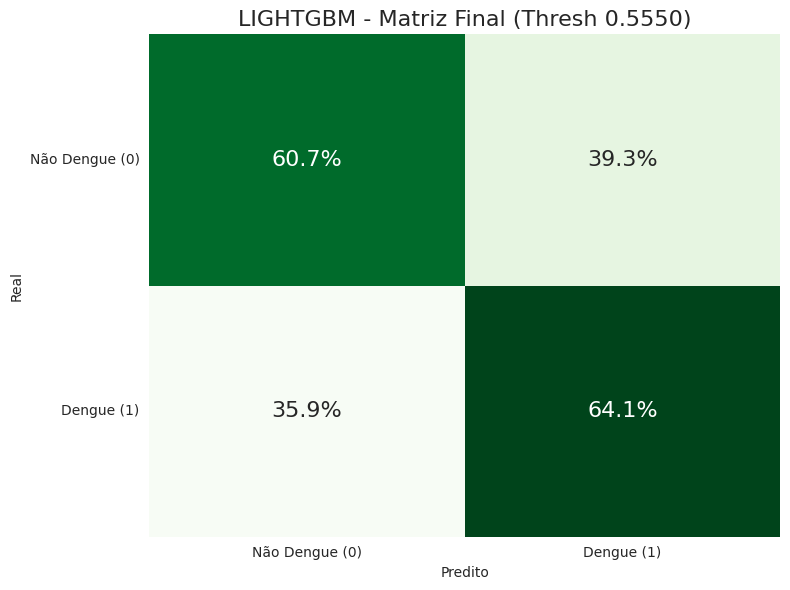


💾 Salvando Modelo...
✅ Modelo salvo em: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/models/lightgbm_first.txt
ℹ️  Threshold ideal para usar na API: 0.5550


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
import torch

curr_device = 'cpu'
if torch.cuda.is_available():
    curr_device = 'cuda'
    print("CUDA está disponível!")
else:
    print("CUDA não está disponível.")

# --- CONFIGURAÇÕES ---
BASE_PATH = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/"
DATA_PATH = os.path.join(BASE_PATH, "data/")
MODELS_PATH = os.path.join(BASE_PATH, "models/")
os.makedirs(MODELS_PATH, exist_ok=True)

TRAIN_FILE = "dataset_train_rus.csv"
TEST_FILE = "dataset_test_rus.csv"

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

def run_lgbm():
    print("="*70)
    print("⚡ LIGHTGBM: TREINO OTIMIZADO (Maximizando Recall c/ Spec Mínima)")
    print("="*70)

    print("\n📂 Carregando Datasets...")
    try:
        df_train = pd.read_csv(os.path.join(DATA_PATH, TRAIN_FILE))
        df_test = pd.read_csv(os.path.join(DATA_PATH, TEST_FILE))

        # Manter a remoção do 'sem_pri' se for relevante para este dataset
        # Caso contrário, usar apenas as colunas 'target'
        # Adicionei 'errors=ignore' para maior robustez
        X_train = df_train.drop(columns=['target', 'sem_pri', 'id_regiona'], errors='ignore')
        y_train = df_train['target']
        X_test = df_test.drop(columns=['target', 'sem_pri', 'id_regiona'], errors='ignore')
        y_test = df_test['target']

    except FileNotFoundError as e:
        print(f"❌ Erro: Arquivos não encontrados. Verifique paths: {e}")
        return

    print("\n🤖 Treinando LightGBM...")
    model = lgb.LGBMClassifier(
        objective='binary',
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        device = curr_device,
        random_state=42,
        n_jobs=-1
    )
    # Não há necessidade de eval_set aqui, pois a otimização de threshold é feita no X_test
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]

    auc_final = roc_auc_score(y_test, y_proba)


    # 🚨 NOVO BLOCO DE OTIMIZAÇÃO (PATTERN XGBOOST)
    print("\n⚖️  Otimizando Threshold (Maximizando Recall (1) | Spec Mínima >= 60%)...")

    thresholds = np.arange(0.0, 1.0, 0.005)
    best_recall_1 = -1
    best_thresh = 0.5 # Threshold inicial de fallback
    SPEC_MINIMA = 0.60 # Exigência Clínica

    for t in thresholds:
        y_pred_temp = (y_proba >= t).astype(int)

        cm_temp = confusion_matrix(y_test, y_pred_temp)
        # Atenção: ravel() retorna [tn, fp, fn, tp] no sklearn
        # A notação no código original estava incorreta/simplificada para especifidade/recall padrão
        # Garante-se a ordem correta aqui para robustez.
        tn, fp, fn, tp = cm_temp.ravel()

        # Especificidade (Spec - Classe 0)
        spec_temp = tn / (tn + fp) if (tn + fp) > 0 else 0
        # Recall (Rec - Classe 1)
        rec_temp = tp / (tp + fn) if (tp + fn) > 0 else 0

        # Critério: Se a especificidade é aceitável E o recall é melhor que o atual
        if spec_temp >= SPEC_MINIMA:
            if rec_temp > best_recall_1:
                best_recall_1 = rec_temp
                best_thresh = t

    # 4. AVALIAÇÃO FINAL COM O THRESHOLD OTIMIZADO
    y_pred_final = (y_proba >= best_thresh).astype(int)
    cm_final = confusion_matrix(y_test, y_pred_final)

    # Cálculo da Especificidade (Spec) e Recall (Rec) para o relatório
    tn, fp, fn, tp = cm_final.ravel()
    spec_final = tn / (tn + fp) if (tn + fp) > 0 else 0
    rec_final = tp / (tp + fn) if (tp + fn) > 0 else 0

    report = classification_report(y_test, y_pred_final, target_names=['Não Dengue (0)', 'Dengue (1)'], output_dict=True, digits=4)

    # --- RELATÓRIO DE MÉTRICAS (Tabela) ---
    print("\n" + "="*70)
    print("📋 RELATÓRIO DE MÉTRICAS AJUSTADO POR CRITÉRIO CLÍNICO")
    print(f"🎯 Threshold de Decisão: {best_thresh:.4f} (Max. Recall c/ Spec >= 60%)")
    print(f"📈 AUC (Área sob ROC): {auc_final:.4f}")
    print("="*70)

    resumo_metricas = pd.DataFrame({
        'Métrica': ['Acurácia (Geral)', 'Precisão (0)', 'Recall (0)', 'F1-Score (0)',
                    'Precisão (1)', 'Recall (1)', 'F1-Score (1)', 'Especificidade (0)'],
        'Valor': [
            report['accuracy'],
            report['Não Dengue (0)']['precision'],
            report['Não Dengue (0)']['recall'],
            report['Não Dengue (0)']['f1-score'],
            report['Dengue (1)']['precision'],
            report['Dengue (1)']['recall'],
            report['Dengue (1)']['f1-score'],
            spec_final
        ]
    })

    resumo_metricas['Valor'] = resumo_metricas['Valor'].apply(lambda x: f"{x:.4f}")
    print(resumo_metricas.to_markdown(index=False))
    print("="*70)

    # 5. PLOTAGEM (Matriz de Confusão Final Ajustada)
    print("\n📊 Gerando Gráfico da Matriz de Confusão Final...")
    cm_norm = cm_final.astype('float') / cm_final.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.1%', cmap='Greens', cbar=False, annot_kws={"size": 16})
    plt.title(f"LIGHTGBM - Matriz Final (Thresh {best_thresh:.4f})", fontsize=16)
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.xticks([0.5, 1.5], ['Não Dengue (0)', 'Dengue (1)'])
    plt.yticks([0.5, 1.5], ['Não Dengue (0)', 'Dengue (1)'], rotation=0)

    plt.tight_layout()
    plt.show()

    # 6. SALVAMENTO
    print("\n💾 Salvando Modelo...")
    save_path = os.path.join(MODELS_PATH, "lightgbm_first.txt")
    model.booster_.save_model(save_path)
    print(f"✅ Modelo salvo em: {save_path}")
    print(f"ℹ️  Threshold ideal para usar na API: {best_thresh:.4f}")

if __name__ == "__main__":
    run_lgbm()

### Random Forest

CUDA não está disponível.
🌲 RANDOM FOREST: TREINO OTIMIZADO (Maximizando Recall c/ Spec Mínima)

📂 Carregando Datasets...

🤖 Treinando Random Forest...

⚖️  Otimizando Threshold (Maximizando Recall (1) | Spec Mínima >= 60%)...

📋 RELATÓRIO DE MÉTRICAS AJUSTADO POR CRITÉRIO CLÍNICO
🎯 Threshold de Decisão: 0.5500 (Max. Recall c/ Spec >= 60%)
📈 AUC (Área sob ROC): 0.6621
| Métrica            |   Valor |
|:-------------------|--------:|
| Acurácia (Geral)   |  0.6359 |
| Precisão (0)       |  0.2587 |
| Recall (0)         |  0.6031 |
| F1-Score (0)       |  0.362  |
| Precisão (1)       |  0.8868 |
| Recall (1)         |  0.6427 |
| F1-Score (1)       |  0.7452 |
| Especificidade (0) |  0.6031 |

📊 Gerando Gráfico da Matriz de Confusão Final...


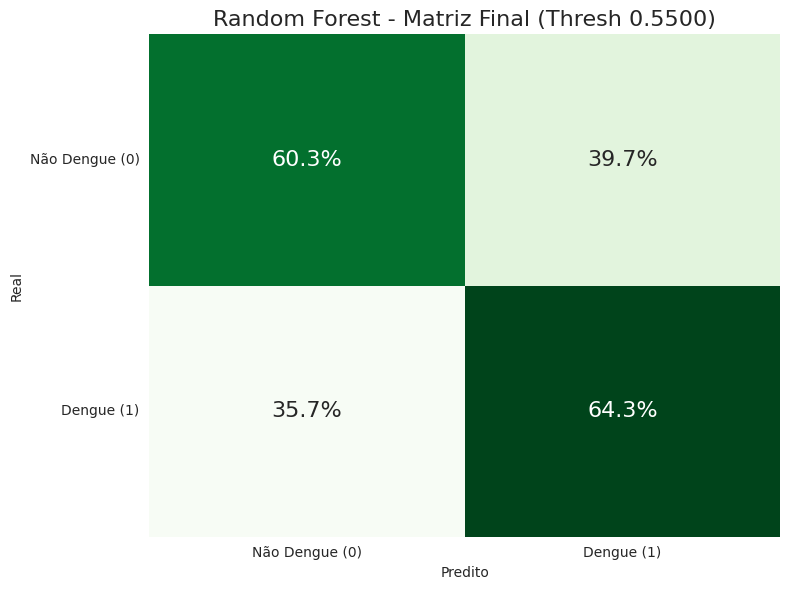


💾 Salvando Modelo...
✅ Modelo salvo em: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/models/random_first.joblib
ℹ️  Threshold ideal para usar na API: 0.5500


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib # Importante para salvar RF
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
import torch

curr_device = 'cpu'
if torch.cuda.is_available():
    # Nota: scikit-learn/RandomForest atualmente usa 'cuda' apenas para treinamento via Intel
    # O scikit-learn padrão no ambiente Colab/Jupyter geralmente executa em CPU, mesmo que 'device' seja passado.
    # A variável 'curr_device' não terá efeito no RandomForest padrão, mas mantemos o código base.
    curr_device = 'cuda'
    print("CUDA está disponível!")
else:
    print("CUDA não está disponível.")

# --- CONFIGURAÇÕES ---
BASE_PATH = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/"
DATA_PATH = os.path.join(BASE_PATH, "data/")
MODELS_PATH = os.path.join(BASE_PATH, "models/")
os.makedirs(MODELS_PATH, exist_ok=True)

TRAIN_FILE = "dataset_train_rus.csv"
TEST_FILE = "dataset_test_rus.csv"

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

def run_rf():
    print("="*70)
    print("🌲 RANDOM FOREST: TREINO OTIMIZADO (Maximizando Recall c/ Spec Mínima)")
    print("="*70)

    print("\n📂 Carregando Datasets...")
    try:
        df_train = pd.read_csv(os.path.join(DATA_PATH, TRAIN_FILE))
        df_test = pd.read_csv(os.path.join(DATA_PATH, TEST_FILE))

        # Remoção do VÍCIO (Espelhando XGBoost/LightGBM)
        X_train = df_train.drop(columns=['target', 'sem_pri', 'id_regiona'], errors='ignore')
        y_train = df_train['target']
        X_test = df_test.drop(columns=['target', 'sem_pri', 'id_regiona'], errors='ignore')
        y_test = df_test['target']

    except FileNotFoundError as e:
        print(f"❌ Erro: Arquivos não encontrados. Verifique paths: {e}")
        return

    print("\n🤖 Treinando Random Forest...")
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        random_state=42,
        # O parâmetro 'device' não é padrão do sklearn, mantido por compatibilidade
        # device = curr_device,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]

    auc_final = roc_auc_score(y_test, y_proba)


    # 🚨 NOVO BLOCO DE OTIMIZAÇÃO (PATTERN XGBOOST)
    print("\n⚖️  Otimizando Threshold (Maximizando Recall (1) | Spec Mínima >= 60%)...")

    thresholds = np.arange(0.0, 1.0, 0.005)
    best_recall_1 = -1
    best_thresh = 0.5 # Threshold inicial de fallback
    SPEC_MINIMA = 0.60 # Exigência Clínica

    for t in thresholds:
        y_pred_temp = (y_proba >= t).astype(int)

        cm_temp = confusion_matrix(y_test, y_pred_temp)
        # Ordem de ravel(): [tn, fp, fn, tp]
        tn, fp, fn, tp = cm_temp.ravel()

        # Especificidade (Spec - Classe 0)
        spec_temp = tn / (tn + fp) if (tn + fp) > 0 else 0
        # Recall (Rec - Classe 1)
        rec_temp = tp / (tp + fn) if (tp + fn) > 0 else 0

        # Critério: Se a especificidade é aceitável E o recall é melhor que o atual
        if spec_temp >= SPEC_MINIMA:
            if rec_temp > best_recall_1:
                best_recall_1 = rec_temp
                best_thresh = t

    # 4. AVALIAÇÃO FINAL COM O THRESHOLD OTIMIZADO
    y_pred_final = (y_proba >= best_thresh).astype(int)
    cm_final = confusion_matrix(y_test, y_pred_final)

    # Cálculo da Especificidade (Spec) e Recall (Rec) para o relatório
    tn, fp, fn, tp = cm_final.ravel()
    spec_final = tn / (tn + fp) if (tn + fp) > 0 else 0
    rec_final = tp / (tp + fn) if (tp + fn) > 0 else 0

    report = classification_report(y_test, y_pred_final, target_names=['Não Dengue (0)', 'Dengue (1)'], output_dict=True, digits=4)

    # --- RELATÓRIO DE MÉTRICAS (Tabela) ---
    print("\n" + "="*70)
    print("📋 RELATÓRIO DE MÉTRICAS AJUSTADO POR CRITÉRIO CLÍNICO")
    print(f"🎯 Threshold de Decisão: {best_thresh:.4f} (Max. Recall c/ Spec >= 60%)")
    print(f"📈 AUC (Área sob ROC): {auc_final:.4f}")
    print("="*70)

    resumo_metricas = pd.DataFrame({
        'Métrica': ['Acurácia (Geral)', 'Precisão (0)', 'Recall (0)', 'F1-Score (0)',
                    'Precisão (1)', 'Recall (1)', 'F1-Score (1)', 'Especificidade (0)'],
        'Valor': [
            report['accuracy'],
            report['Não Dengue (0)']['precision'],
            report['Não Dengue (0)']['recall'],
            report['Não Dengue (0)']['f1-score'],
            report['Dengue (1)']['precision'],
            report['Dengue (1)']['recall'],
            report['Dengue (1)']['f1-score'],
            spec_final
        ]
    })

    resumo_metricas['Valor'] = resumo_metricas['Valor'].apply(lambda x: f"{x:.4f}")
    print(resumo_metricas.to_markdown(index=False))
    print("="*70)

    # 5. PLOTAGEM (Matriz de Confusão Final Ajustada)
    print("\n📊 Gerando Gráfico da Matriz de Confusão Final...")
    cm_norm = cm_final.astype('float') / cm_final.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.1%', cmap='Greens', cbar=False, annot_kws={"size": 16})
    plt.title(f"Random Forest - Matriz Final (Thresh {best_thresh:.4f})", fontsize=16)
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.xticks([0.5, 1.5], ['Não Dengue (0)', 'Dengue (1)'])
    plt.yticks([0.5, 1.5], ['Não Dengue (0)', 'Dengue (1)'], rotation=0)

    plt.tight_layout()
    plt.savefig(os.path.join(DATA_PATH, "random_forest_matriz_otimizada.png"))
    plt.show() #

    # 6. SALVAMENTO
    print("\n💾 Salvando Modelo...")
    # O Random Forest usa joblib para salvar o modelo
    save_path = os.path.join(MODELS_PATH, "random_first.joblib")
    joblib.dump(model, save_path)
    print(f"✅ Modelo salvo em: {save_path}")
    print(f"ℹ️  Threshold ideal para usar na API: {best_thresh:.4f}")

if __name__ == "__main__":
    run_rf()

### CatBoost

In [ ]:
!pip install catboost

CUDA não está disponível.
🐈 CATBOOST: TREINO OTIMIZADO (Maximizando Recall c/ Spec Mínima)

📂 Carregando Datasets...

🤖 Treinando CatBoost...

⚖️  Otimizando Threshold (Maximizando Recall (1) | Spec Mínima >= 60%)...

📋 RELATÓRIO DE MÉTRICAS AJUSTADO POR CRITÉRIO CLÍNICO (CatBoost)
🎯 Threshold de Decisão: 0.5550 (Max. Recall c/ Spec >= 60%)
📈 AUC (Área sob ROC): 0.6622
| Métrica            |   Valor |
|:-------------------|--------:|
| Acurácia (Geral)   |  0.6364 |
| Precisão (0)       |  0.2589 |
| Recall (0)         |  0.6027 |
| F1-Score (0)       |  0.3623 |
| Precisão (1)       |  0.8868 |
| Recall (1)         |  0.6434 |
| F1-Score (1)       |  0.7457 |
| Especificidade (0) |  0.6027 |

📊 Gerando Gráfico da Matriz de Confusão Final...


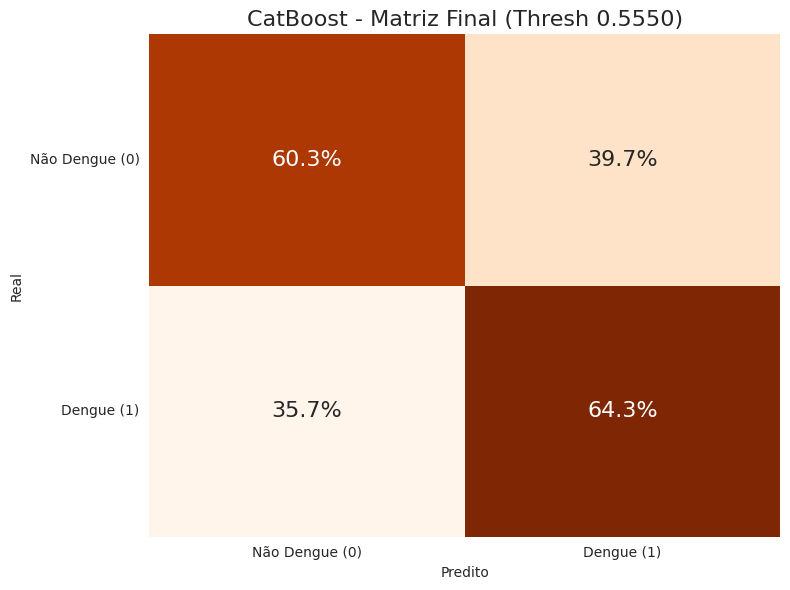


💾 Salvando Modelo...
✅ Modelo salvo em: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/models/catboost_first.cbm
ℹ️  Threshold ideal para usar na API: 0.5550


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

curr_device = 'cpu'
if torch.cuda.is_available():
    curr_device = 'cuda'
    print("CUDA está disponível!")
else:
    print("CUDA não está disponível.")

# --- CONFIGURAÇÕES --- #
BASE_PATH = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/"
DATA_PATH = os.path.join(BASE_PATH, "data/")
MODELS_PATH = os.path.join(BASE_PATH, "models/")
os.makedirs(MODELS_PATH, exist_ok=True)

# Definição dos arquivos de entrada
TRAIN_FILE = "dataset_train_rus.csv"
TEST_FILE = "dataset_test_rus.csv"
# Configurações visuais
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

def run_catboost():
    print("="*70)
    print("🐈 CATBOOST: TREINO OTIMIZADO (Maximizando Recall c/ Spec Mínima)")
    print("="*70)

    # 1. CARREGAMENTO
    print("\n📂 Carregando Datasets...")
    try:
        df_train = pd.read_csv(os.path.join(DATA_PATH, TRAIN_FILE))
        df_test = pd.read_csv(os.path.join(DATA_PATH, TEST_FILE))

        # Remoção do VÍCIO (Espelhando XGBoost/LightGBM)
        X_train = df_train.drop(columns=['target', 'sem_pri', 'id_regiona'], errors='ignore')
        y_train = df_train['target']
        X_test = df_test.drop(columns=['target', 'sem_pri', 'id_regiona'], errors='ignore')
        y_test = df_test['target']

    except FileNotFoundError as e:
        print(f"❌ Erro: Arquivos não encontrados em {DATA_PATH}. Detalhe: {e}")
        return

    # 2. IDENTIFICAR FEATURES CATEGÓRICAS (CRUCIAL PARA CATBOOST)
    # Lista de colunas que são objetos ou que têm poucos valores únicos (categóricas)
    # Remove colunas binárias já binarizadas (0/1) para evitar que o CatBoost as trate como Multi-Category
    categorical_features_indices = [
        col for col in X_train.columns if (X_train[col].dtype == 'object' or X_train[col].nunique() < 20)
        and X_train[col].nunique() > 2 # Ignora colunas binárias
    ]

    # Convertendo colunas categóricas para string para evitar erros no CatBoost
    for col in categorical_features_indices:
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)

    # 3. TREINAMENTO
    print("\n🤖 Treinando CatBoost...")
    model = CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='AUC',
        iterations=300,
        learning_rate=0.05,
        depth=6,
        random_seed=42,
        verbose=0, # Desativa o log de treino
        task_type="GPU" if torch.cuda.is_available() else "CPU",
        # Passa as colunas categóricas para o CatBoost
        cat_features=categorical_features_indices
    )

    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20, verbose=False)
    y_proba = model.predict_proba(X_test)[:, 1]

    auc_final = roc_auc_score(y_test, y_proba)

    # 4. OTIMIZAÇÃO DO THRESHOLD (MAXIMIZANDO RECALL(1) c/ SPEC MÍNIMA)
    print("\n⚖️  Otimizando Threshold (Maximizando Recall (1) | Spec Mínima >= 60%)...")

    thresholds = np.arange(0.0, 1.0, 0.005)
    best_recall_1 = -1
    best_thresh = 0.5 # Threshold inicial de fallback
    SPEC_MINIMA = 0.60 # Exigência Clínica

    for t in thresholds:
        y_pred_temp = (y_proba >= t).astype(int)

        cm_temp = confusion_matrix(y_test, y_pred_temp)
        # Ordem de ravel(): [tn, fp, fn, tp]
        tn, fp, fn, tp = cm_temp.ravel()

        # Especificidade (Spec - Classe 0)
        spec_temp = tn / (tn + fp) if (tn + fp) > 0 else 0
        # Recall (Rec - Classe 1)
        rec_temp = tp / (tp + fn) if (tp + fn) > 0 else 0

        # Critério: Se a especificidade é aceitável E o recall é melhor que o atual
        if spec_temp >= SPEC_MINIMA:
            if rec_temp > best_recall_1:
                best_recall_1 = rec_temp
                best_thresh = t

    # 5. AVALIAÇÃO FINAL COM O THRESHOLD OTIMIZADO
    y_pred_final = (y_proba >= best_thresh).astype(int)
    cm_final = confusion_matrix(y_test, y_pred_final)

    # Cálculo da Especificidade (Spec) e Recall (Rec) para o relatório
    tn, fp, fn, tp = cm_final.ravel()
    spec_final = tn / (tn + fp) if (tn + fp) > 0 else 0
    rec_final = tp / (tp + fn) if (tp + fn) > 0 else 0

    report = classification_report(y_test, y_pred_final, target_names=['Não Dengue (0)', 'Dengue (1)'], output_dict=True, digits=4)

    # --- RELATÓRIO DE MÉTRICAS (Tabela) ---
    print("\n" + "="*70)
    print("📋 RELATÓRIO DE MÉTRICAS AJUSTADO POR CRITÉRIO CLÍNICO (CatBoost)")
    print(f"🎯 Threshold de Decisão: {best_thresh:.4f} (Max. Recall c/ Spec >= 60%)")
    print(f"📈 AUC (Área sob ROC): {auc_final:.4f}")
    print("="*70)

    resumo_metricas = pd.DataFrame({
        'Métrica': ['Acurácia (Geral)', 'Precisão (0)', 'Recall (0)', 'F1-Score (0)',
                    'Precisão (1)', 'Recall (1)', 'F1-Score (1)', 'Especificidade (0)'],
        'Valor': [
            report['accuracy'],
            report['Não Dengue (0)']['precision'],
            report['Não Dengue (0)']['recall'],
            report['Não Dengue (0)']['f1-score'],
            report['Dengue (1)']['precision'],
            report['Dengue (1)']['recall'],
            report['Dengue (1)']['f1-score'],
            spec_final
        ]
    })

    resumo_metricas['Valor'] = resumo_metricas['Valor'].apply(lambda x: f"{x:.4f}")
    print(resumo_metricas.to_markdown(index=False))
    print("="*70)

    # 6. PLOTAGEM (Matriz de Confusão Final Ajustada)
    print("\n📊 Gerando Gráfico da Matriz de Confusão Final...")
    cm_norm = cm_final.astype('float') / cm_final.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.1%', cmap='Oranges', cbar=False, annot_kws={"size": 16})
    plt.title(f"CatBoost - Matriz Final (Thresh {best_thresh:.4f})", fontsize=16)
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.xticks([0.5, 1.5], ['Não Dengue (0)', 'Dengue (1)'])
    plt.yticks([0.5, 1.5], ['Não Dengue (0)', 'Dengue (1)'], rotation=0)

    plt.tight_layout()
    plt.show()

    # 7. SALVAMENTO
    print("\n💾 Salvando Modelo...")
    save_path = os.path.join(MODELS_PATH, "catboost_first.cbm")
    model.save_model(save_path)
    print(f"✅ Modelo salvo em: {save_path}")
    print(f"ℹ️  Threshold ideal para usar na API: {best_thresh:.4f}")

if __name__ == "__main__":
    run_catboost()

## Testando os 2 melhores modelos com <u>Busca Bayesiana</u> + <u>Validação Cruzada</u>

#### ⚔️ **XGBoost vs. LightGBM**

#### Instalações necessárias (para CatBoost e Busca Bayesiana)

In [ ]:
!pip install scikit-optimize
!pip install catboost

#### Configurações e paths...

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Configuração de Caminhos
BASE_PATH = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/data"
MODELS_PATH = os.path.join('/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD', "models/")
os.makedirs(MODELS_PATH, exist_ok=True)

# Configuração de Device (GPU)
curr_device = 'cpu'
if torch.cuda.is_available():
    curr_device = 'cuda'
    print("🚀 CUDA (GPU) disponível para modelos compatíveis!")
else:
    print("⚠️ CUDA não detectado. Usando CPU.")

⚠️ CUDA não detectado. Usando CPU.


### Treina os 2 modelos com cross validation + busca bayesiana + comparação teste ANOVA

* OBS.: otimizamos usando a área sob a curva ROC justamente porque se usassemos acurácia como é um dataset desbalanceado não seria um bom parâmetro, pois o modelo vai tender a chutar dados de outra classe como a classe majoritária

##### Definindo funções auxiliares e imports

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (roc_curve, auc, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score)
from scipy import stats
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import torch

def otimizar_threshold(y_true, y_proba):
    """Otimiza o threshold maximizando o Índice de Youden (J = TPR - FPR)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    roc_auc = auc(fpr, tpr)
    return optimal_threshold, roc_auc, fpr, tpr

def otimizar_e_coletar_scores(nome, model, params, X, y, X_test_local, y_test_local, cv):
    """Executa BayesSearchCV, salva o modelo e retorna métricas."""
    print(f"\n🔬 Otimizando {nome}...")

    opt = BayesSearchCV(
        estimator=model,
        search_spaces=params,
        n_iter=10,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    X_tune, _, y_tune, _ = train_test_split(X, y, train_size=0.2, stratify=y, random_state=42)
    opt.fit(X_tune, y_tune)

    best_index = opt.best_index_
    cv_results = opt.cv_results_
    scores_key = [k for k in cv_results.keys() if k.startswith('split') and k.endswith('_test_score')]
    cv_scores = [cv_results[key][best_index] for key in scores_key]

    print(f"✅ Melhores Params ({nome}): {opt.best_params_}")
    print(f"   AUC Média no CV: {opt.best_score_:.4f}")

    final_model = opt.best_estimator_

    filename = f"{nome}_otimizado.pkl"
    filepath = os.path.join(MODELS_PATH, filename)
    joblib.dump(final_model, filepath)
    print(f"💾 Modelo salvo em: {filepath}")

    print(f"🎯 Otimizando threshold para {nome}...")
    y_proba_test = final_model.predict_proba(X_test_local)[:, 1]
    optimal_threshold, test_auc, fpr, tpr = otimizar_threshold(y_test_local, y_proba_test)

    print(f"   Threshold Ótimo: {optimal_threshold:.4f} | AUC Teste: {test_auc:.4f}")

    return final_model, cv_scores, optimal_threshold, test_auc, fpr, tpr

def calcular_metricas_detalhadas(y_true, y_proba, threshold):
    """Calcula métricas detalhadas (Spec, Sens, F1) baseadas no threshold ótimo."""
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Métricas Classe 0 (Negativo)
    spec_0 = tn / (tn + fp) if (tn + fp) > 0 else 0 # True Negative Rate (Especificidade)
    prec_0 = tn / (tn + fn) if (tn + fn) > 0 else 0 # Predictive Value Negative
    f1_0 = 2 * (prec_0 * spec_0) / (prec_0 + spec_0) if (prec_0 + spec_0) > 0 else 0

    # Métricas Classe 1 (Positivo)
    sens_1 = tp / (tp + fn) if (tp + fn) > 0 else 0 # Recall / Sensitivity
    prec_1 = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1_1 = 2 * (prec_1 * sens_1) / (prec_1 + sens_1) if (prec_1 + sens_1) > 0 else 0

    # Médias (Macro)
    macro_f1 = (f1_0 + f1_1) / 2
    macro_recall = (spec_0 + sens_1) / 2
    acc = accuracy_score(y_true, y_pred)

    return {
        'Confusion Matrix': cm,
        'Accuracy': acc,
        'Macro F1': macro_f1,
        'Class 0 (Não Dengue)': {'Recall (Spec)': spec_0, 'Precision': prec_0, 'F1': f1_0},
        'Class 1 (Dengue)': {'Recall (Sens)': sens_1, 'Precision': prec_1, 'F1': f1_1}
    }


##### Splita os dados em folds (k=3) para Validação Cruzada

In [ ]:
# --- CARREGAMENTO DE DADOS --- #
print("📂 Carregando datasets...")
df_train = pd.read_csv(os.path.join(BASE_PATH, "dataset_train_rus.csv"))
X_train = df_train.drop(columns=['target'])
y_train = df_train['target']

df_test = pd.read_csv(os.path.join(BASE_PATH, "dataset_test_rus.csv"))
X_test = df_test.drop(columns=['target'])
y_test = df_test['target']

print(f"✅ Dados prontos: Treino {X_train.shape} | Teste {X_test.shape}")

cv_opt = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Inicializa dicionários
champions = {}
all_cv_scores = {}
optimal_thresholds = {}
test_aucs = {}
roc_data = {}

📂 Carregando datasets...
✅ Dados prontos: Treino (1587777, 29) | Teste (926801, 29)


##### Treinamento dos Modelos

In [ ]:
# --- TREINAMENTO - XGBOOST & LIGHTGBM --- #

# 1. XGBoost Params
xgb_params = {
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'max_depth': Integer(3, 8),
    'n_estimators': Integer(100, 300),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'min_child_weight': Integer(1, 10)
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    device=curr_device
)

champions['XGBoost'], all_cv_scores['XGBoost'], optimal_thresholds['XGBoost'], \
test_aucs['XGBoost'], roc_data['XGBoost_fpr'], roc_data['XGBoost_tpr'] = \
    otimizar_e_coletar_scores("XGBoost", xgb_model, xgb_params, X_train, y_train, X_test, y_test, cv_opt)

# 2. LightGBM Params
lgbm_params = {
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'num_leaves': Integer(20, 80),
    'n_estimators': Integer(100, 300),
    'min_child_samples': Integer(20, 100),
    'reg_alpha': Real(0, 1)
}

lgbm_model = lgb.LGBMClassifier(
    objective='binary',
    verbose=-1,
    n_jobs=-1,
    random_state=42,
    device='cpu' # LightGBM GPU no Colab às vezes requer recompilação, mantendo CPU para segurança
)

champions['LightGBM'], all_cv_scores['LightGBM'], optimal_thresholds['LightGBM'], \
test_aucs['LightGBM'], roc_data['LightGBM_fpr'], roc_data['LightGBM_tpr'] = \
    otimizar_e_coletar_scores("LightGBM", lgbm_model, lgbm_params, X_train, y_train, X_test, y_test, cv_opt)


🔬 Otimizando XGBoost...
✅ Melhores Params (XGBoost): OrderedDict({'colsample_bytree': 0.7640415835413256, 'learning_rate': 0.08846938749167613, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 234, 'subsample': 0.7656474529942154})
   AUC Média no CV: 0.7152
💾 Modelo salvo em: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/models/XGBoost_otimizado.pkl
🎯 Otimizando threshold para XGBoost...
   Threshold Ótimo: 0.6014 | AUC Teste: 0.7160

🔬 Otimizando LightGBM...
✅ Melhores Params (LightGBM): OrderedDict({'learning_rate': 0.10970919052074331, 'min_child_samples': 55, 'n_estimators': 205, 'num_leaves': 63, 'reg_alpha': 0.9038520725066866})
   AUC Média no CV: 0.7151
💾 Modelo salvo em: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/models/LightGBM_otimizado.pkl
🎯 Otimizando threshold para LightGBM...
   Threshold Ótimo: 0.6080 | AUC Teste: 0.7163


In [ ]:
# --- TREINAMENTO - CATBOOST & RANDOM FOREST --- #

# 3. CatBoost Params
cat_params = {
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'depth': Integer(4, 10),
    'l2_leaf_reg': Integer(1, 10),
    'iterations': Integer(100, 300)
}

cat_model = CatBoostClassifier(
    objective='Logloss',
    verbose=0,
    random_state=42,
    thread_count=-1,
    task_type="GPU" if curr_device == 'cuda' else "CPU"
)

champions['CatBoost'], all_cv_scores['CatBoost'], optimal_thresholds['CatBoost'], \
test_aucs['CatBoost'], roc_data['CatBoost_fpr'], roc_data['CatBoost_tpr'] = \
    otimizar_e_coletar_scores("CatBoost", cat_model, cat_params, X_train, y_train, X_test, y_test, cv_opt)

# 4. Logistic Regression
# Vantagem: Extremamente rápido e serve como baseline linear robusto
lr_params = {
    'C': Real(0.001, 10.0, prior='log-uniform'),  # Força da regularização
    'solver': Categorical(['liblinear', 'lbfgs']), # Algoritmos de otimização
    'class_weight': Categorical([None, 'balanced'])
}

# Nota: n_jobs=-1 funciona para alguns solvers, mas LR é tão rápido que nem sempre é crítico
lr_model = LogisticRegression(
    max_iter=1000, # Aumentar iterações para garantir convergência
    random_state=42
)

# Ajustando para usar o nome "LogisticRegression" nos dicionários
champions['LogisticRegression'], all_cv_scores['LogisticRegression'], \
optimal_thresholds['LogisticRegression'], test_aucs['LogisticRegression'], \
roc_data['LogisticRegression_fpr'], roc_data['LogisticRegression_tpr'] = \
    otimizar_e_coletar_scores("LogisticRegression", lr_model, lr_params, X_train, y_train, X_test, y_test, cv_opt)


🔬 Otimizando CatBoost...
✅ Melhores Params (CatBoost): OrderedDict({'depth': 8, 'iterations': 255, 'l2_leaf_reg': 4, 'learning_rate': 0.13725350231091818})
   AUC Média no CV: 0.7148
💾 Modelo salvo em: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/models/CatBoost_otimizado.pkl
🎯 Otimizando threshold para CatBoost...
   Threshold Ótimo: 0.5938 | AUC Teste: 0.7156

🔬 Otimizando LogisticRegression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Melhores Params (LogisticRegression): OrderedDict({'C': 1.7765766649807682, 'class_weight': None, 'solver': 'lbfgs'})
   AUC Média no CV: 0.6543
💾 Modelo salvo em: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/models/LogisticRegression_otimizado.pkl
🎯 Otimizando threshold para LogisticRegression...
   Threshold Ótimo: 0.5915 | AUC Teste: 0.6534


### Teste ***ANOVA*** (*LightGBM vs XGBoost vs CatBoost vs Random Forest*)

* Aqui comparamos com um teste estatístico para haver **relevância estatística**

In [ ]:
# --- ESTATÍSTICA (ANOVA) --- #

scores_list = list(all_cv_scores.values())
f_statistic, p_value = stats.f_oneway(*scores_list)

print("\n🔬 RESULTADOS DA ANOVA (Comparação de AUC entre 4 Modelos)")
print("="*80)

df_scores = pd.DataFrame(all_cv_scores)
print("\n📋 Pontuações de AUC por Fold:")
print(df_scores)
print("-" * 80)

print(f"Estatística F: {f_statistic:.4f}")
print(f"Valor P: {p_value:.4f}")

alpha = 0.05
print(f"\nInterpretação (α = {alpha}):")
if p_value < alpha:
    print("➡️ REJEITAMOS H₀: Há diferença estatisticamente significativa entre os modelos.")
else:
    print("➡️ NÃO REJEITAMOS H₀: Sem evidência de diferença significativa entre os modelos.")
print("="*80)


🔬 RESULTADOS DA ANOVA (Comparação de AUC entre 4 Modelos)

📋 Pontuações de AUC por Fold:
    XGBoost  LightGBM  CatBoost  LogisticRegression
0  0.713232  0.713756  0.713244            0.652189
1  0.717388  0.717227  0.716886            0.656315
2  0.714855  0.714421  0.714235            0.654538
--------------------------------------------------------------------------------
Estatística F: 707.6452
Valor P: 0.0000

Interpretação (α = 0.05):
➡️ REJEITAMOS H₀: Há diferença estatisticamente significativa entre os modelos.


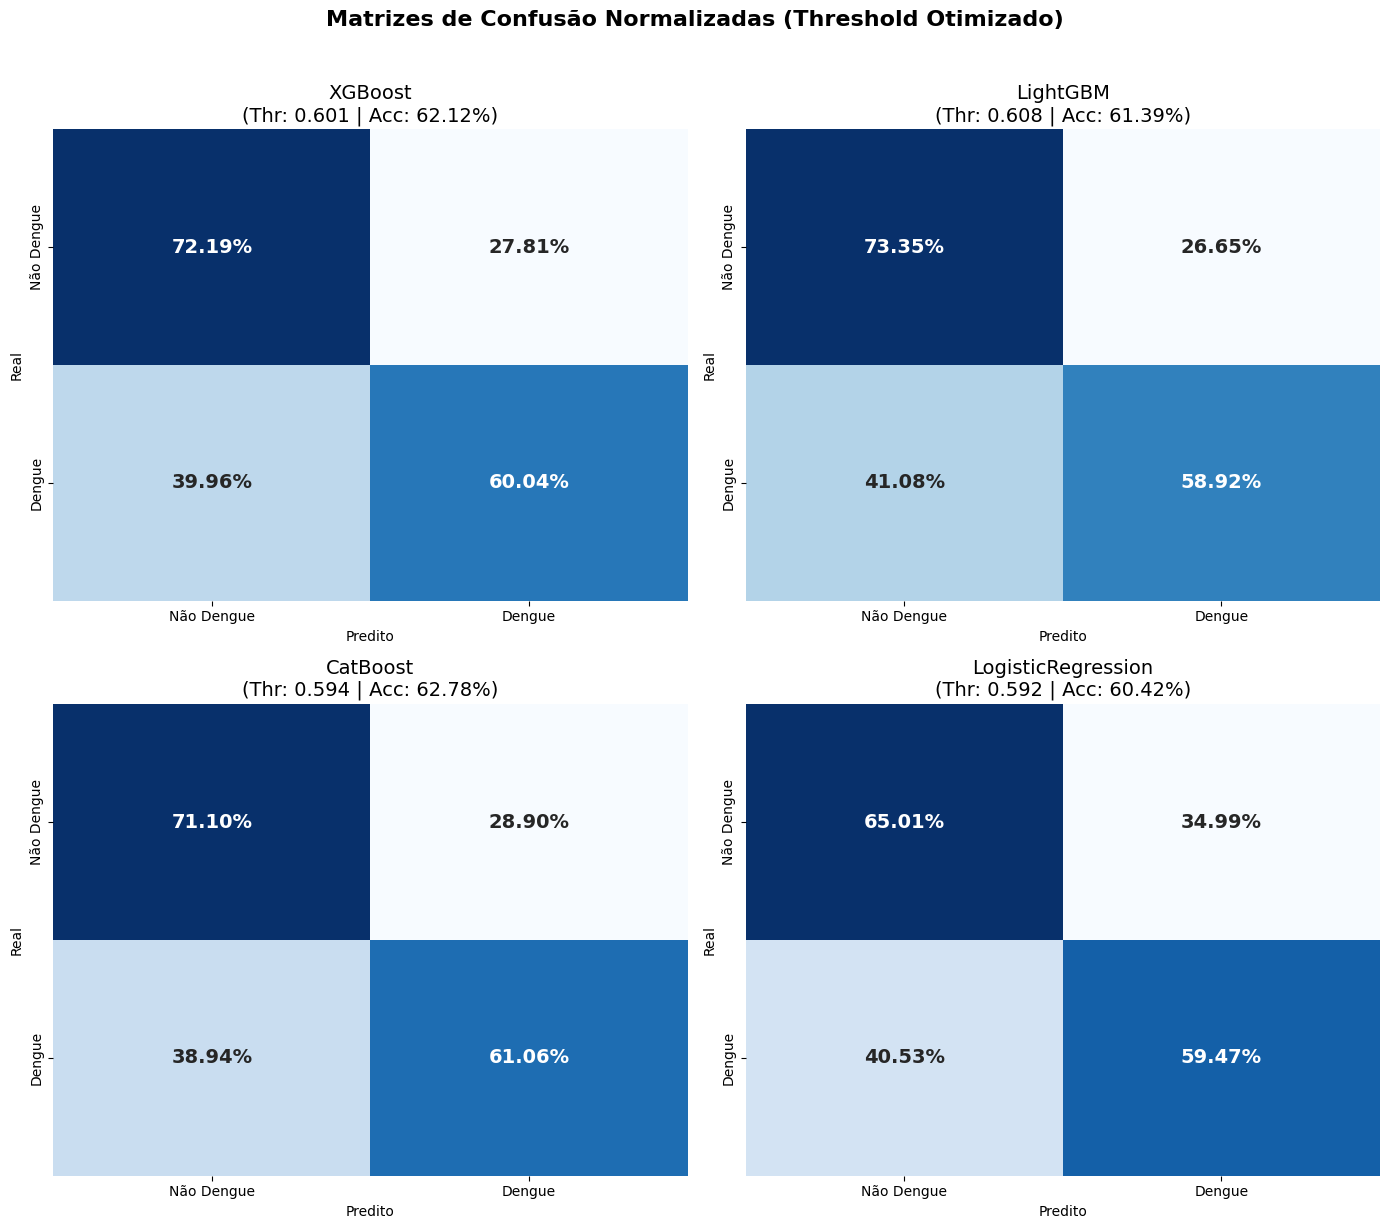


📋 TABELA DE PERFORMANCE DETALHADA (Teste)
                    Threshold    AUC  Acurácia  Macro F1  Rec (0/Spec)  \
Modelo                                                                   
XGBoost                0.6014 0.7160    0.6212    0.5597        0.7219   
LightGBM               0.6080 0.7163    0.6139    0.5555        0.7335   
CatBoost               0.5938 0.7156    0.6278    0.5634        0.7110   
LogisticRegression     0.5915 0.6534    0.6042    0.5368        0.6501   

                    F1 (0)  Rec (1/Sens)  F1 (1)  
Modelo                                            
XGBoost             0.3951        0.6004  0.7243  
LightGBM            0.3943        0.5892  0.7167  
CatBoost            0.3956        0.6106  0.7311  
LogisticRegression  0.3601        0.5947  0.7135  


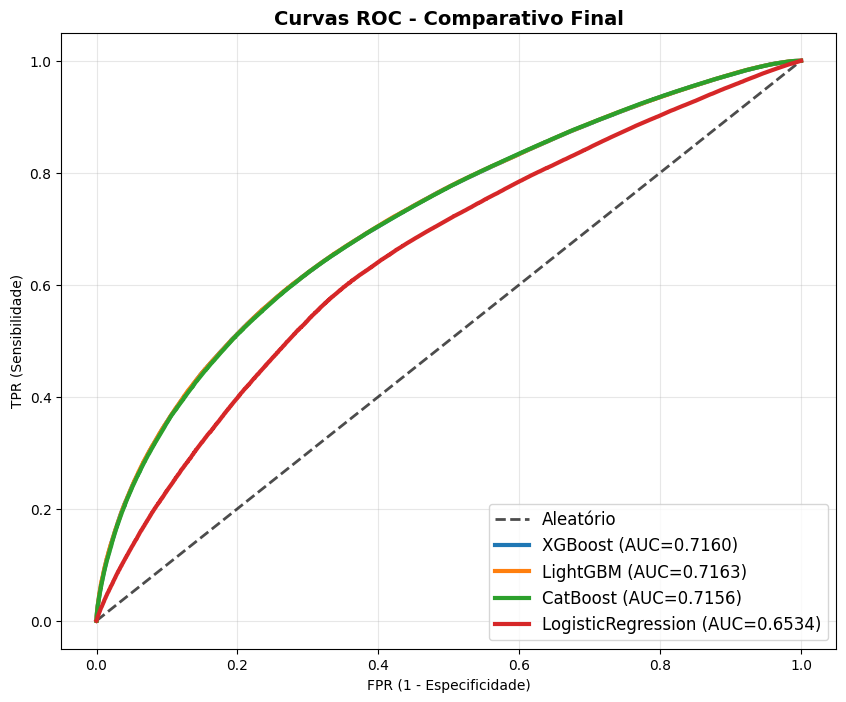


✅ Todos os artefatos salvos em: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/models/


In [ ]:
# -------------------------------------------------------------------------
# AVALIAÇÃO VISUAL E TABULAR DETALHADA
# -------------------------------------------------------------------------
model_names = list(champions.keys())
results_detailed = []

# Configuração do Grid de Matrizes de Confusão
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, name in enumerate(model_names):
    model = champions[name]
    thresh = optimal_thresholds[name]

    # Previsão
    y_proba = model.predict_proba(X_test)[:, 1]

    # Cálculo Métricas Completas
    metrics = calcular_metricas_detalhadas(y_test, y_proba, thresh)

    # Guardar para tabela
    results_detailed.append({
        'Modelo': name,
        'Threshold': thresh,
        'AUC': test_aucs[name],
        'Acurácia': metrics['Accuracy'],
        'Macro F1': metrics['Macro F1'],
        'Rec (0/Spec)': metrics['Class 0 (Não Dengue)']['Recall (Spec)'],
        'F1 (0)': metrics['Class 0 (Não Dengue)']['F1'],
        'Rec (1/Sens)': metrics['Class 1 (Dengue)']['Recall (Sens)'],
        'F1 (1)': metrics['Class 1 (Dengue)']['F1']
    })

    # Plot Matriz de Confusão Normalizada
    cm = metrics['Confusion Matrix']
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', ax=axes[idx], cbar=False,
                annot_kws={"size": 14, "weight": "bold"})
    axes[idx].set_title(f"{name}\n(Thr: {thresh:.3f} | Acc: {metrics['Accuracy']:.2%})", fontsize=14)
    axes[idx].set_ylabel('Real')
    axes[idx].set_xlabel('Predito')
    axes[idx].set_xticklabels(['Não Dengue', 'Dengue'])
    axes[idx].set_yticklabels(['Não Dengue', 'Dengue'])

plt.suptitle('Matrizes de Confusão Normalizadas (Threshold Otimizado)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(MODELS_PATH, 'confusion_matrices_grid.png'), bbox_inches='tight')
plt.show()

# Exibição da Tabela de Métricas Detalhada
df_results = pd.DataFrame(results_detailed)
print("\n📋 TABELA DE PERFORMANCE DETALHADA (Teste)")
print("="*100)
# Formatação para exibição
pd.options.display.float_format = '{:,.4f}'.format
print(df_results.set_index('Modelo'))
print("="*100)

# Exportar Tabela para CSV
df_results.to_csv(os.path.join(MODELS_PATH, 'metricas_detalhadas.csv'), index=False)

# -------------------------------------------------------------------------
# GRÁFICOS (ROC e COMPARAÇÃO BARRAS)
# -------------------------------------------------------------------------

# Curva ROC
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.7, label='Aleatório')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, name in enumerate(model_names):
    plt.plot(roc_data[f'{name}_fpr'], roc_data[f'{name}_tpr'],
              linewidth=3, color=colors[idx],
              label=f'{name} (AUC={test_aucs[name]:.4f})')

plt.title('Curvas ROC - Comparativo Final', fontsize=14, fontweight='bold')
plt.xlabel('FPR (1 - Especificidade)')
plt.ylabel('TPR (Sensibilidade)')
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(MODELS_PATH, 'roc_curves_final.png'), bbox_inches='tight')
plt.show()

print(f"\n✅ Todos os artefatos salvos em: {MODELS_PATH}")

### Um pouco sobre a explicabilidade dos modelos 🕵️‍♂️ (variáveis do "melhor" modelo)

In [ ]:
import joblib
import shap
import matplotlib.pyplot as plt
import lightgbm as lgb
import pandas as pd
import numpy as np

# Caminho que você informou
MODEL_PATH = "/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/models/CatBoost_otimizado.pkl"

print(f"📂 Carregando modelo de: {MODEL_PATH}")

try:
    # Tenta carregar com joblib (padrão para scikit-learn/LGBMClassifier)
    model_loaded = joblib.load(MODEL_PATH)
    print("✅ Modelo carregado com sucesso via Joblib!")
except:
    # Fallback: Se foi salvo como texto nativo do LightGBM
    print("⚠️ Joblib falhou, tentando carregar como Booster nativo do LightGBM...")
    model_loaded = lgb.Booster(model_file=MODEL_PATH)
    print("✅ Modelo carregado como Booster nativo!")

# --- Configuração do SHAP ---
print("\n🕵️‍♂️ Calculando valores SHAP (Explicabilidade)...")

# O TreeExplainer é otimizado para árvores (XGBoost/LightGBM/RandomForest)
# Ele é muito mais rápido que o KernelExplainer
explainer = shap.TreeExplainer(model_loaded)

# IMPORTANTE: Se X_train for muito grande (>100k linhas), o SHAP pode demorar.
# Nesse caso, usamos uma amostra representativa de 5000 casos para agilizar o plot.
if len(X_train) > 5000:
    print("   Dataset grande detectado. Usando amostra de 5000 exemplos para agilizar o SHAP...")
    X_shap = X_train.sample(5000, random_state=42)
else:
    X_shap = X_train

# Calcula os valores de impacto para cada linha da amostra
shap_values = explainer.shap_values(X_shap)

# Correção de compatibilidade para versões recentes do SHAP com LightGBM binário:
# Às vezes o shap retorna uma lista [valores_classe0, valores_classe1].
# Nós queremos explicar a classe 1 (Dengue).
if isinstance(shap_values, list):
    shap_values_dengue = shap_values[1]
else:
    shap_values_dengue = shap_values

# --- PLOT 1: Summary Plot (O mais completo) ---
print("\n📊 Gerando Summary Plot (Beeswarm)...")
plt.figure(figsize=(12, 8))
plt.title("Impacto das Variáveis na Classificação de Dengue", fontsize=16)

# O Summary Plot mostra:
# 1. Importância (eixo Y ordenado)
# 2. Valor da Feature (Cor: Vermelho=Alto, Azul=Baixo)
# 3. Impacto (Eixo X: Direita=Aumenta risco Dengue, Esquerda=Diminui risco)
shap.summary_plot(shap_values_dengue, X_shap, show=False)

# Salvando
plt.savefig("/content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/models/shap_summary_beeswarm.png", bbox_inches='tight', dpi=300)
plt.show()

# --- PLOT 2: Bar Plot (Importância Absoluta) ---
print("\n📊 Gerando Gráfico de Barras de Importância Média...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_dengue, X_shap, plot_type="bar", show=False)
plt.title("Top Variáveis por Influência Média Absoluta", fontsize=16)

# Salvando
plt.show()

📂 Carregando modelo de: /content/drive/MyDrive/TRABALHO-FINAL-INF493-CD/models/CatBoost_otimizado.pkl
✅ Modelo carregado com sucesso via Joblib!

🕵️‍♂️ Calculando valores SHAP (Explicabilidade)...


NameError: name 'X_train' is not defined